In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import theano.tensor as T
import theano
import os
import re
import glob
import h5py
from keras.layers.advanced_activations import PReLU, LeakyReLU
from scipy.stats import norm
from keras import *
from sklearn.metrics import roc_curve, roc_auc_score, auc
from keras.models import Sequential,Model
from keras.layers import Dense, Activation,Input, Dense, Dropout, merge, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import *
from keras.models import model_from_json, save_model
from keras.layers import *
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras import initializers, regularizers, constraints

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/tmp/try_flags_s4hGkr.c:4:19: fatal error: cudnn.h: No such file or directory
compilation terminated.

Mapped name None to device cuda0: GeForce GTX 860M (0000:01:00.0)
Using Theano backend.


In [2]:
def loadmodel(name, weights = False):
    json_file = open('%s_m.json'%name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    #load weights into new model
    if weights==True:
        model.load_weights('%s_w.h5'%name)
    print (model.summary())
    print("Loaded model %s from disk"%name)
    return model

def savemodel(model,name="neural network"):
    #print "Saving model:"
    model_name = name
    #model.summary()
    model.save_weights('%s_w.h5'%model_name, overwrite=True)
    model_json = model.to_json()
    with open("%s_m.json"%model_name, "w") as json_file:
        json_file.write(model_json)
        
def savelosses(hist, name="neural network"):  
    print "Saving losses:"
    loss = np.array(hist.history['loss'])
    valoss = np.array(hist.history['val_loss'])
    f = h5py.File("%s_h.h5"%name,"w")
    f.create_dataset('loss',data=loss)
    f.create_dataset('val_loss',data=valoss)
    f.close()

In [3]:
def hist(y, n=25):
    plt.figure(figsize=(8,8))
    l = y.min()
    r = y.max()
    w = ((r-l)/float(y.shape[0]*1.))
    plt.hist(y, histtype='step', bins=n)
    plt.show()

#generates a Gaussian 
def gaussian(batch_size, mu=0.,sigma=0.5):
    sample = np.random.normal(mu, sigma, batch_size)
    sample.sort()
    return np.reshape(sample,(len(sample),1))

def noise(batch_size, m=-2.5, M=2.5):
    a = np.linspace(m, M, batch_size) + np.random.random(batch_size) * 0.01
    return np.reshape(a,(len(a),1))

def noise_g(batch_size, mu=0.,sigma=0.6):
    #gaussian noise sample with perturbations
    sample = np.random.normal(mu, sigma, batch_size)+np.random.random(batch_size) * 0.01
    sample.sort()
    return np.reshape(sample,(len(sample),1))

#y=gaussian(batch_size=10000, mu=5, sigma=5)
#print y.shape
#hist(y)

In [4]:
def plot_loss(losses,modelname="GAN"):
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    plt.figure(figsize=(16,9))
    plt.plot(losses["d_f"], label='discriminative loss on fake', alpha=0.8)
    plt.plot(losses["d_t"], label='discriminative loss on true', alpha=0.8)
    plt.plot(losses["d"], label = 'discriminative loss', alpha=0.8)
    plt.plot(losses["g"], label='generative loss', alpha=0.8)
    #plt.yscale('log')
    plt.xlabel('Epochs', fontsize=22)
    plt.ylabel('Loss', fontsize=22)
    plt.legend(fontsize=22, loc='best', fancybox=True, framealpha=0.)
    plt.savefig("%s_loss.png"%modelname)
    plt.show()
    
def plot_decision_boundary(disc):
    plt.figure(figsize=(16,9))
    xs = np.linspace(-2.5, 2.5, 10000)
    plt.plot(xs, norm.pdf(xs, loc=0, scale=0.5), label='p_data')
    r = 10000
    xs = np.float32(np.linspace(-2.5, 2.5, r))
    ds_tensor = disc.predict(xs)
    plt.plot(xs, ds_tensor, label='decision boundary')
    plt.legend(fontsize=22, loc='best', fancybox=True, framealpha=0.)
    plt.show()

In [7]:
opt = Adam(lr=1e-4)#, decay = 0.009)
dopt = Adam(lr=1e-3)#, decay = 0.0009)
from keras.models import Sequential,Model

def gen_f():
    
    g_input= Input(shape=[1])
    g = Dense(400)(g_input)
    g = LeakyReLU()(g)
    #g = BatchNormalization()(g)
    g = Dense(1, activation='linear')(g)
    G = Model(g_input,g)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G

In [8]:
#From CaloGAN paper (Luke de Oliveira, Michela Paganini and Ben Nachman)
from ops_CaloGAN import *
def minibatch_discriminator(x):
    """ Computes minibatch discrimination features from input tensor x"""
    diffs = K.expand_dims(x, 3) - K.expand_dims(K.permute_dimensions(x, [1, 2, 0]), 0)
    l1_norm = K.sum(K.abs(diffs), axis=2)
    return K.sum(K.exp(-l1_norm), axis=2)


def minibatch_output_shape(input_shape):
    """ Computes output shape for a minibatch discrimination layer"""
    shape = list(input_shape)
    assert len(shape) == 3  # only valid for 3D tensors
    return tuple(shape[:2])




def build_discriminator(d_input, mbd=False):
    """ Generator sub-component for the CaloGAN ---- reusing this recipe for now (KD)

    Args:
    -----
        mdb: bool, perform feature level minibatch discrimination
        
    Returns:
    --------
        a keras tensor of features

    """
    
    d = Dense(400)(d_input)
    d = Activation('tanh')(d)
    d = BatchNormalization()(d)
    d = Dense(400)(d)
    d = Activation('tanh')(d)
    #d = Dense(400)(d)
    #d = Activation('tanh')(d)
    #d = Flatten()(d)
    

    if mbd:
        minibatch_featurizer = Lambda(minibatch_discriminator,
                                      output_shape=minibatch_output_shape)

        features = [d]
        nb_features = 6
        vspace_dim = 2

        # creates the kernel space for the minibatch discrimination
        K_d = Dense3D(nb_features, vspace_dim)(d)
        features.append(Activation('tanh')(minibatch_featurizer(K_d)))
        features = concatenate(features)
        #p = concatenate([features])
        D = Dense(1, kernel_initializer='normal', activation='sigmoid')(features)
        discriminator = Model(d_input,D)
        discriminator.compile(loss='binary_crossentropy', optimizer=dopt)
        return discriminator
    
    else:
        d = Dense(400)(d)
        d = Activation('tanh')(d)
        d = Dense(1, kernel_initializer='normal', activation='sigmoid')(d)
        discriminator = Model(d_input, d)
        discriminator.compile(loss='binary_crossentropy', optimizer=dopt)
        return discriminator

In [9]:
from keras.models import Sequential,Model
from keras.layers import add, concatenate, multiply
mbd=True
def GAN_f(generator, discriminator):

    noise=Input(shape=[1])
    g=generator(noise)
    d=discriminator(g)
    discriminator.trainable = False
    GAN = Model(noise, d)
    GAN.compile(loss='binary_crossentropy', optimizer=opt)
    #GAN.summary()
    return GAN


D = build_discriminator(d_input=Input(shape=[1]), mbd=True)
D.summary()
G = gen_f()
G.summary()
Model = GAN_f(G, D)
D.trainable = True
Model.summary()
#p_g = G.predict(noise(10000))
#plt.hist(p_g)
#plt.show()
#p_d = D.predict(np.ones(5000))
#p_d = np.concatenate((p_d, D.predict(np.zeros(5000))))
#plt.hist(p_d)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 400)           800         input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 400)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 400)           1600        activation_1[0][0]               
___________________________________________________________________________________________

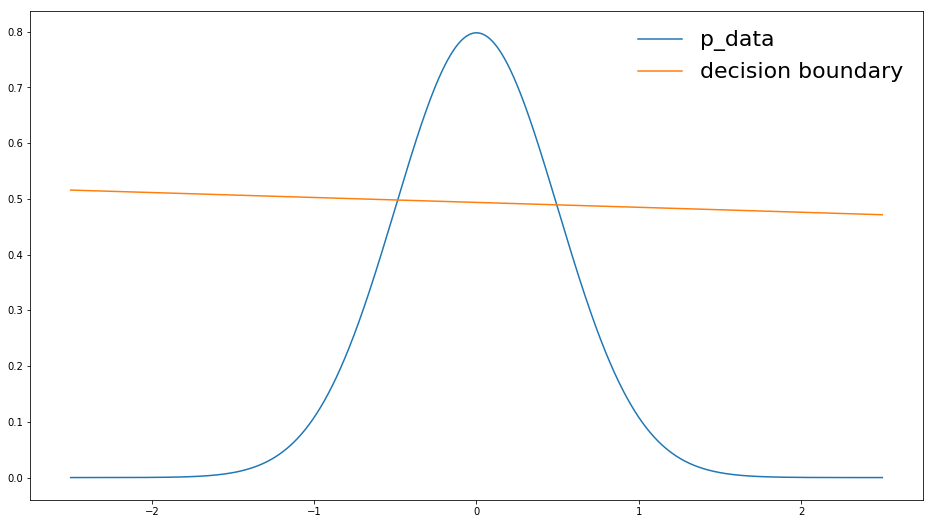

In [10]:
import random
losses = {"d_f":[], "d_t":[], "d":[], "g":[]}
def train(G, D, M, epoch):
    
    true_disc_x = gaussian(batch_size,mu=0.,sigma=0.5)
    sd = np.std(true_disc_x)
    mean = np.mean(true_disc_x)
    latent = noise_g(batch_size, mu=0., sigma = 2.)  # m=true_disc_x.min(), M=true_disc_x.max())
    true_disc_y = np.zeros(batch_size)
    fake_disc_x = G.predict(latent)
    fake_disc_y = np.ones(batch_size)
    
    x_disc = np.concatenate((true_disc_x, fake_disc_x))
    x_disc = x_disc.reshape((x_disc.shape[0], 1))
    y_disc = np.concatenate((true_disc_y, fake_disc_y))
    y_disc = y_disc.reshape((y_disc.shape[0], 1))
    
    G.trainable = False
    D.trainable = True
    d_loss_true = D.train_on_batch(true_disc_x, true_disc_y)
    d_loss_fake = D.train_on_batch(fake_disc_x, fake_disc_y)
    d_loss = (d_loss_true + d_loss_fake) / 2.0
    losses["d_f"].append(d_loss_fake)
    losses["d_t"].append(d_loss_true)
    losses["d"].append(d_loss)
    
    x_gen = latent
    y_gen = np.zeros(batch_size)    
       
    G.trainable = True 
    D.trainable = False    
    
    GAN_loss = M.train_on_batch(x_gen, y_gen)
    losses["g"].append(GAN_loss)
    
    return d_loss, GAN_loss
plot_decision_boundary(D)


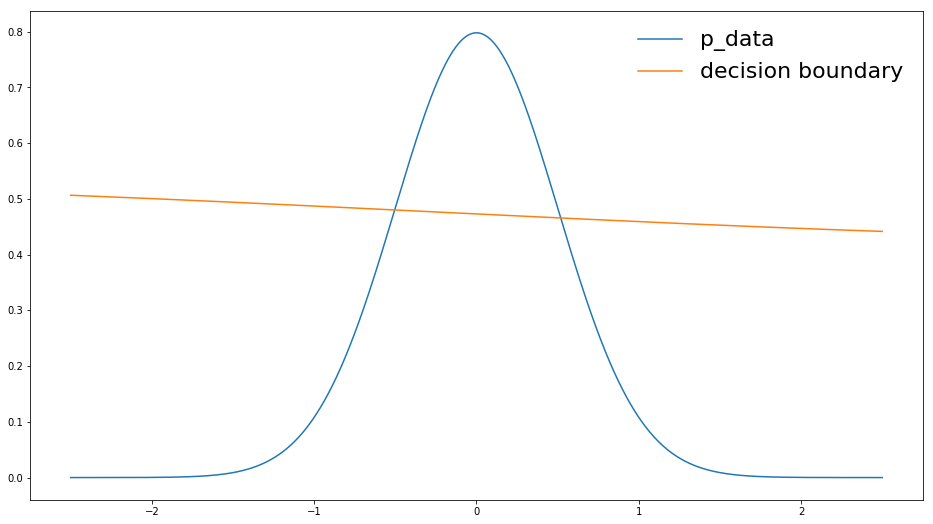

0.741435050964


In [13]:
#pretrain dicriminator

batch_size = 3000
pretrain_disc = True
if pretrain_disc ==True:
    
    for z in xrange(0,1):
        true_disc_x = gaussian(batch_size,mu=0., sigma=0.5)
        latent = noise_g(batch_size, mu=0., sigma=2.0)
        true_disc_y = np.zeros(batch_size)
        fake_disc_x = G.predict(latent)
        fake_disc_y = np.ones(batch_size)
        #x_disc = np.concatenate((true_disc_x, fake_disc_x))
        #x_disc = x_disc.reshape((x_disc.shape[0], 1))
        #y_disc = np.concatenate((true_disc_y, fake_disc_y))

        G.trainable = False
        D.trainable = True
        #d_loss_true = D.train_on_batch(true_disc_x, true_disc_y)
        #d_loss_fake = D.train_on_batch(fake_disc_x, fake_disc_y)
        d_loss = D.train_on_batch(true_disc_x, true_disc_y)
        d_loss = D.train_on_batch(fake_disc_x, fake_disc_y)
        plot_decision_boundary(D)
        print d_loss


Epoch 1, Discriminator loss:0.712999939919, GAN loss:0.717112123966
For true: mean and s.d. =  0.00301383695226 0.495128962676
For generator: mean and s.d. =  -0.0932661 0.070666


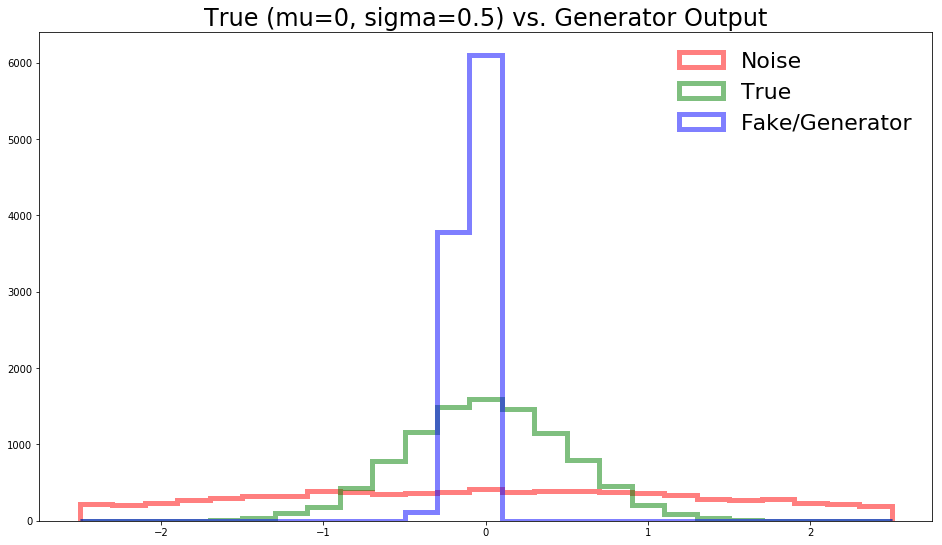

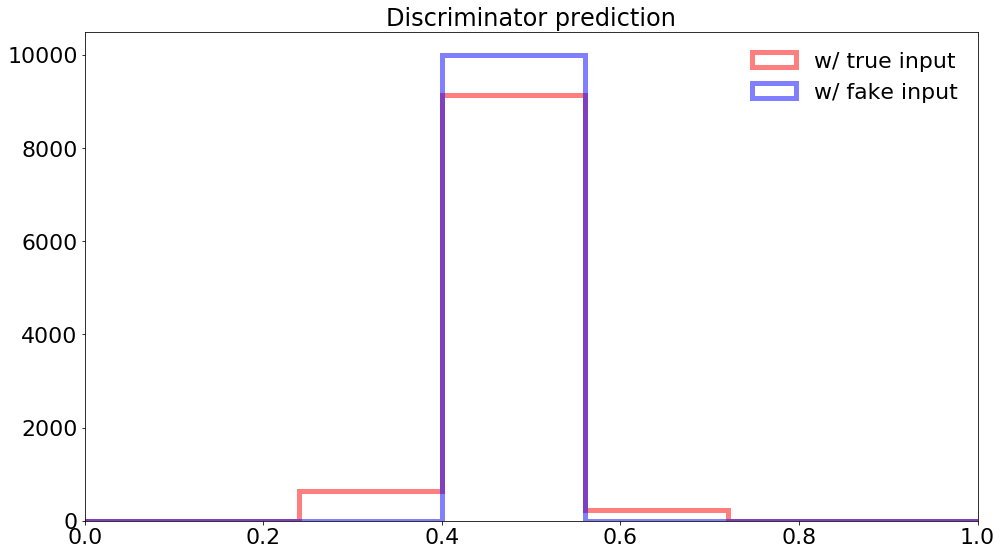

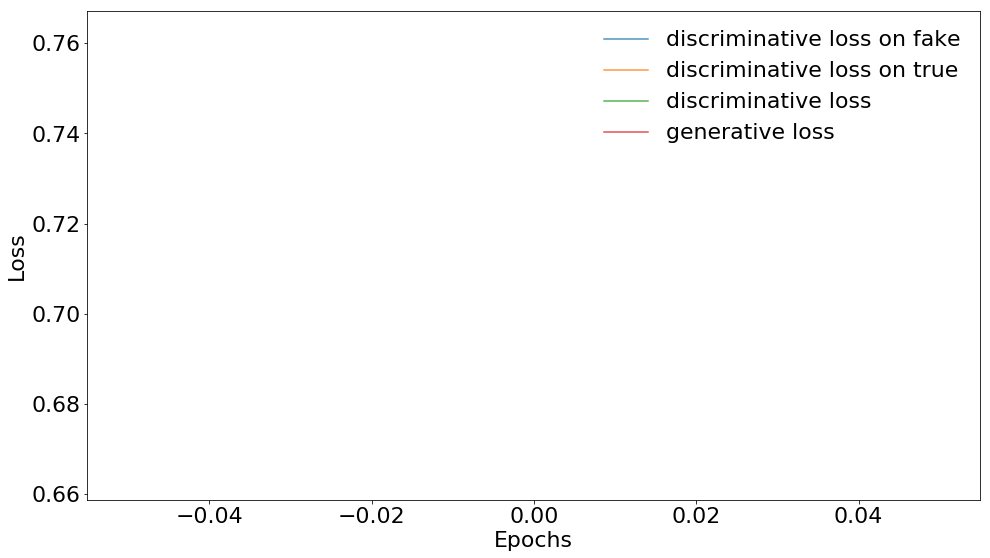

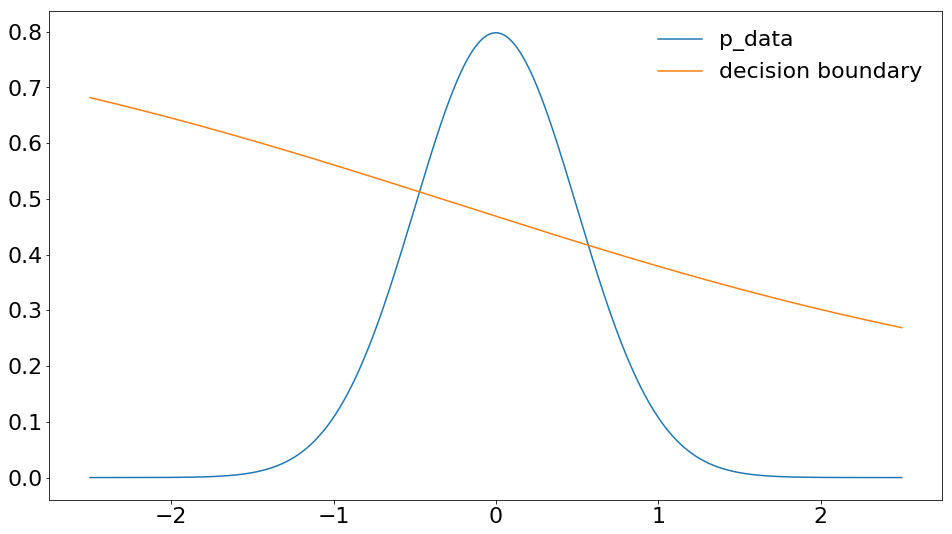

Epoch 51, Discriminator loss:0.608836054802, GAN loss:1.04396653175
For true: mean and s.d. =  0.00221648697959 0.500832813935
For generator: mean and s.d. =  -0.113908 0.117218


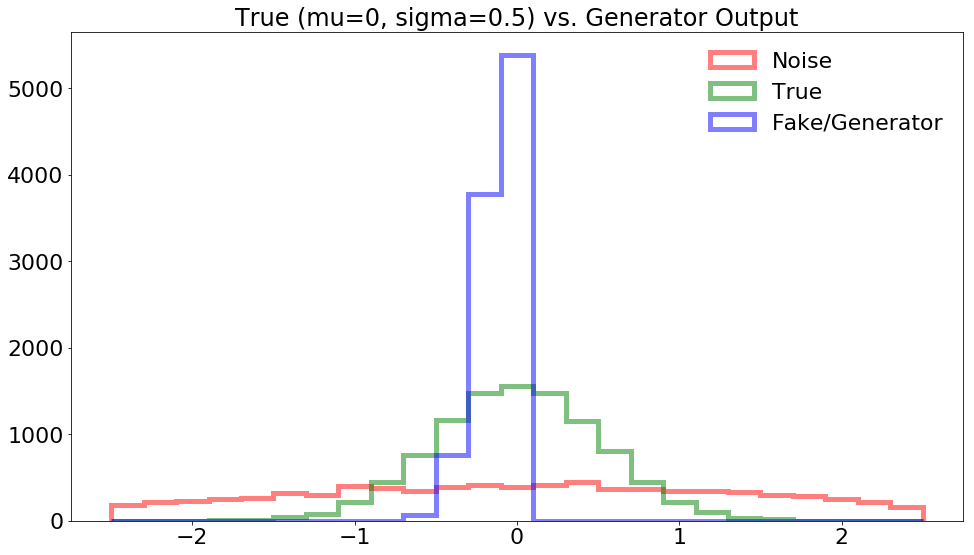

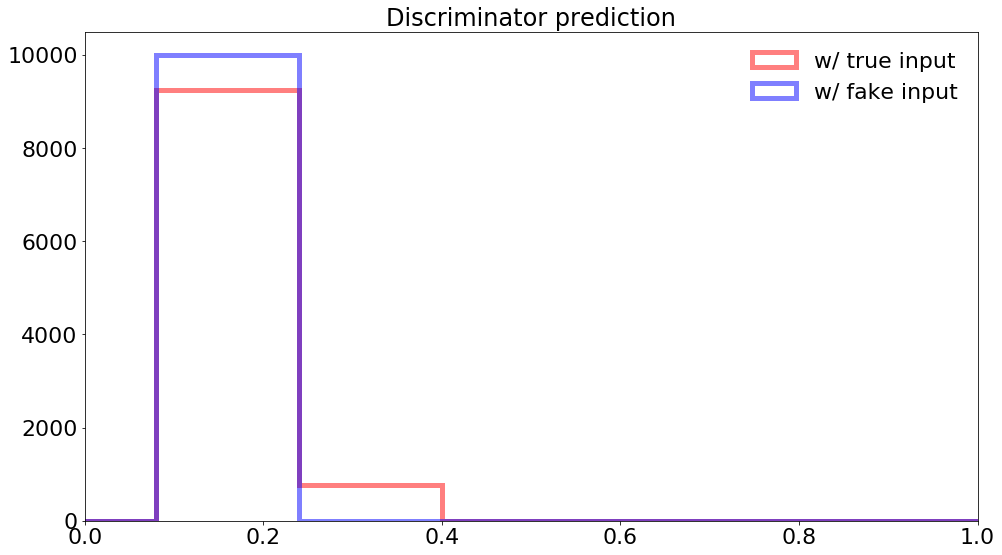

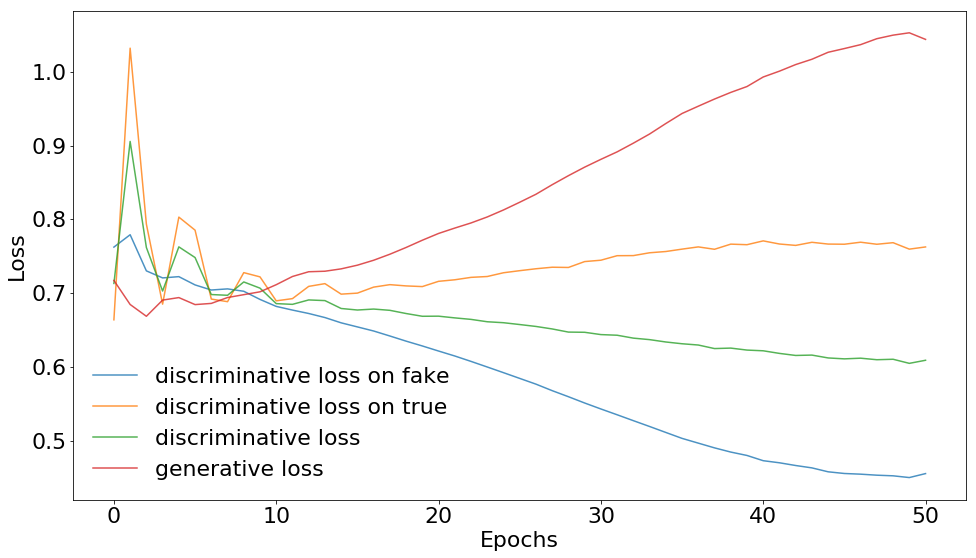

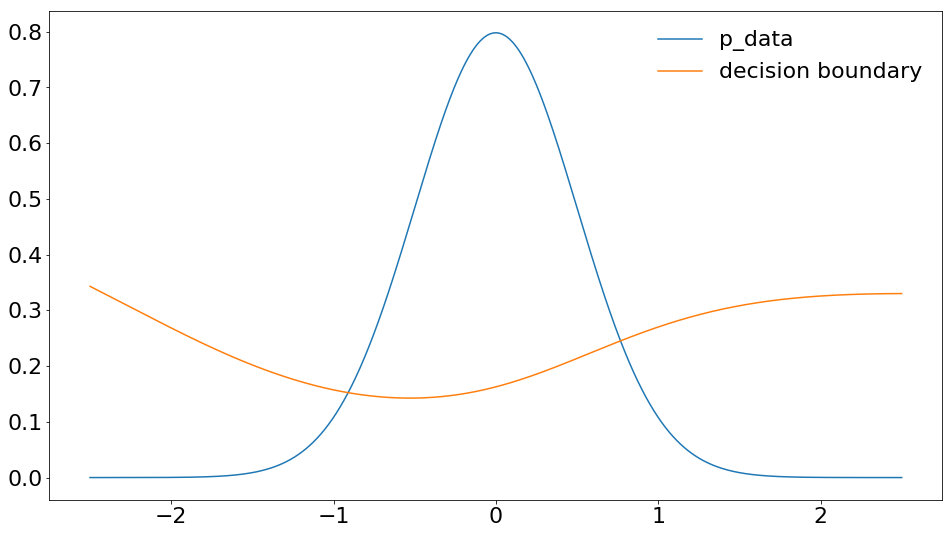

Epoch 101, Discriminator loss:0.690014719963, GAN loss:0.726352214813
For true: mean and s.d. =  0.00255774165133 0.500077016824
For generator: mean and s.d. =  -0.126083 0.527851


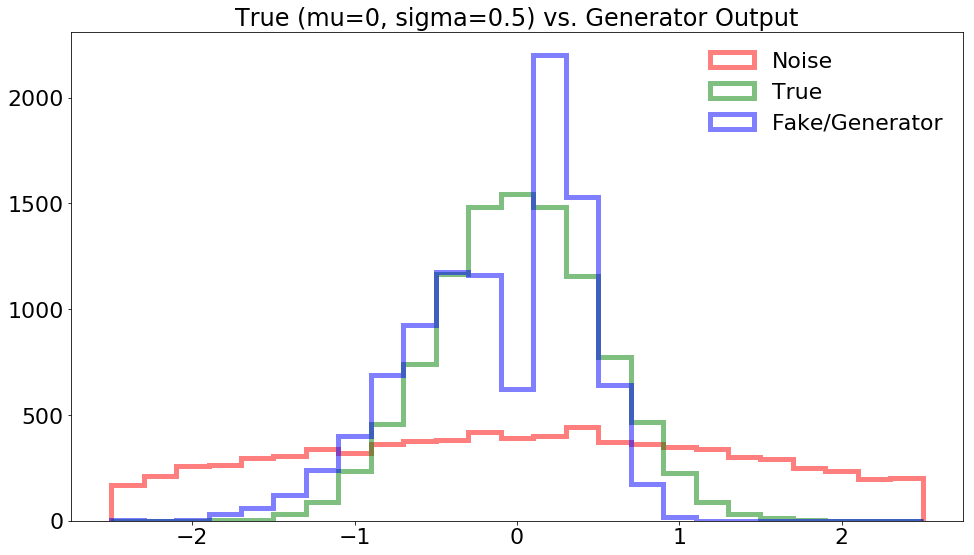

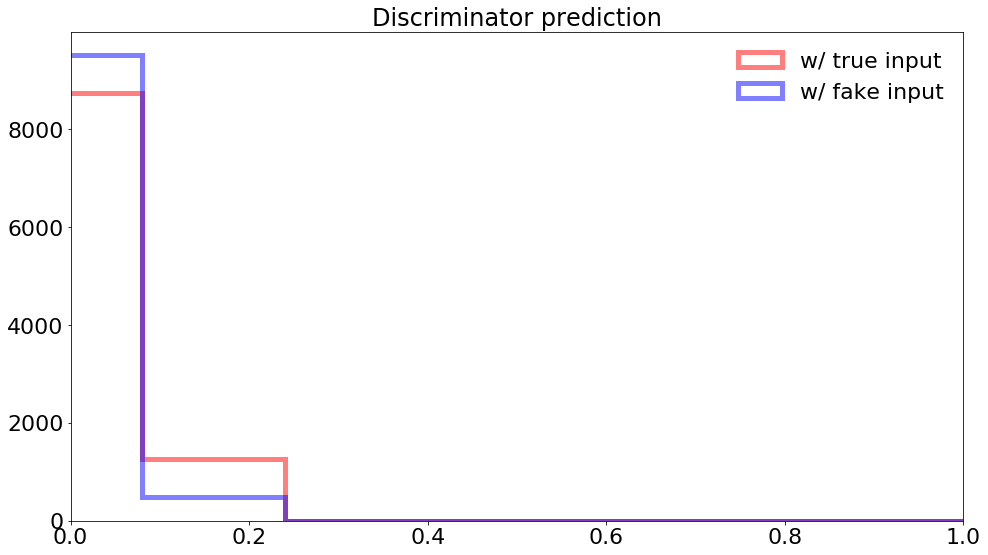

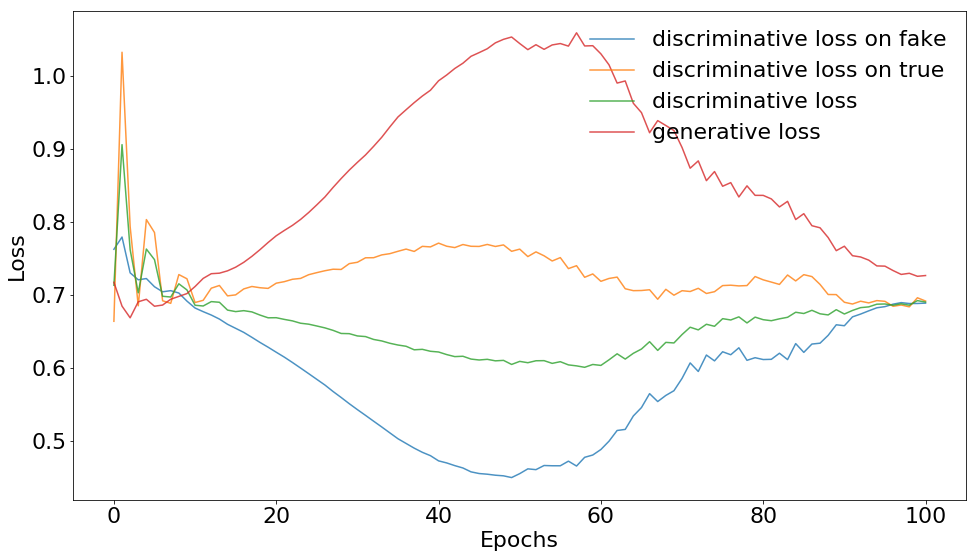

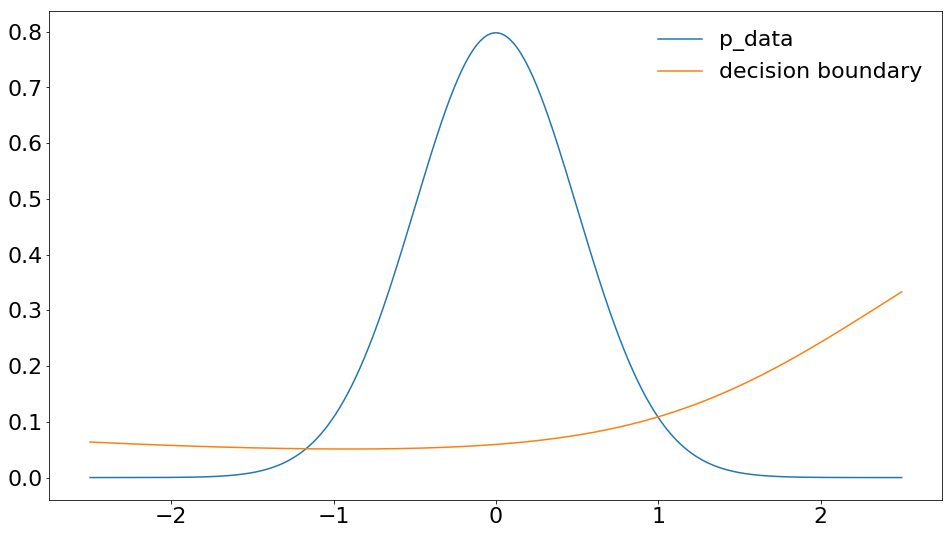

Epoch 151, Discriminator loss:0.676040410995, GAN loss:0.73786598444
For true: mean and s.d. =  -0.00326193526039 0.498431842319
For generator: mean and s.d. =  -0.106666 0.57481


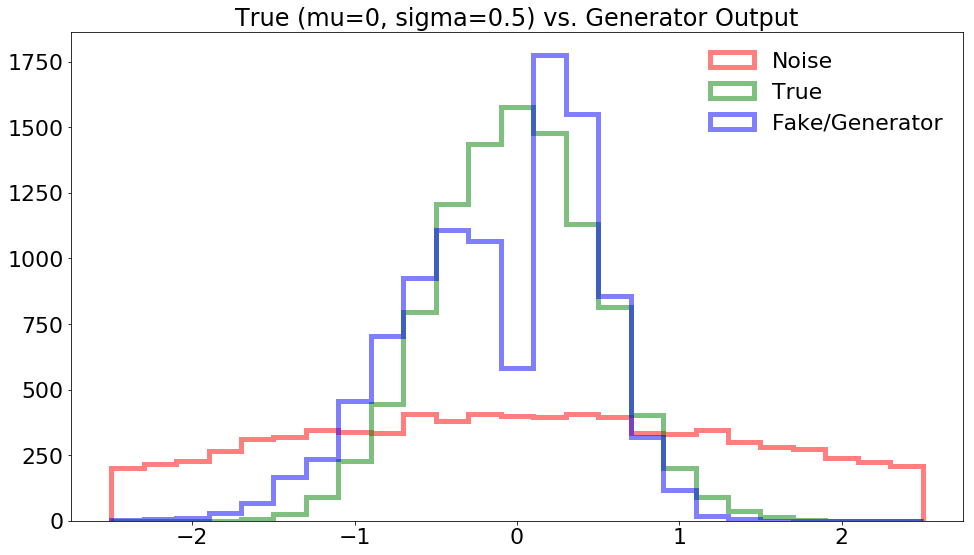

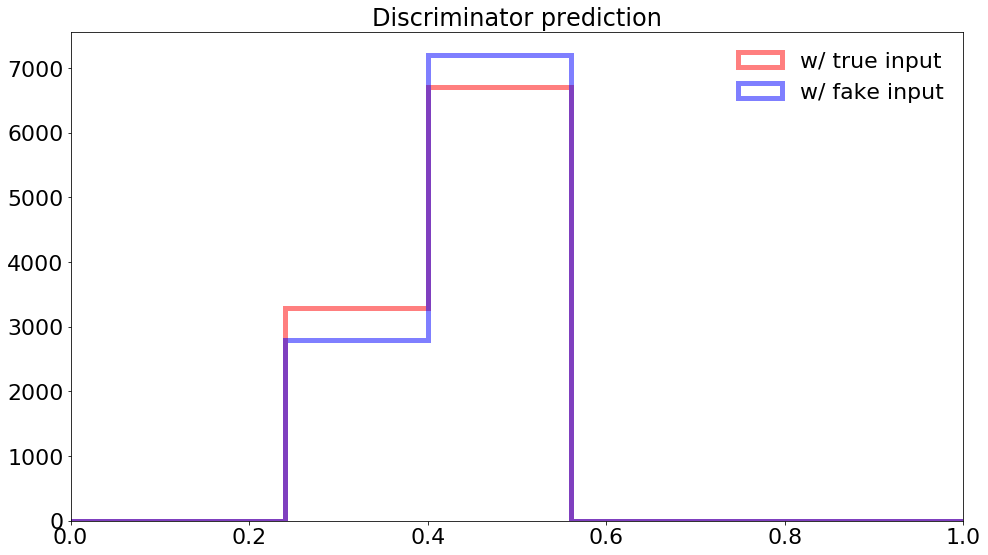

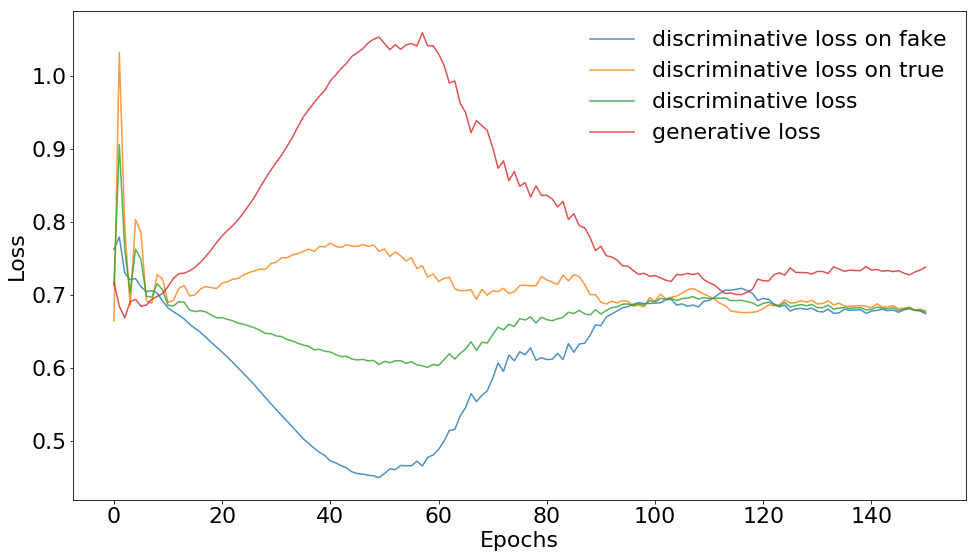

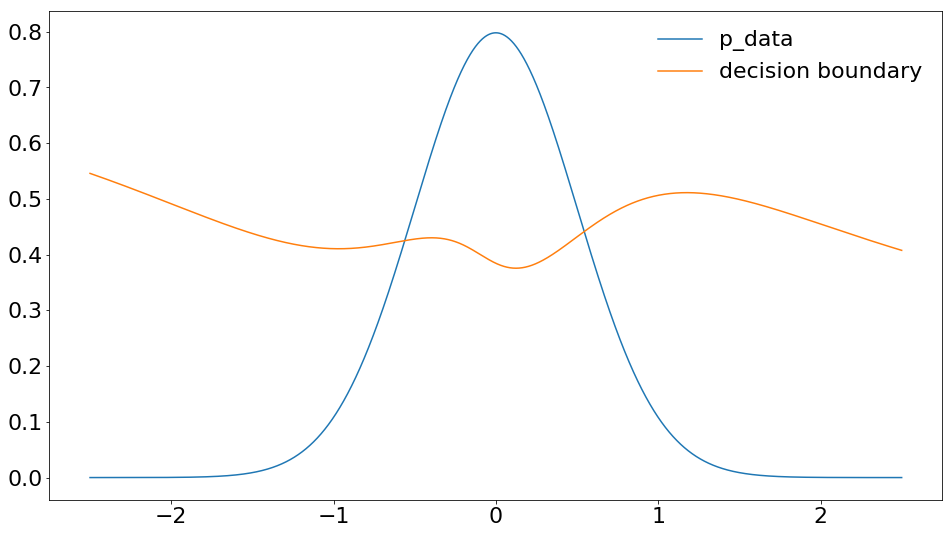

Epoch 201, Discriminator loss:0.684646725655, GAN loss:0.716873884201
For true: mean and s.d. =  -0.00177285164553 0.496737351057
For generator: mean and s.d. =  -0.0822064 0.464254


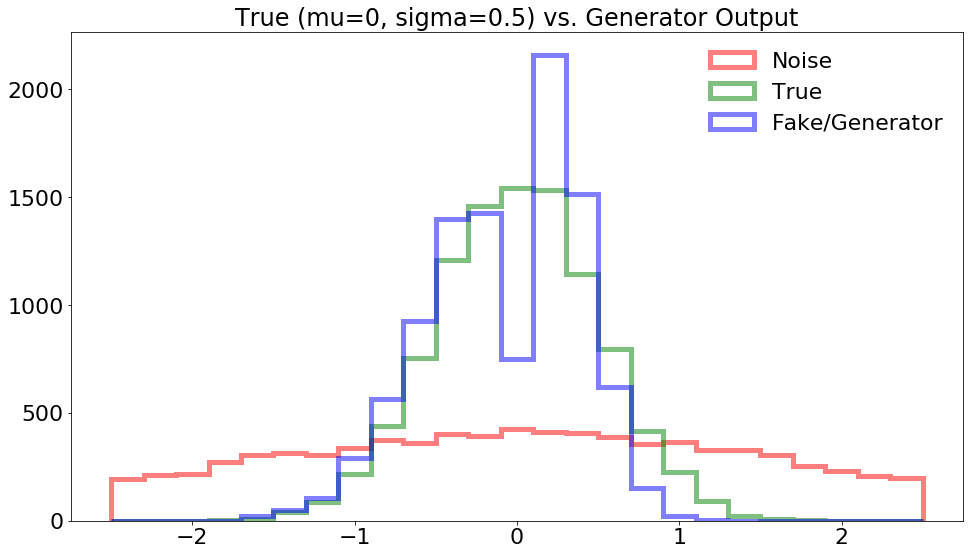

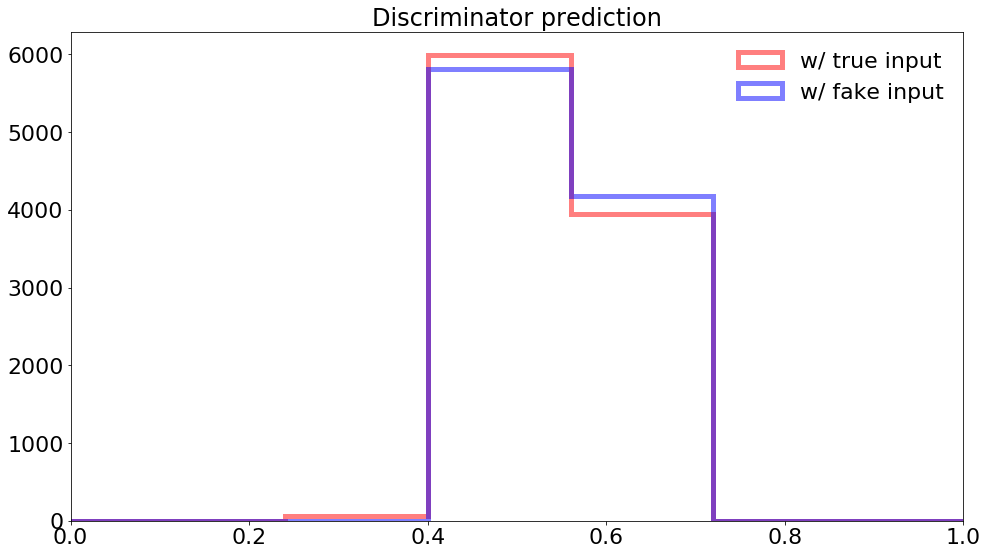

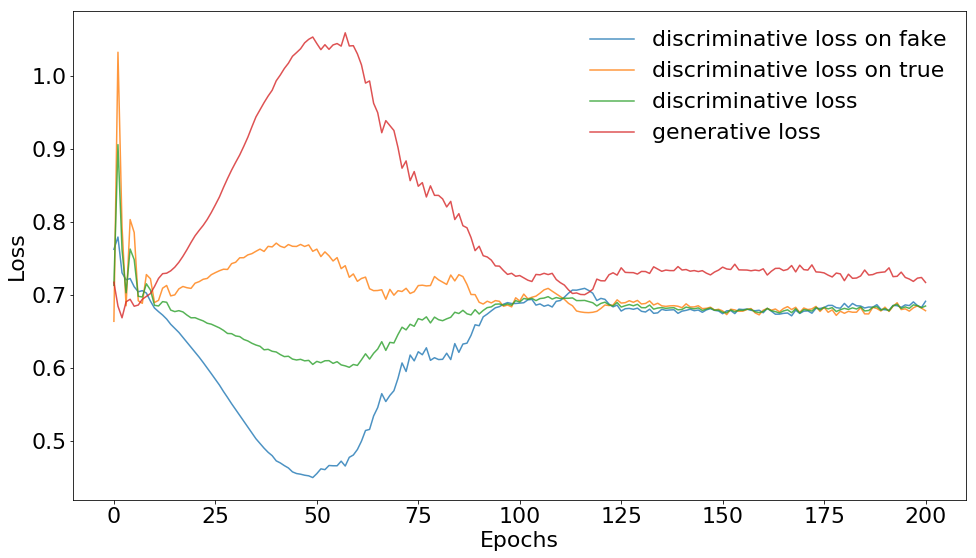

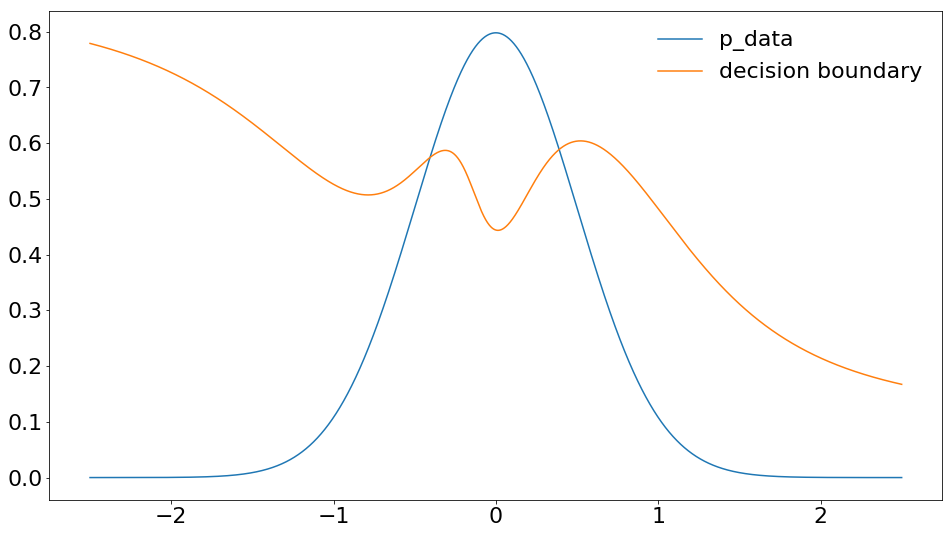

Epoch 251, Discriminator loss:0.682893276215, GAN loss:0.72147667408
For true: mean and s.d. =  -0.00375265640632 0.501941036059
For generator: mean and s.d. =  -0.0589853 0.423251


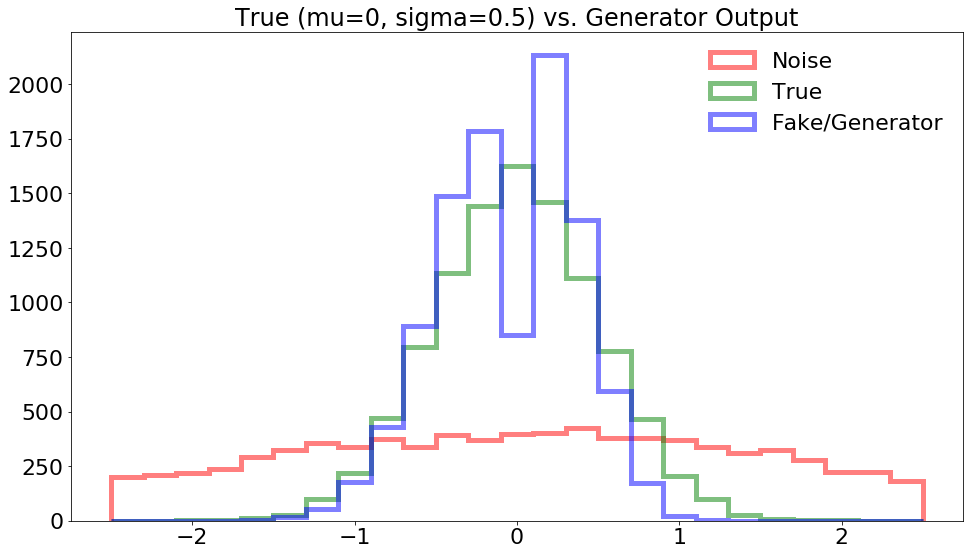

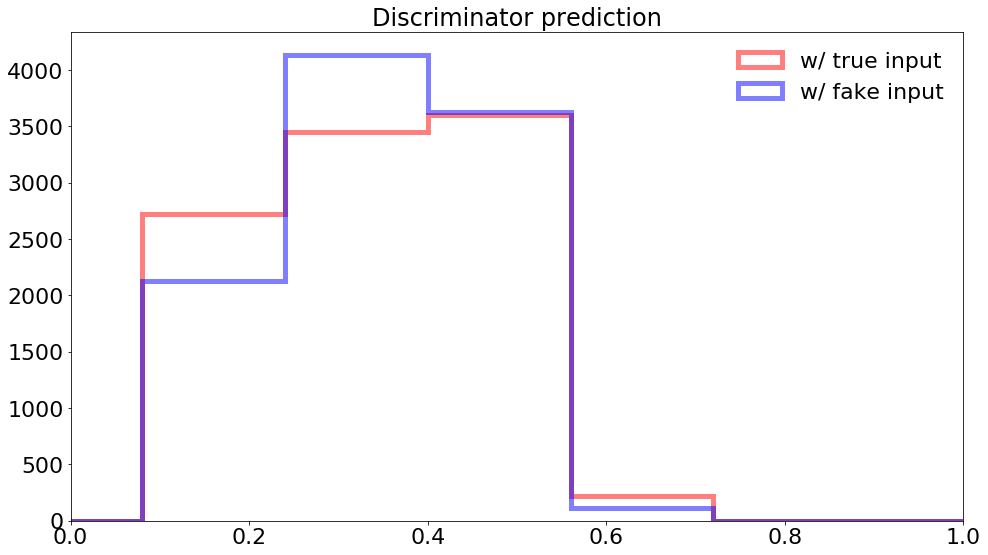

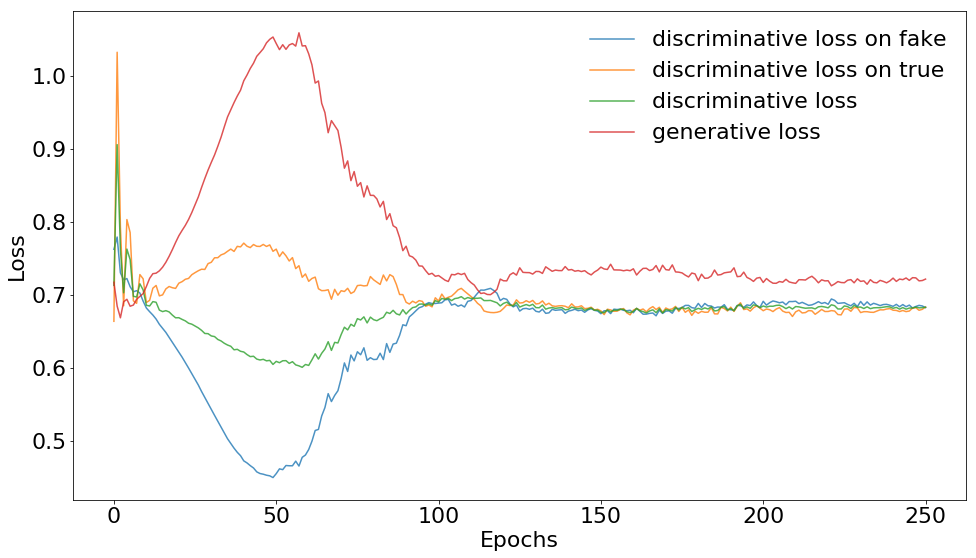

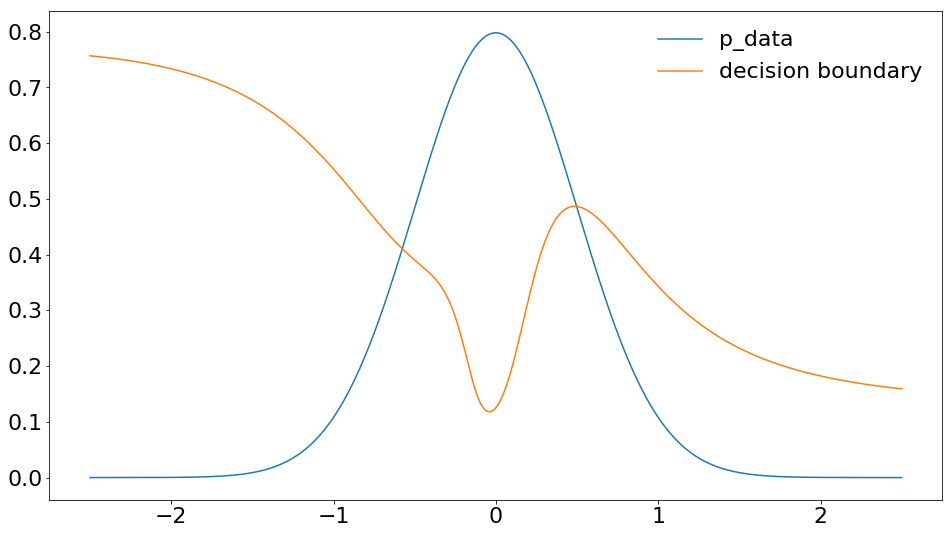

Epoch 301, Discriminator loss:0.68975007534, GAN loss:0.71514159441
For true: mean and s.d. =  -0.00910831586033 0.501368156489
For generator: mean and s.d. =  -0.0289335 0.486692


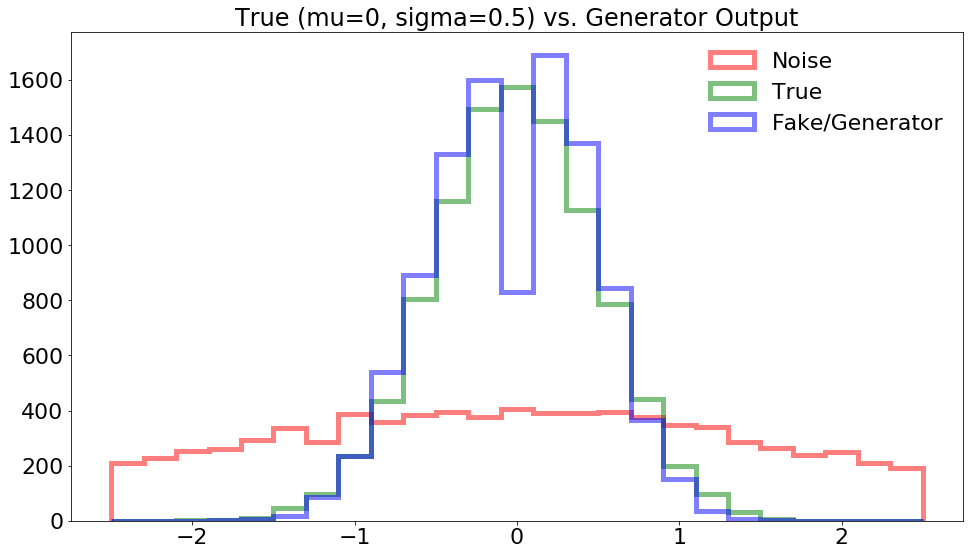

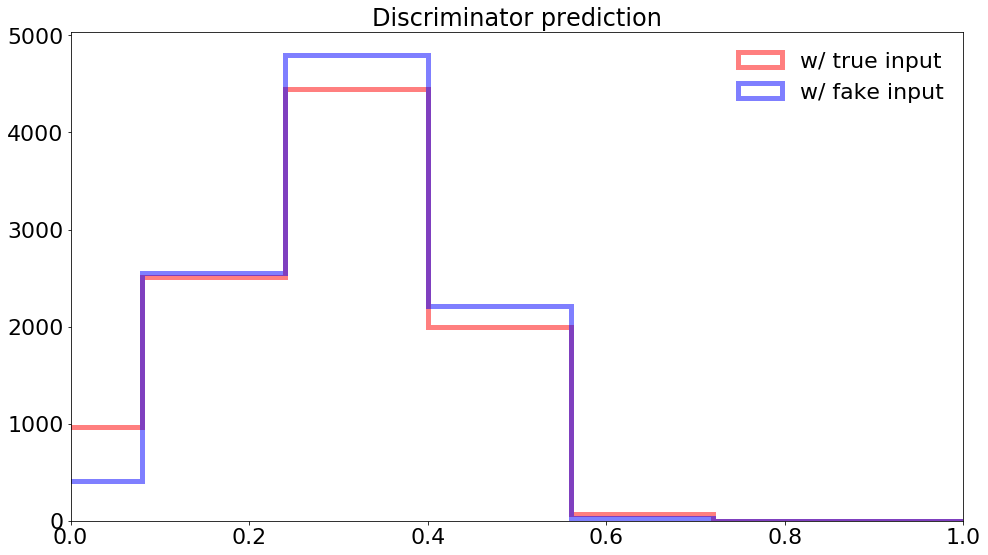

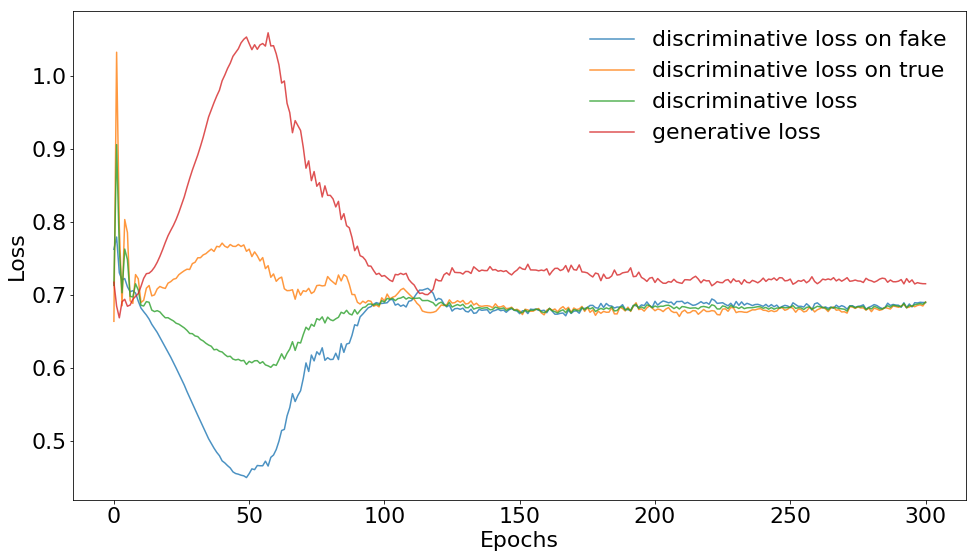

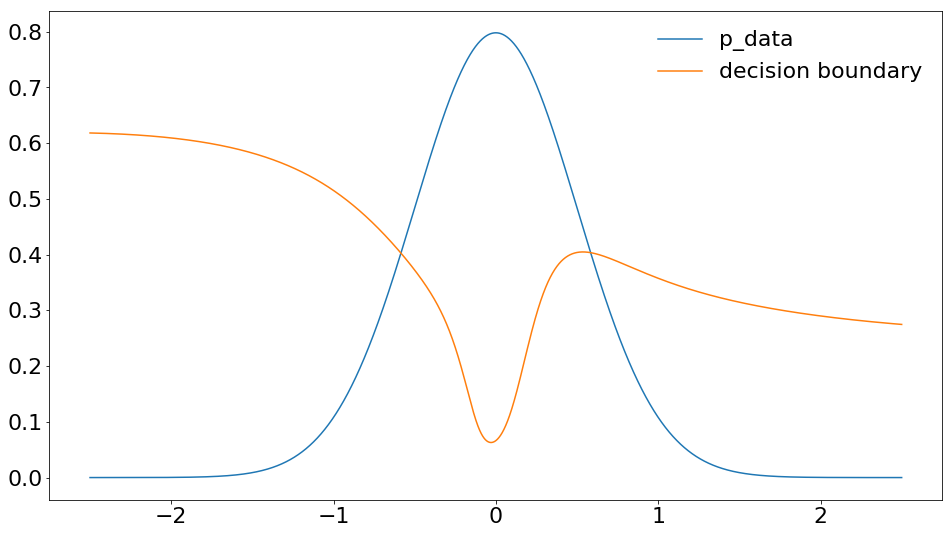

Epoch 351, Discriminator loss:0.690522134304, GAN loss:0.716704308987
For true: mean and s.d. =  -0.00743106861362 0.502573583222
For generator: mean and s.d. =  -0.0267443 0.561593


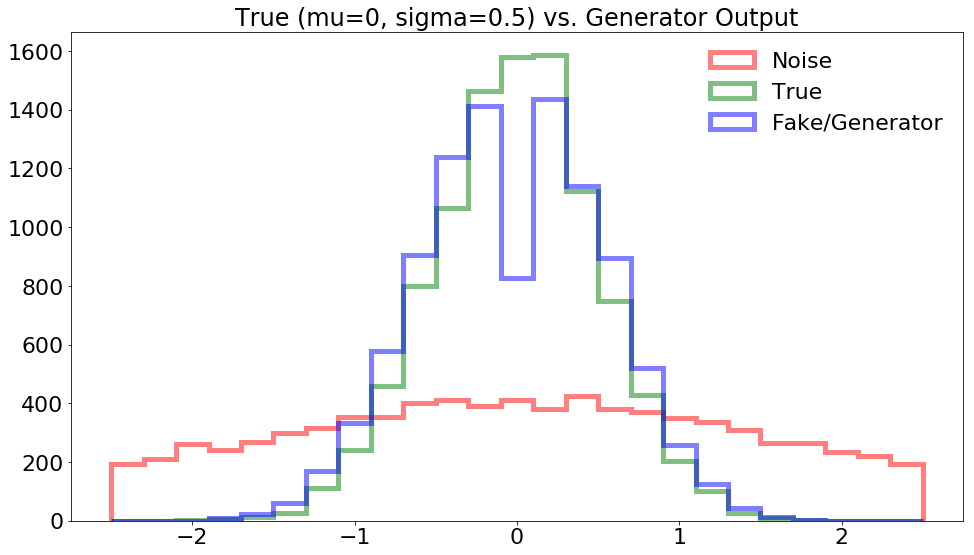

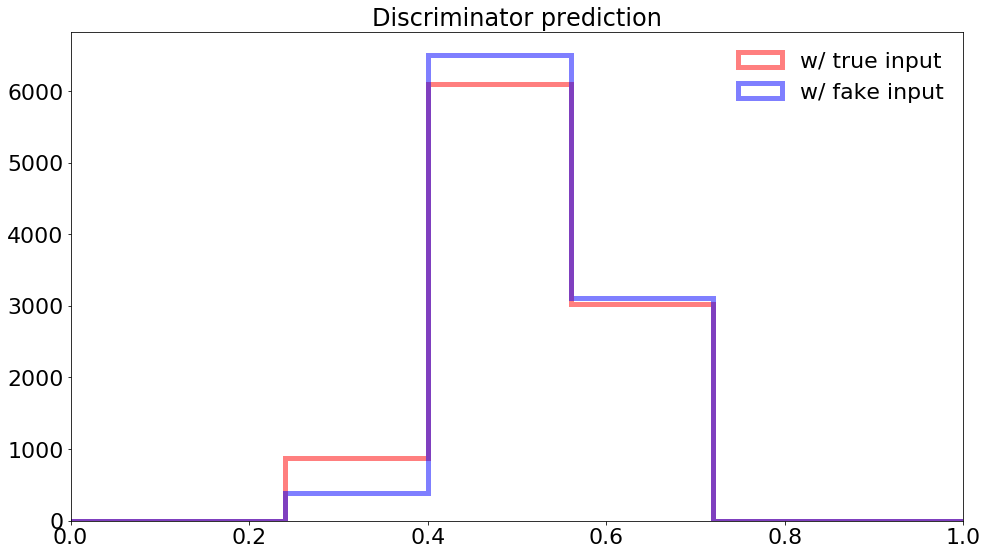

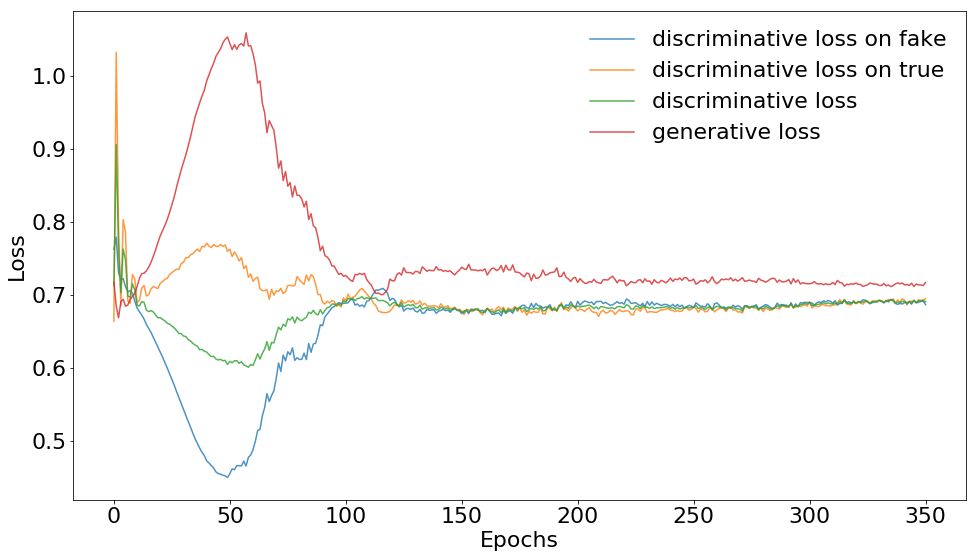

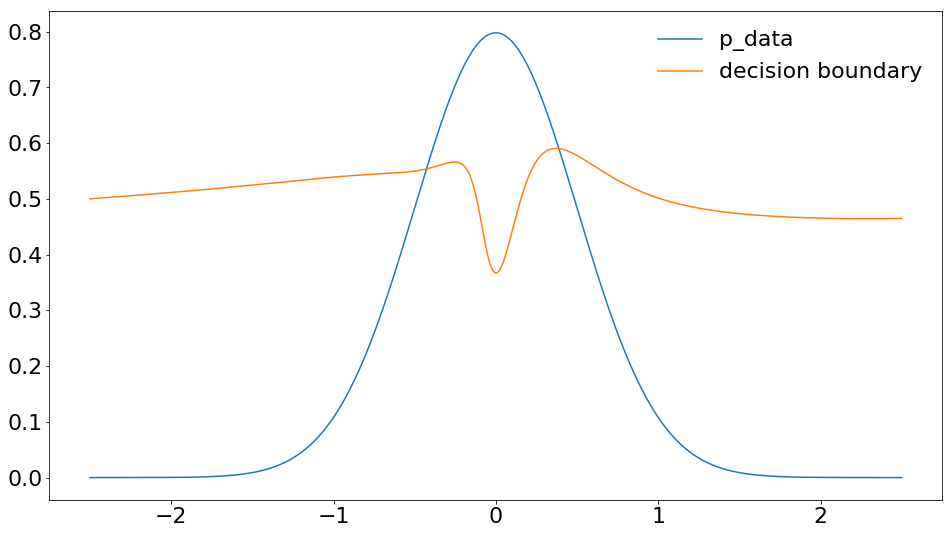

Epoch 401, Discriminator loss:0.690505564213, GAN loss:0.715254306793
For true: mean and s.d. =  0.0128313737896 0.494991752395
For generator: mean and s.d. =  -0.0271942 0.528962


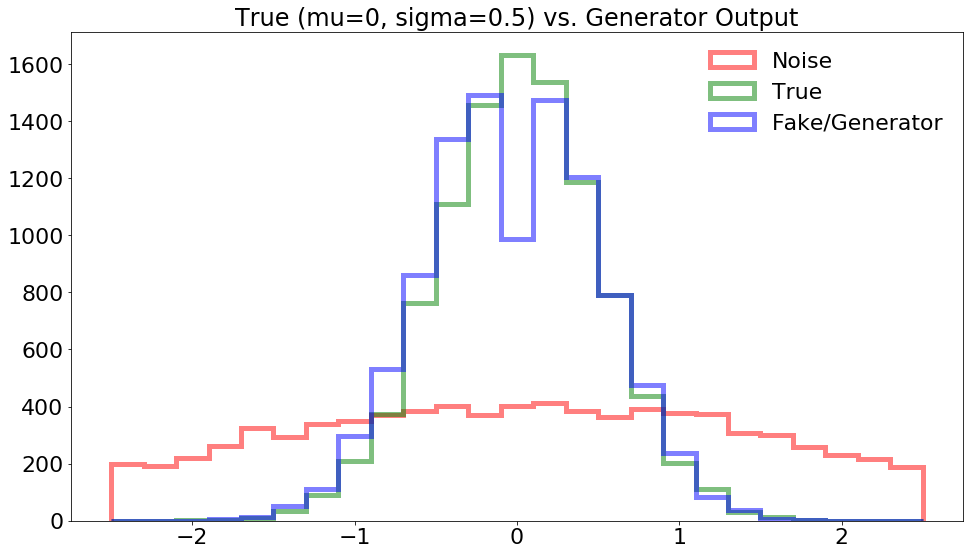

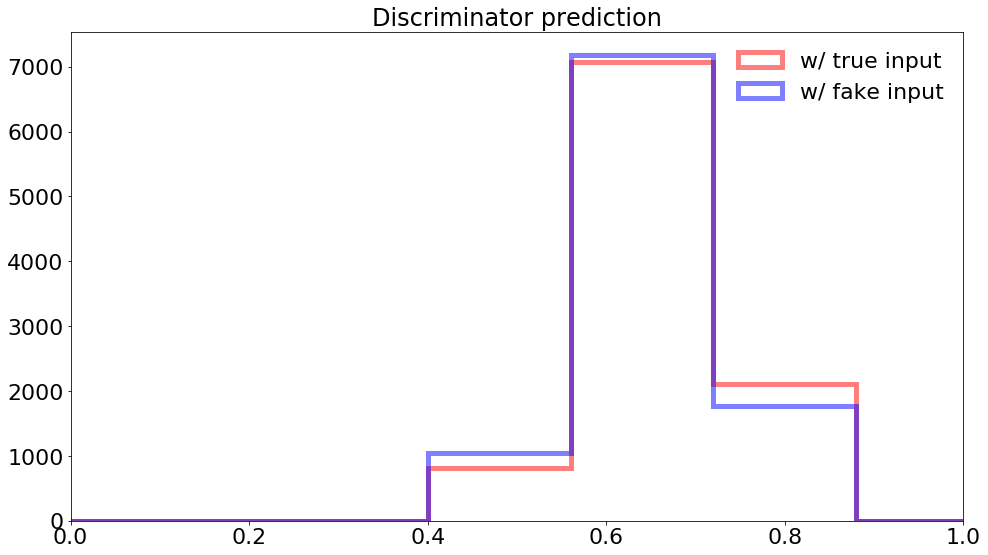

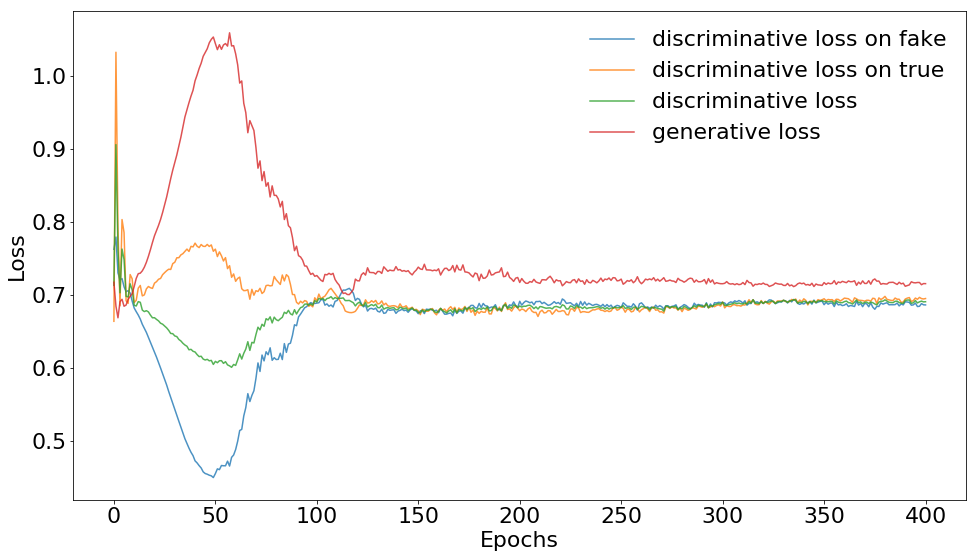

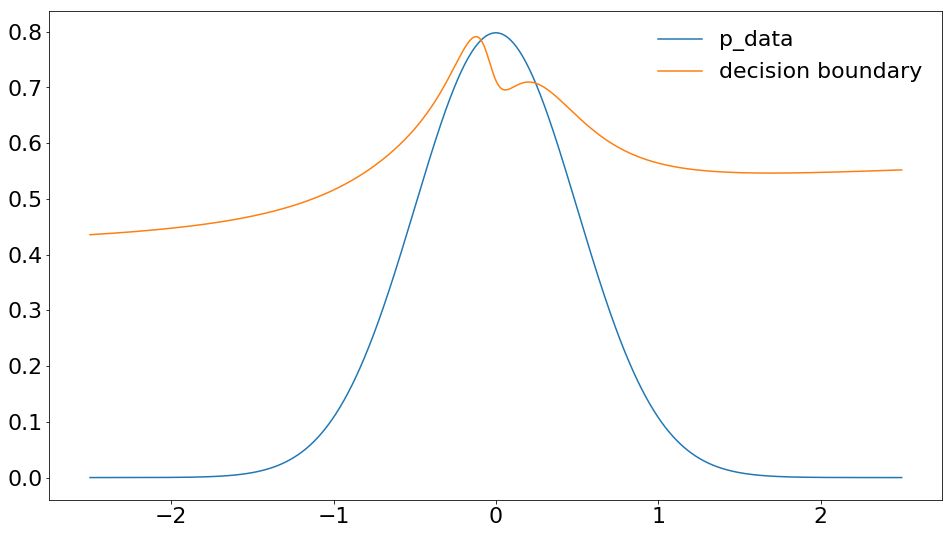

Epoch 451, Discriminator loss:0.695037484169, GAN loss:0.693237781525
For true: mean and s.d. =  -0.00318844512654 0.499436067906
For generator: mean and s.d. =  -0.0177744 0.458247


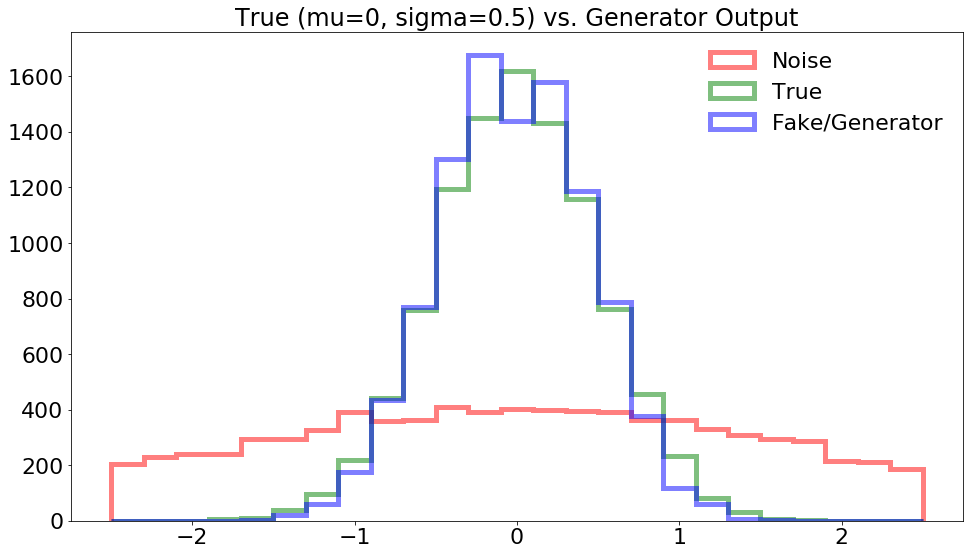

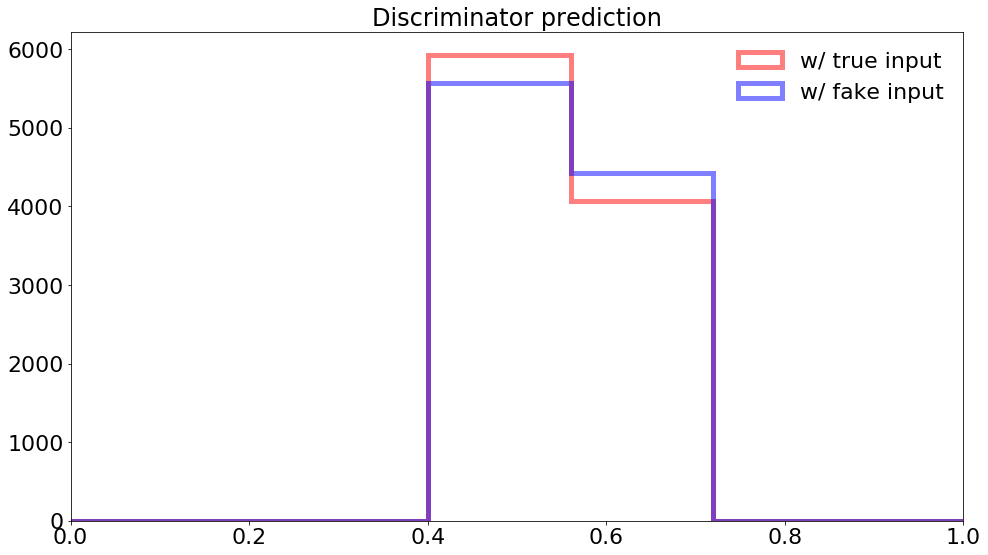

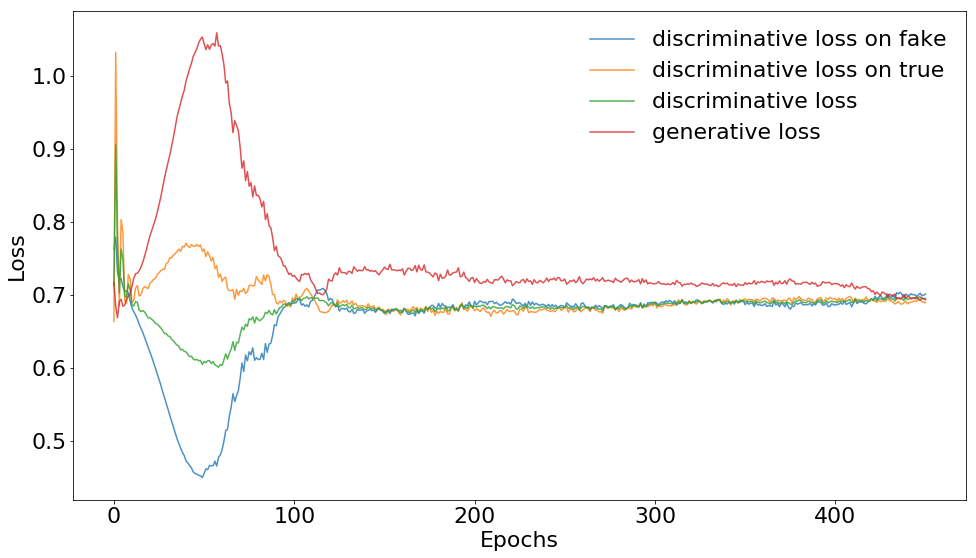

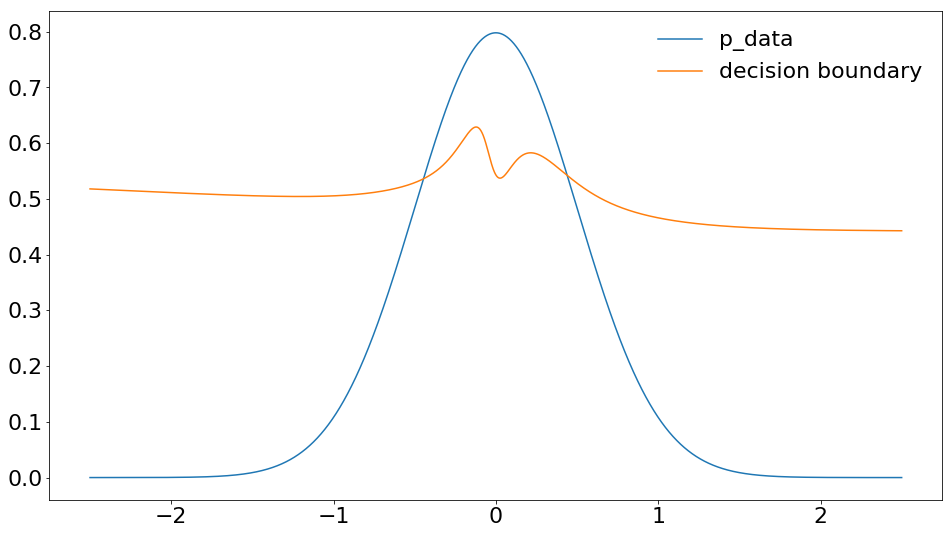

Epoch 501, Discriminator loss:0.693933546543, GAN loss:0.693573832512
For true: mean and s.d. =  -0.00562248921791 0.493144509054
For generator: mean and s.d. =  -0.0251382 0.448299


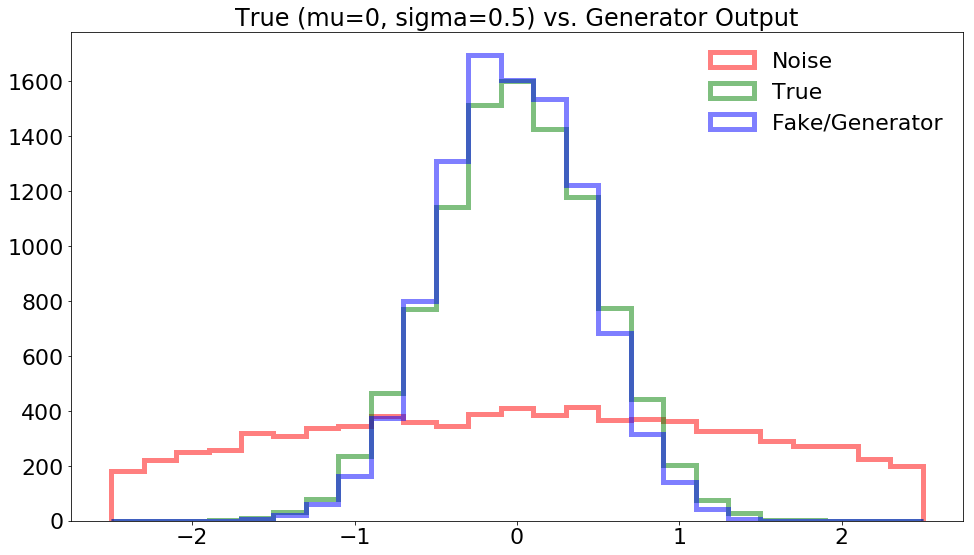

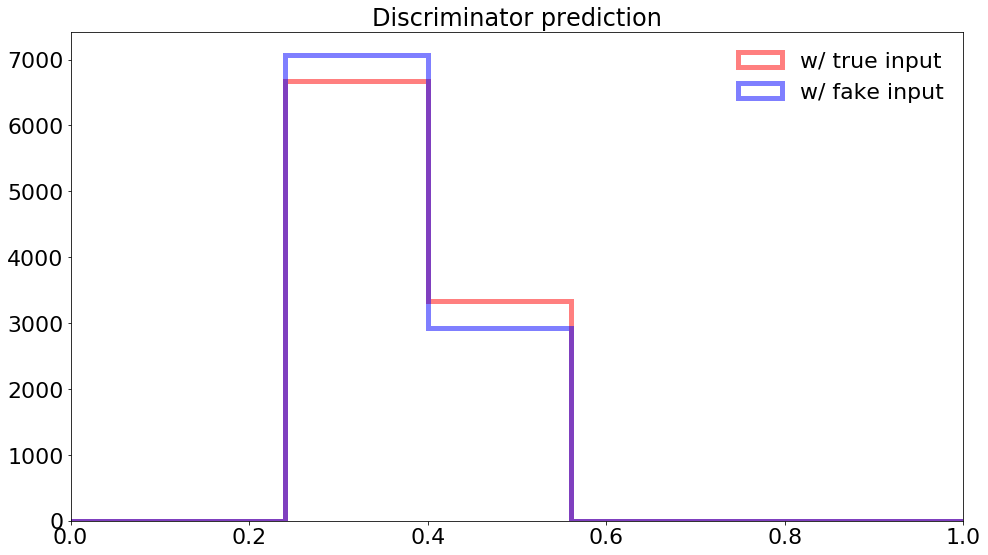

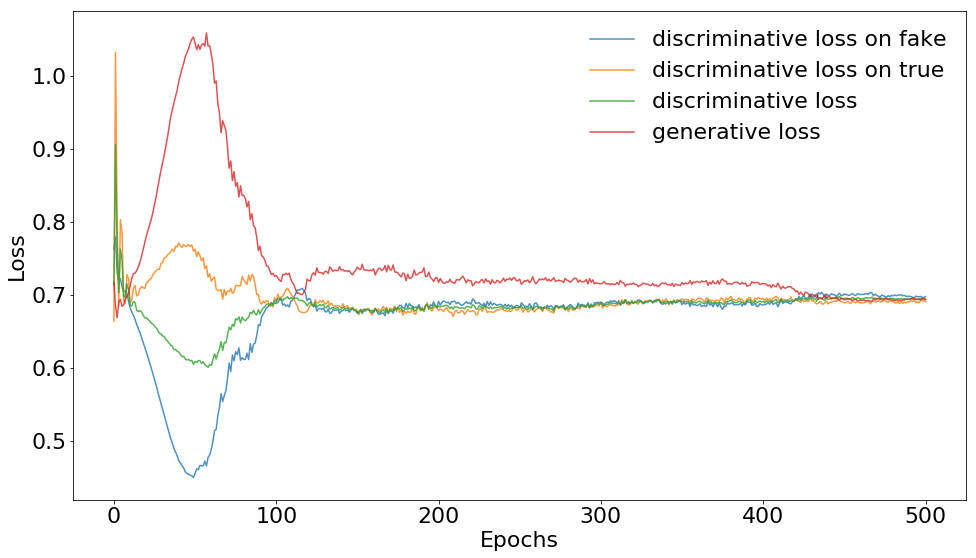

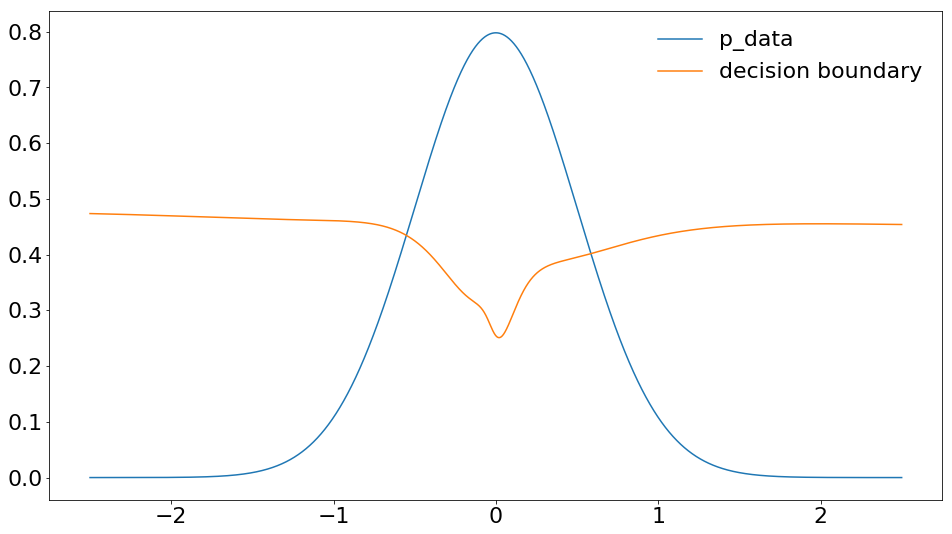

Epoch 551, Discriminator loss:0.6946849823, GAN loss:0.689776659012
For true: mean and s.d. =  0.000327264840553 0.506930579356
For generator: mean and s.d. =  -0.0127318 0.498256


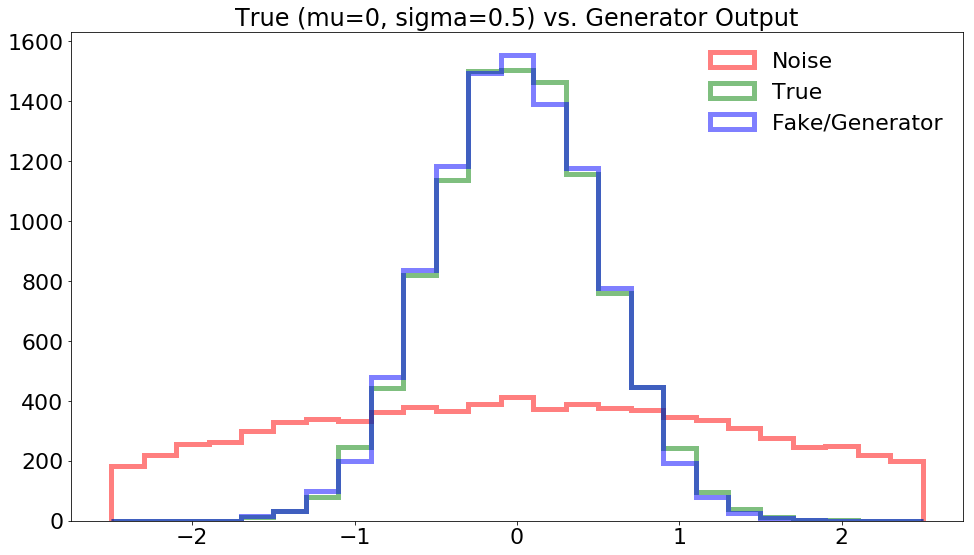

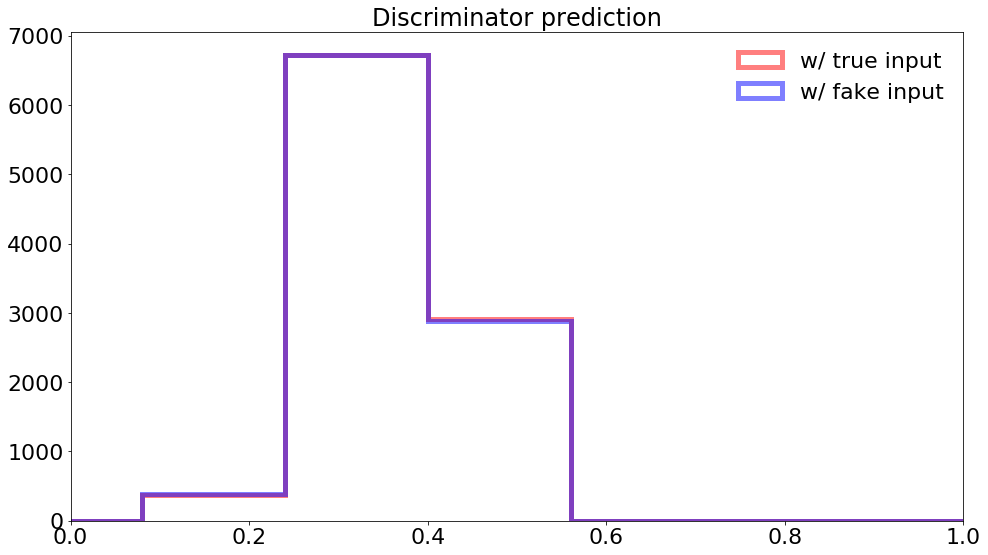

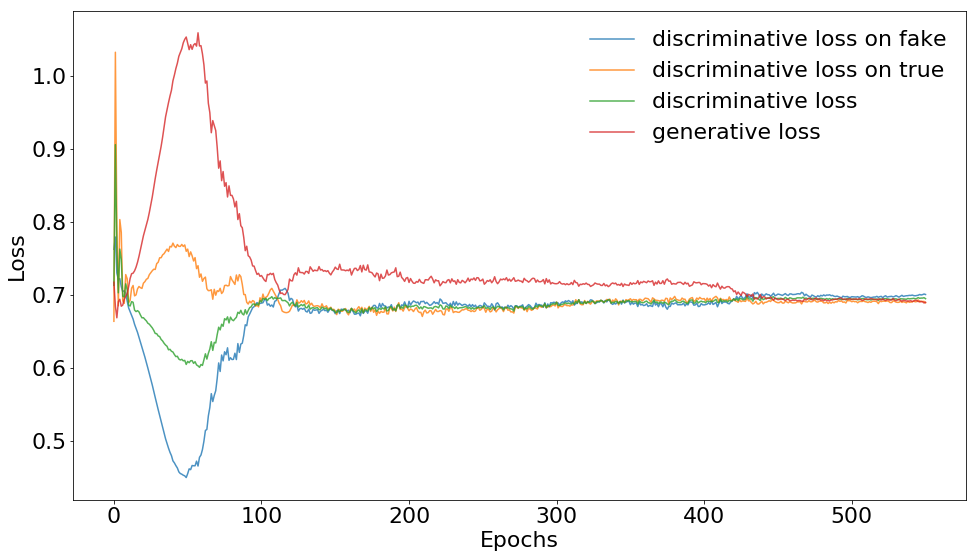

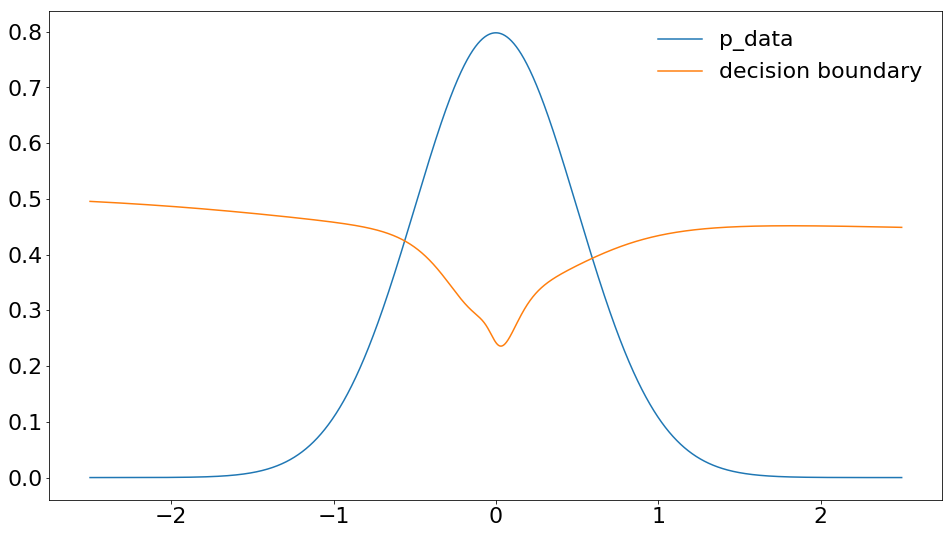

Epoch 601, Discriminator loss:0.695115208626, GAN loss:0.687752783298
For true: mean and s.d. =  -0.00304991433248 0.498768577669
For generator: mean and s.d. =  -0.0119127 0.538224


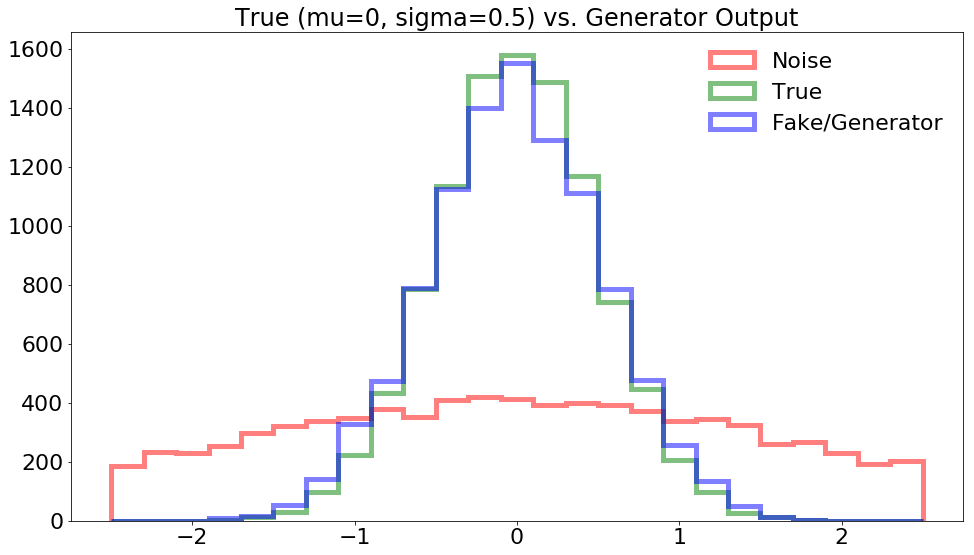

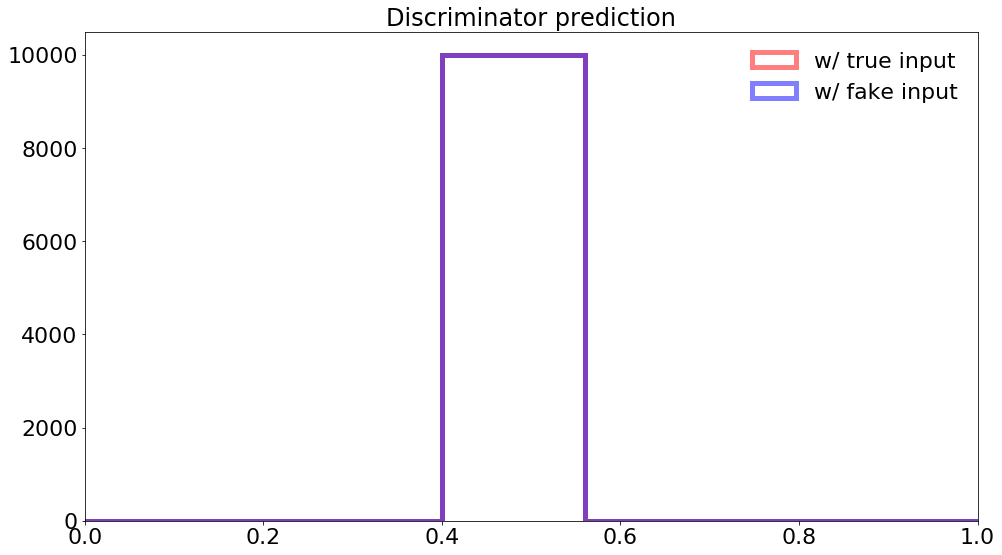

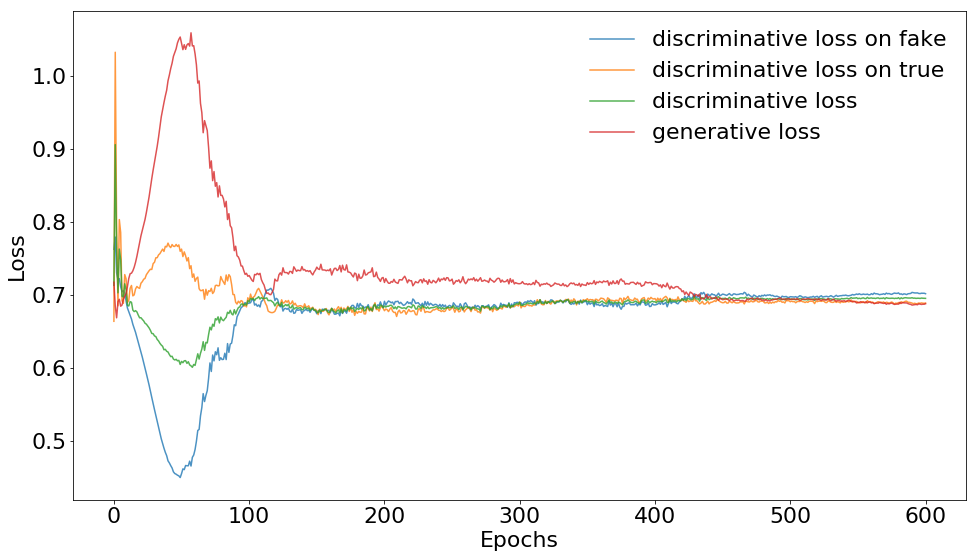

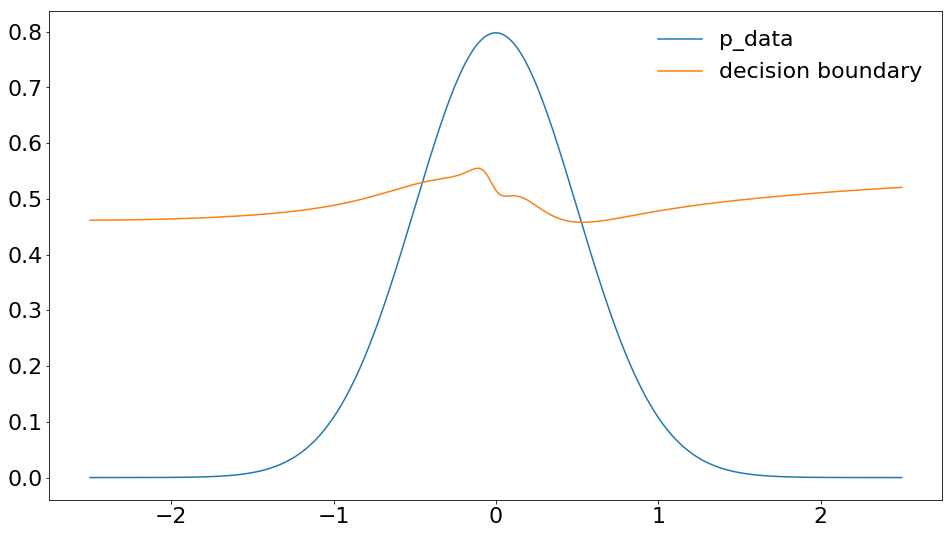

Epoch 651, Discriminator loss:0.694431185722, GAN loss:0.690234959126
For true: mean and s.d. =  0.00202903235707 0.499555979628
For generator: mean and s.d. =  -0.000512939 0.553025


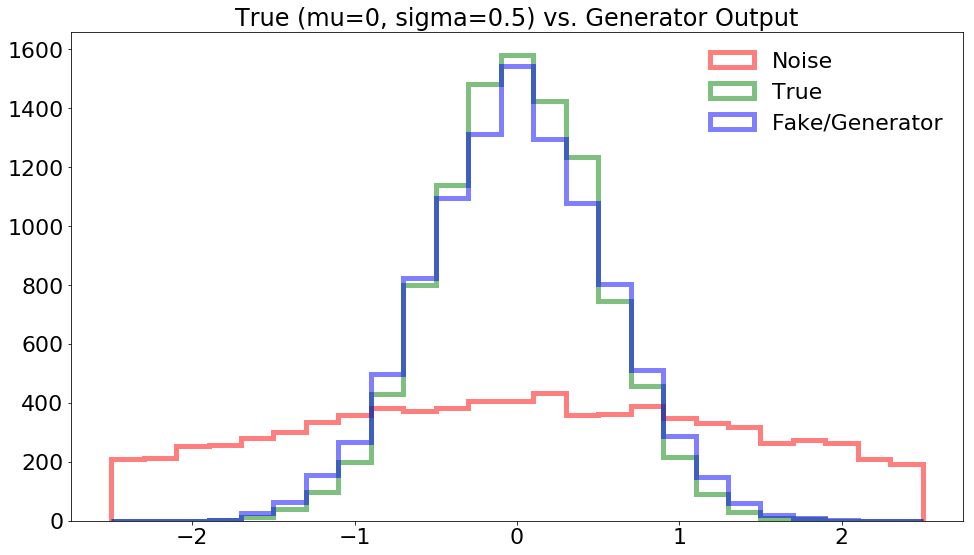

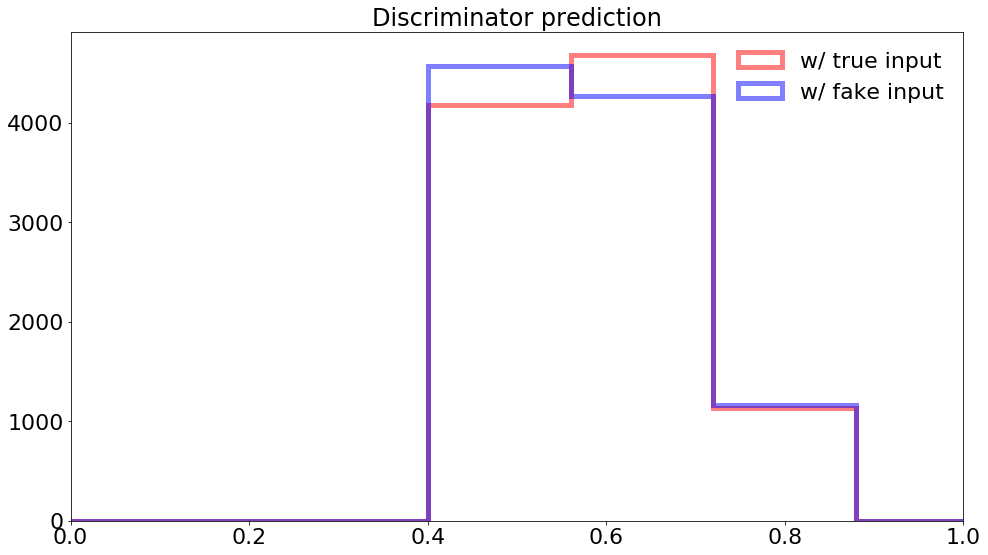

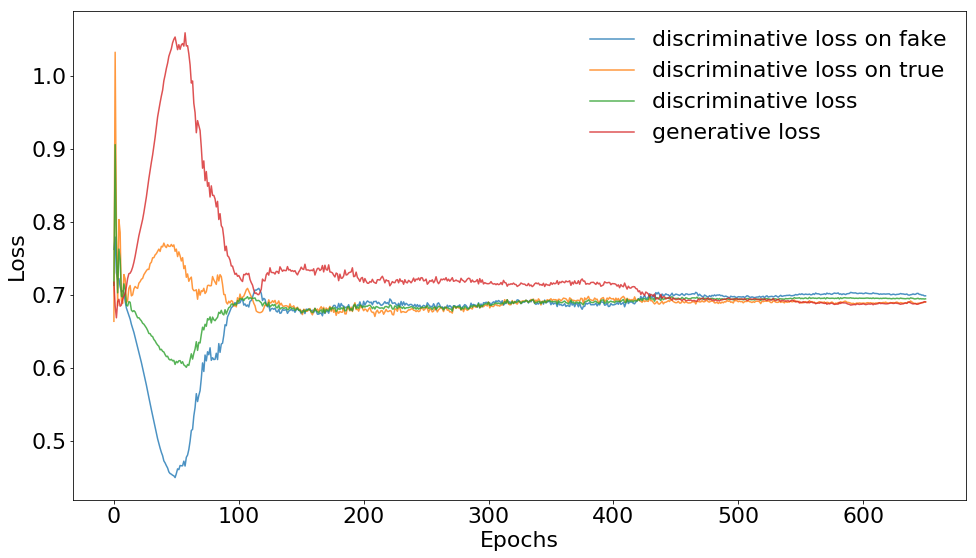

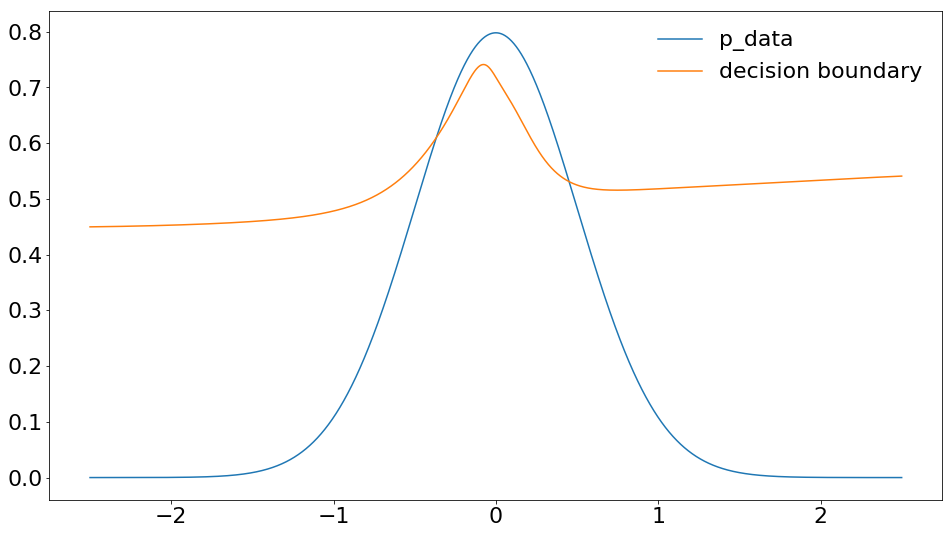

Epoch 701, Discriminator loss:0.693959355354, GAN loss:0.692162394524
For true: mean and s.d. =  0.00563013162624 0.507459243429
For generator: mean and s.d. =  -0.000562537 0.539507


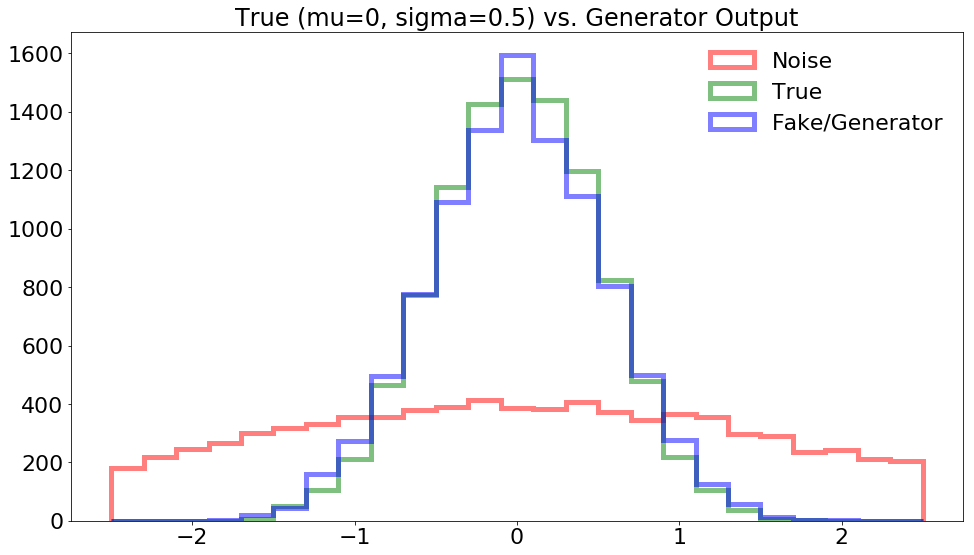

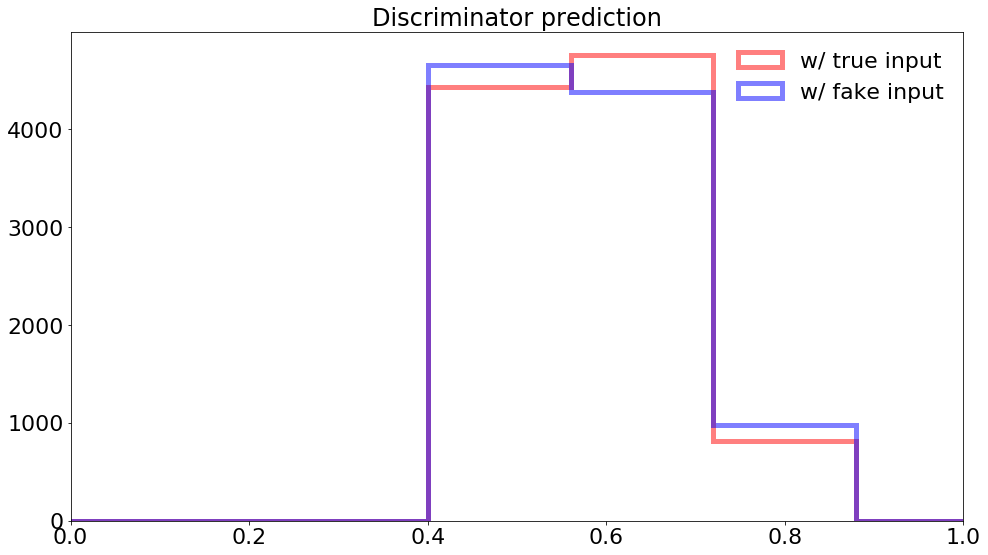

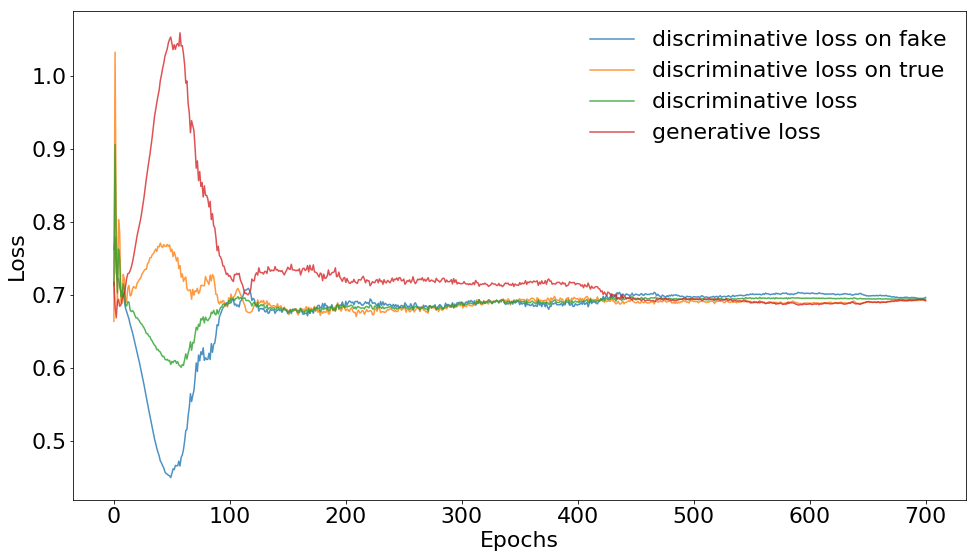

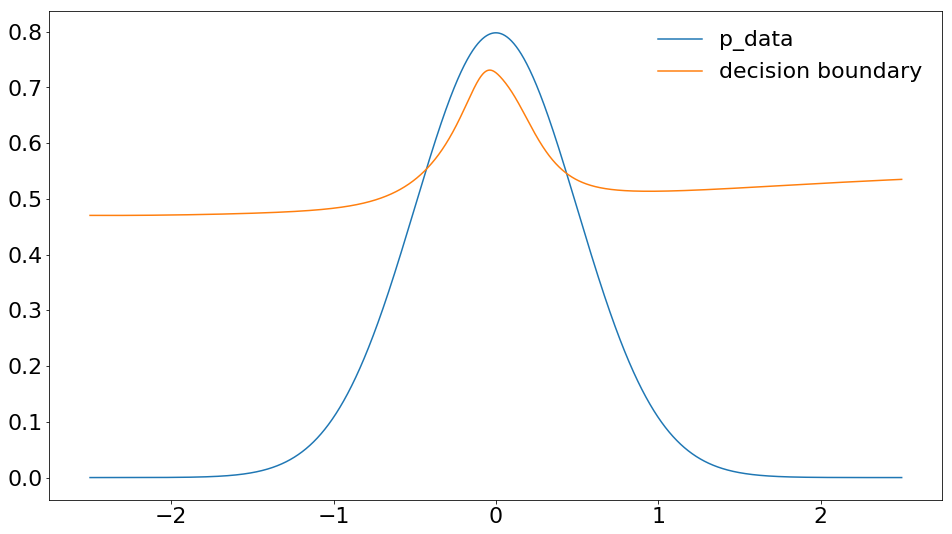

Epoch 751, Discriminator loss:0.694459676743, GAN loss:0.695001006126
For true: mean and s.d. =  -0.00132891998978 0.495726790378
For generator: mean and s.d. =  -0.000152588 0.506528


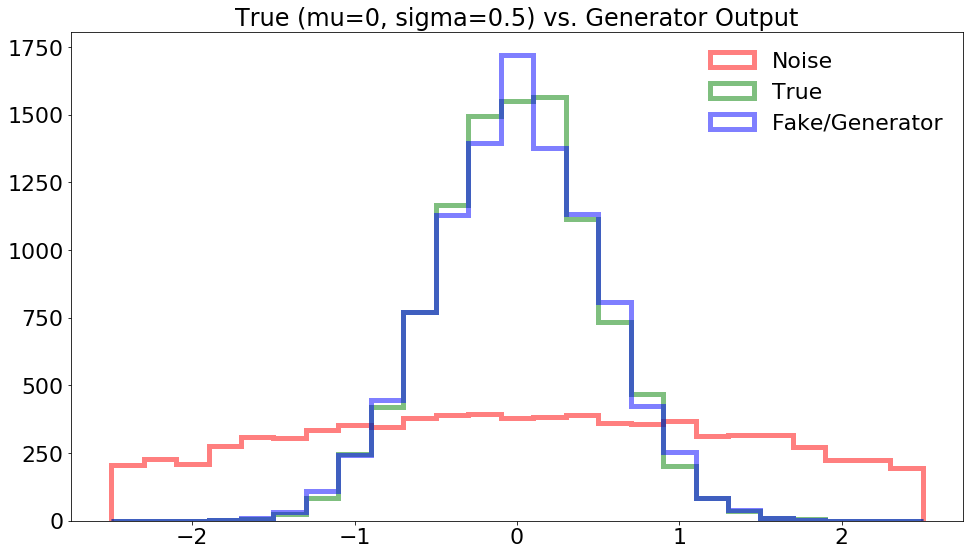

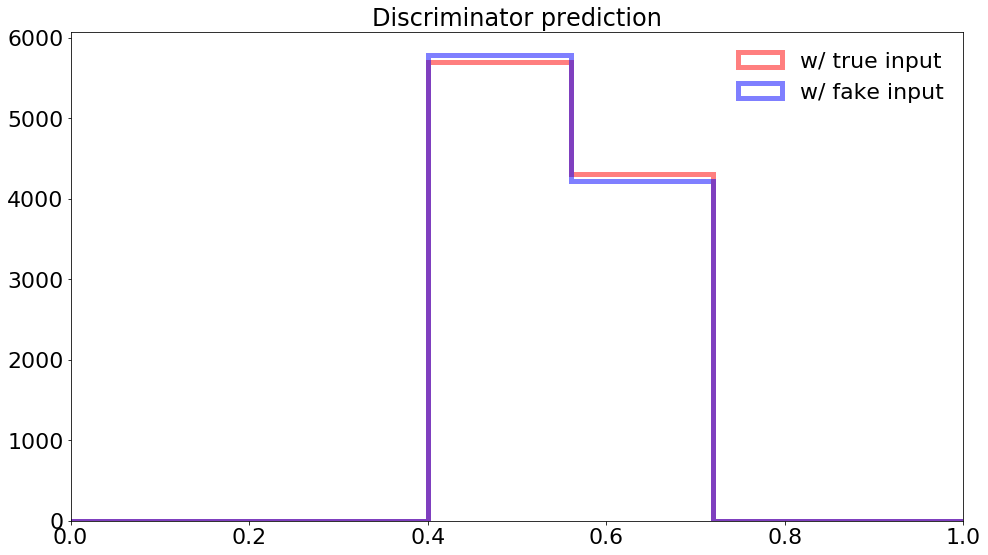

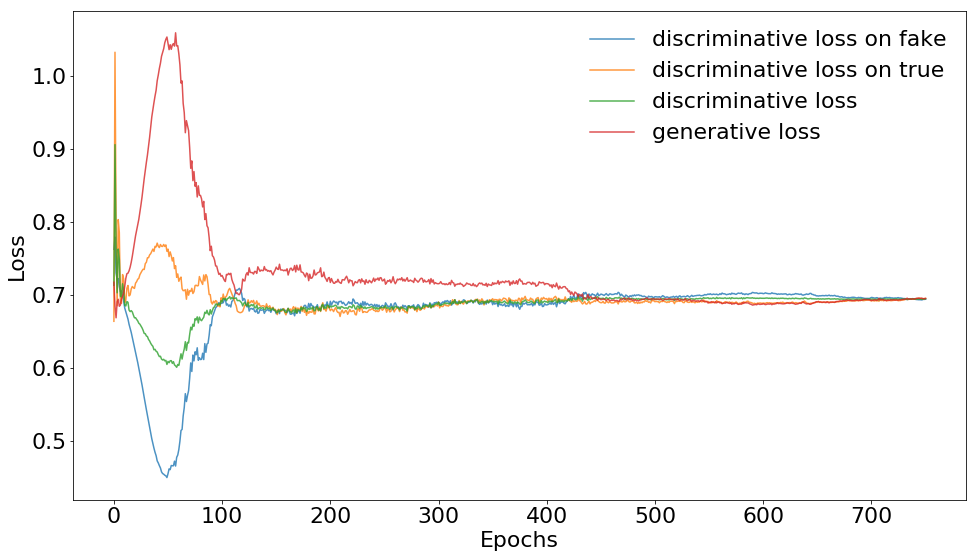

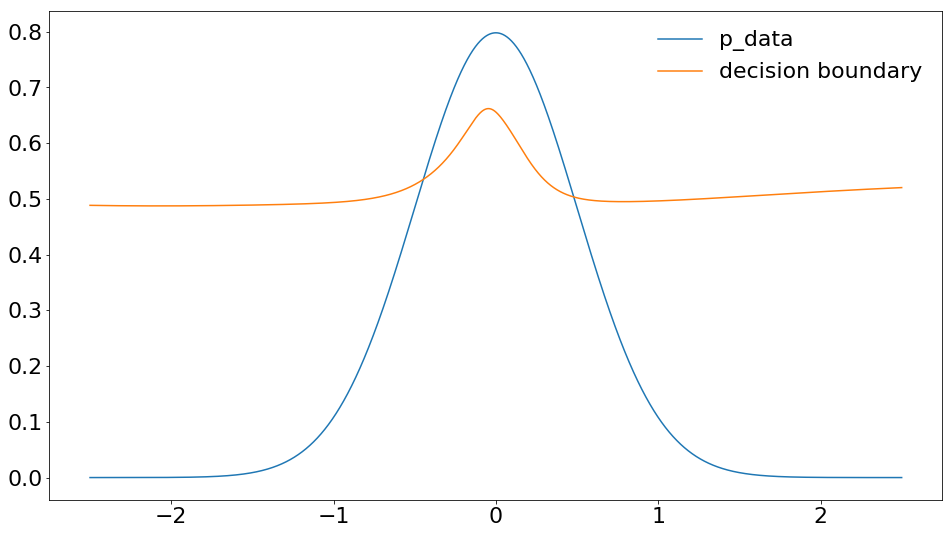

Epoch 801, Discriminator loss:0.694248974323, GAN loss:0.694518327713
For true: mean and s.d. =  -0.00228249502731 0.502284649873
For generator: mean and s.d. =  0.0129951 0.478191


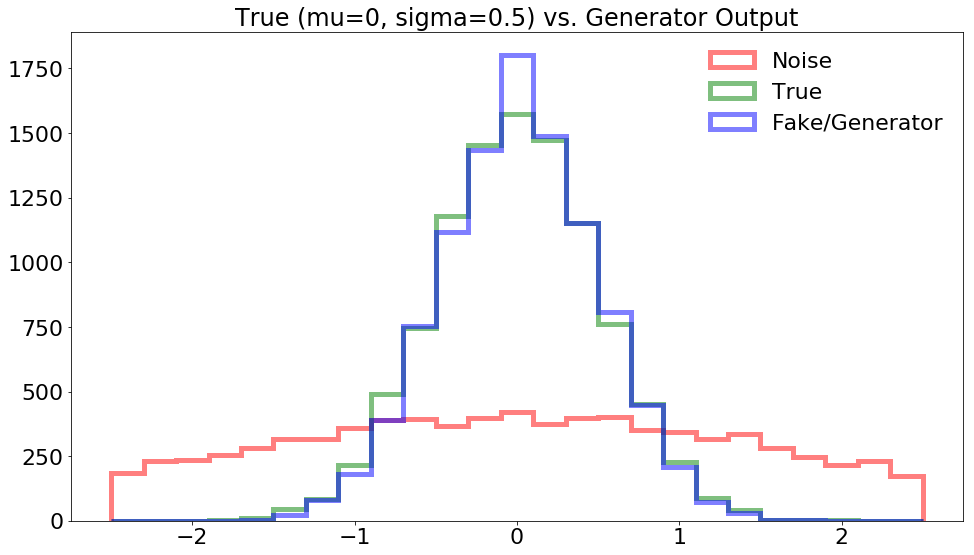

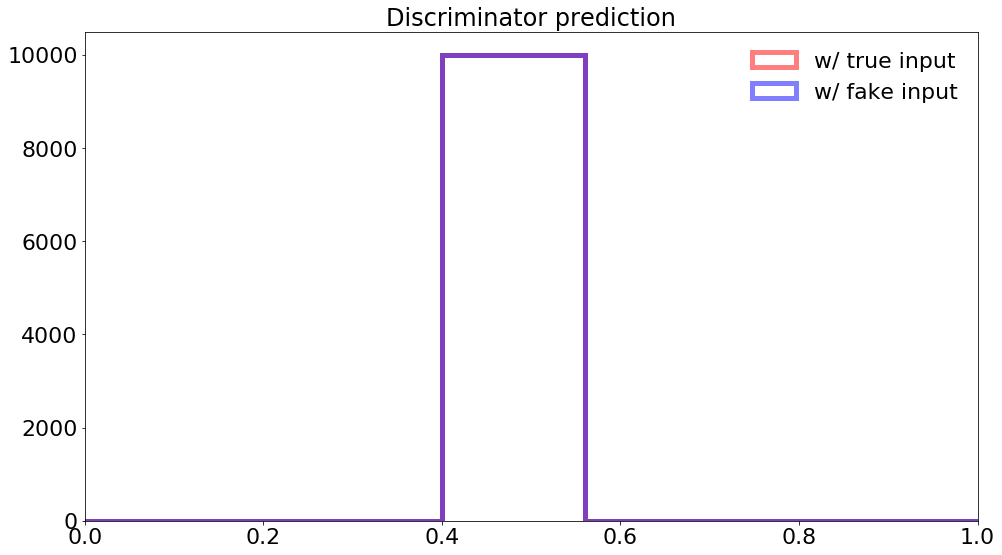

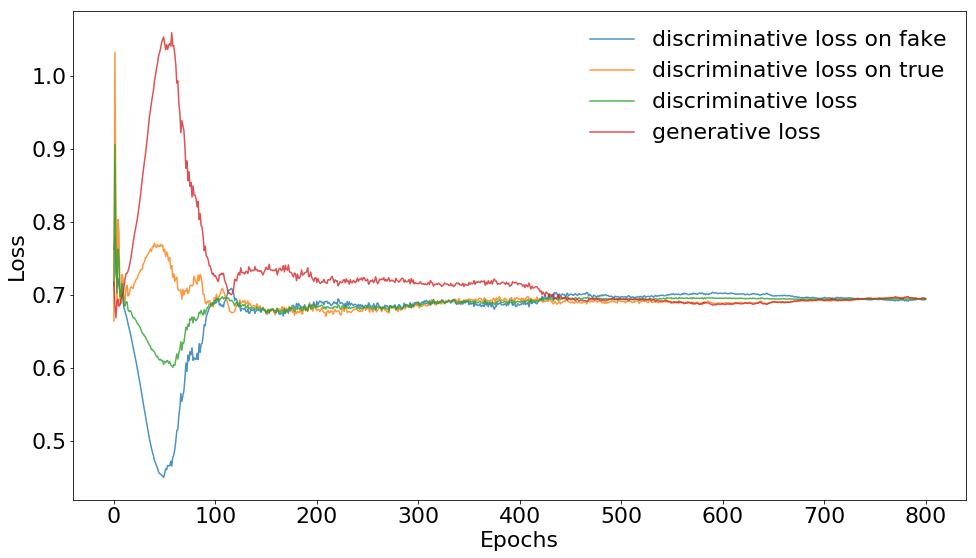

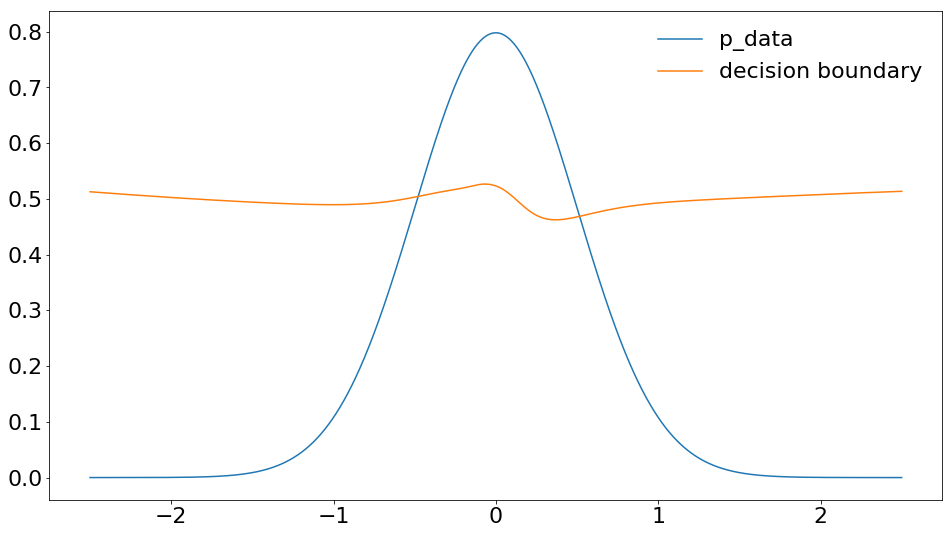

Epoch 851, Discriminator loss:0.693331301212, GAN loss:0.69215130806
For true: mean and s.d. =  -0.011126417238 0.506630501453
For generator: mean and s.d. =  0.0165687 0.482214


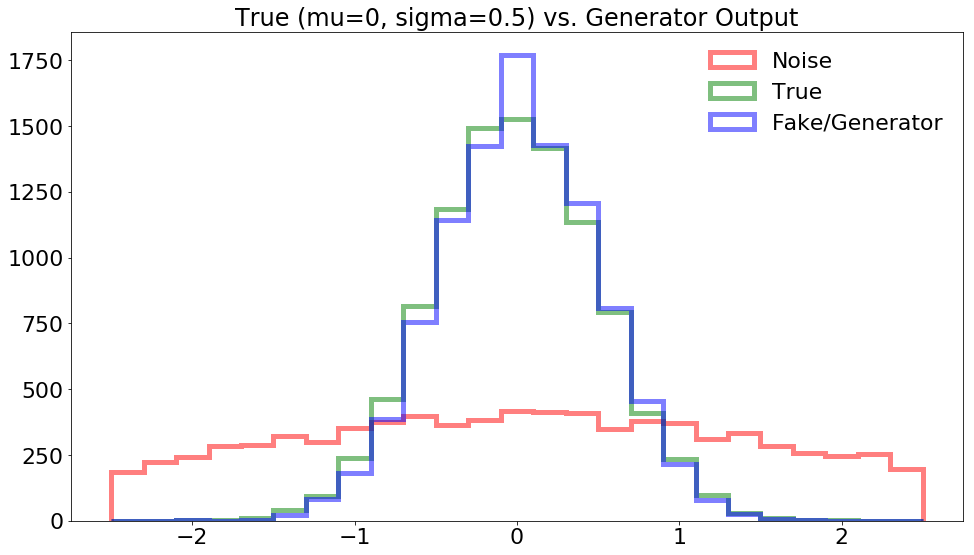

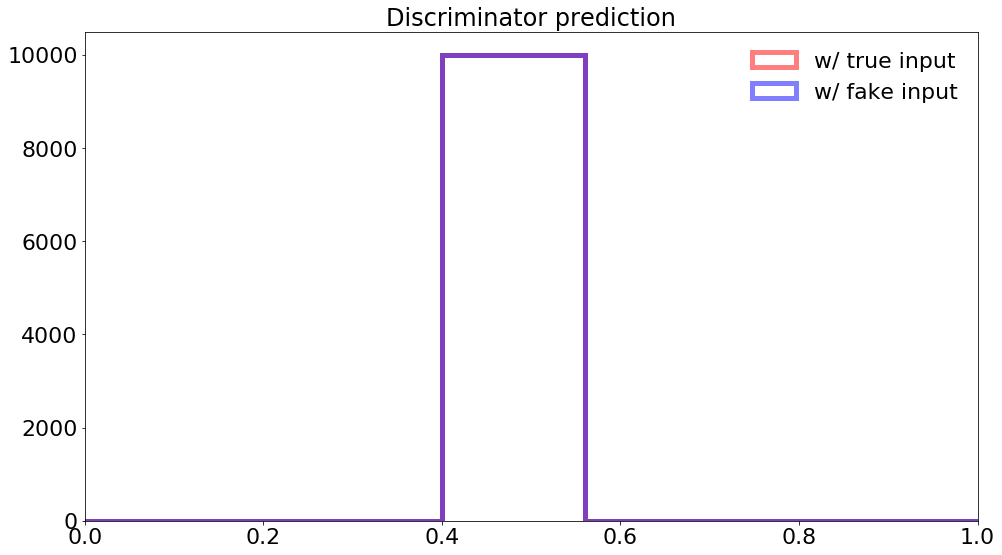

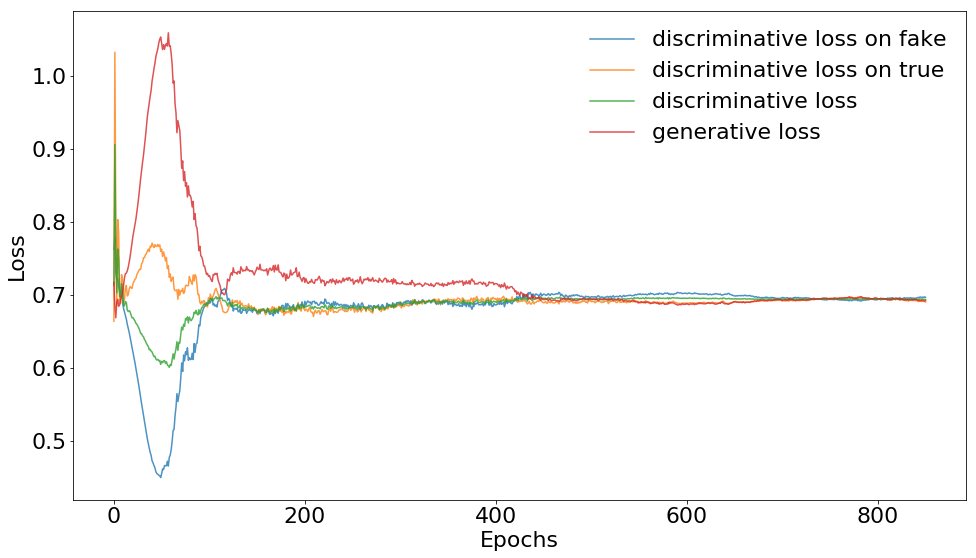

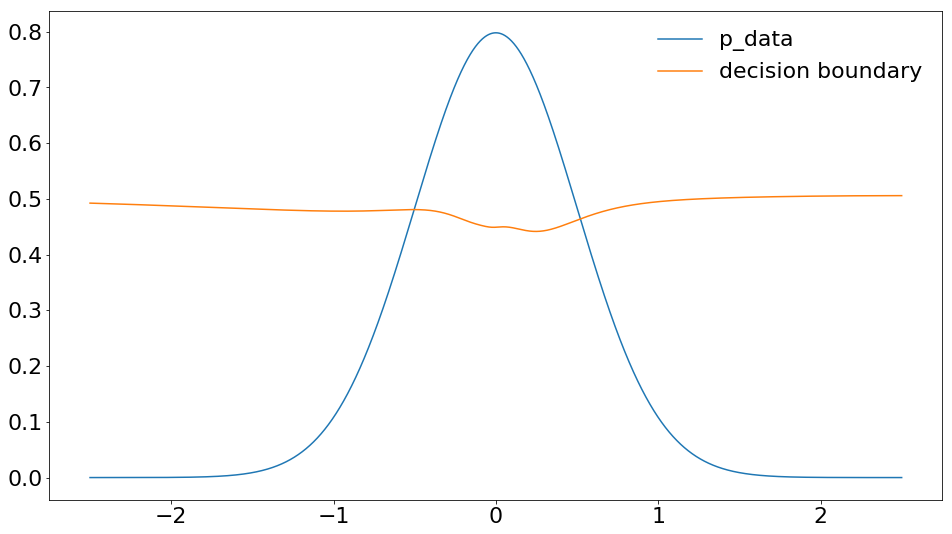

Epoch 901, Discriminator loss:0.694176435471, GAN loss:0.688324272633
For true: mean and s.d. =  0.00964982043584 0.495555368364
For generator: mean and s.d. =  0.0318856 0.514169


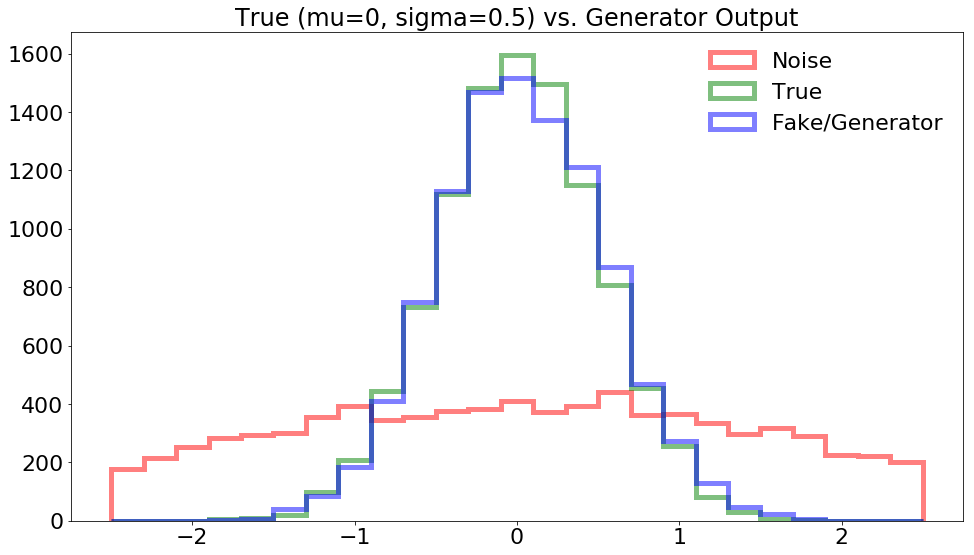

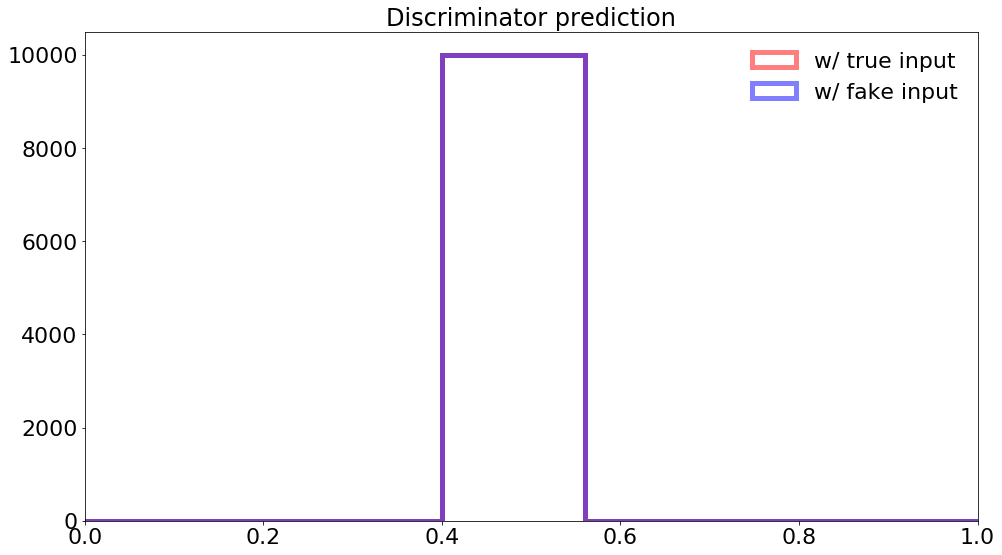

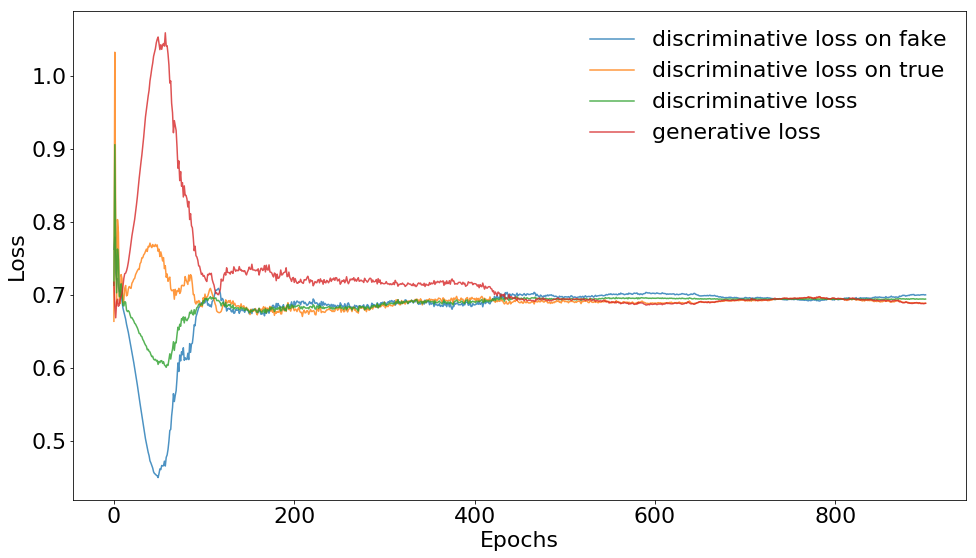

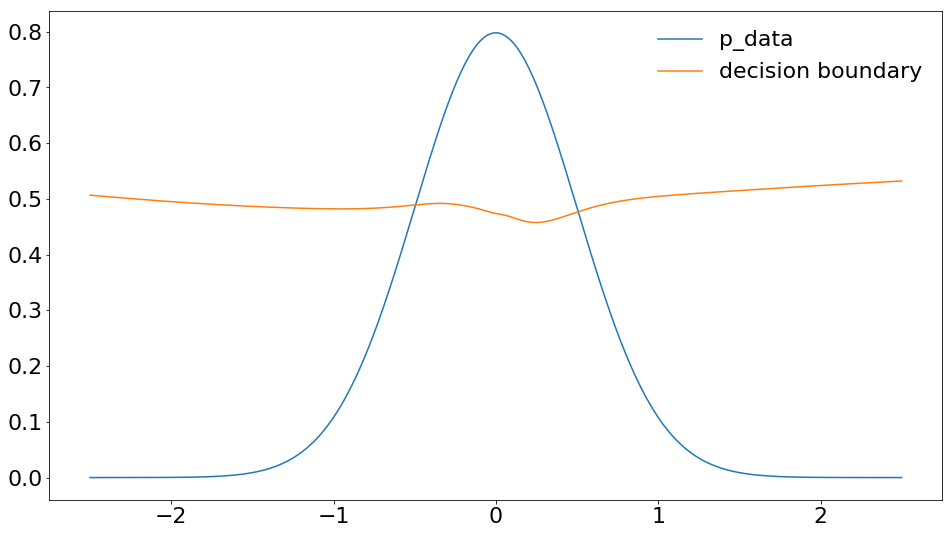

Epoch 951, Discriminator loss:0.694223821163, GAN loss:0.689678668976
For true: mean and s.d. =  -0.00616995944031 0.495397902799
For generator: mean and s.d. =  0.0341822 0.504089


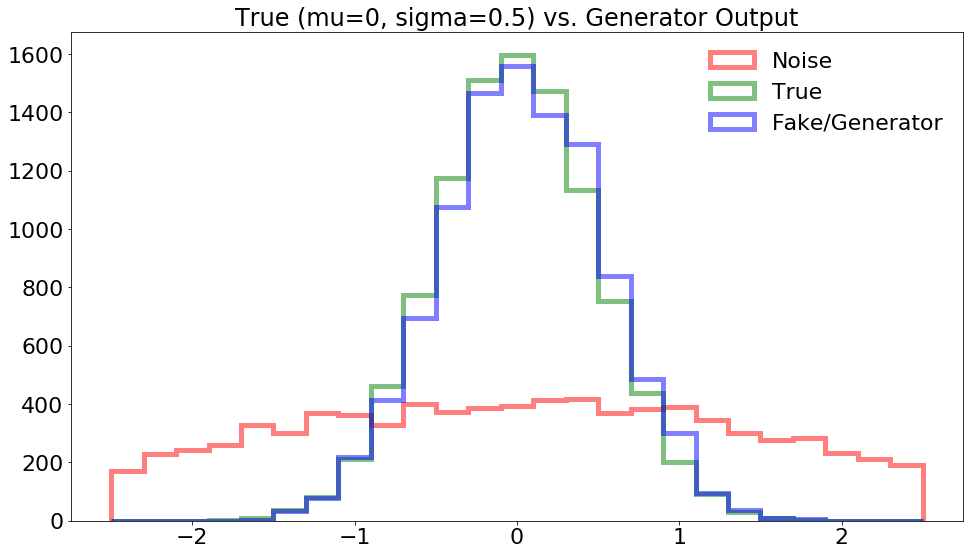

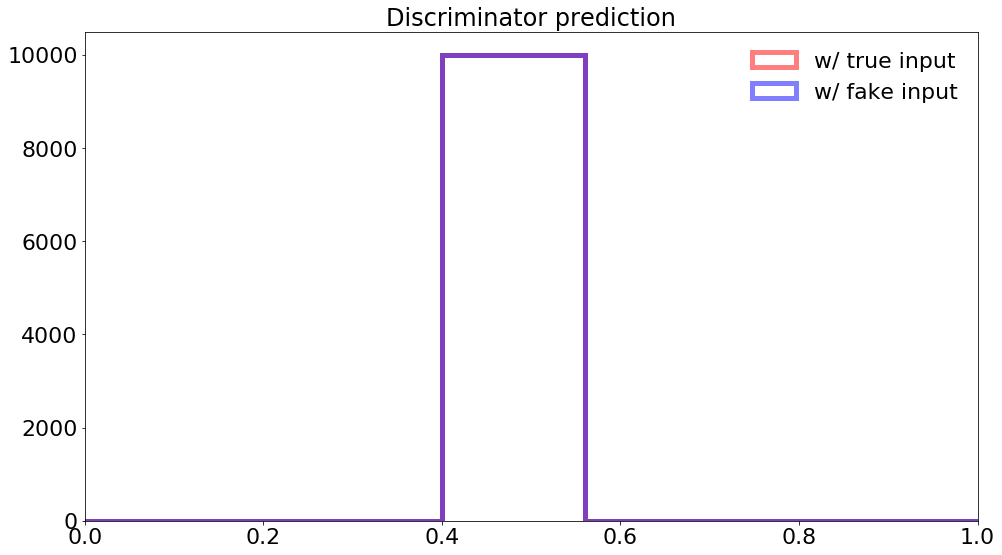

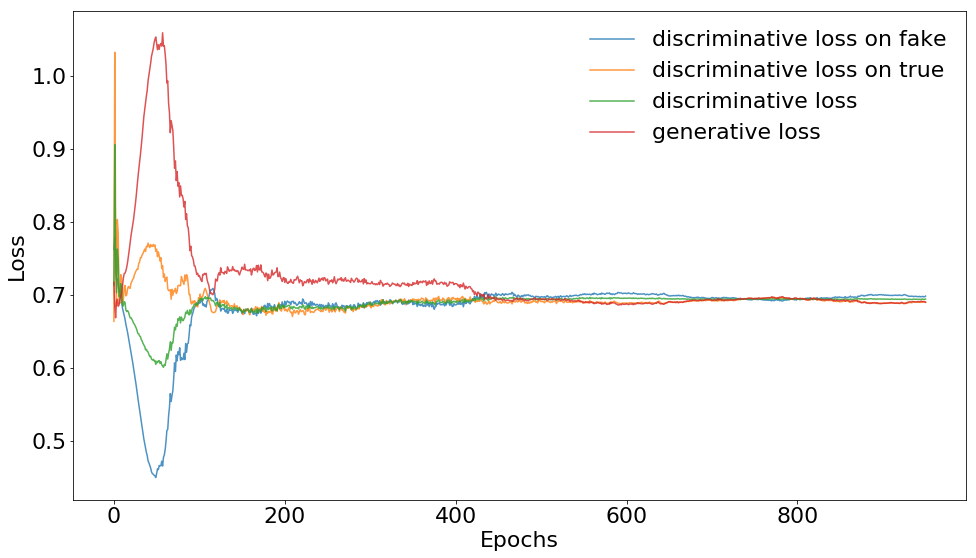

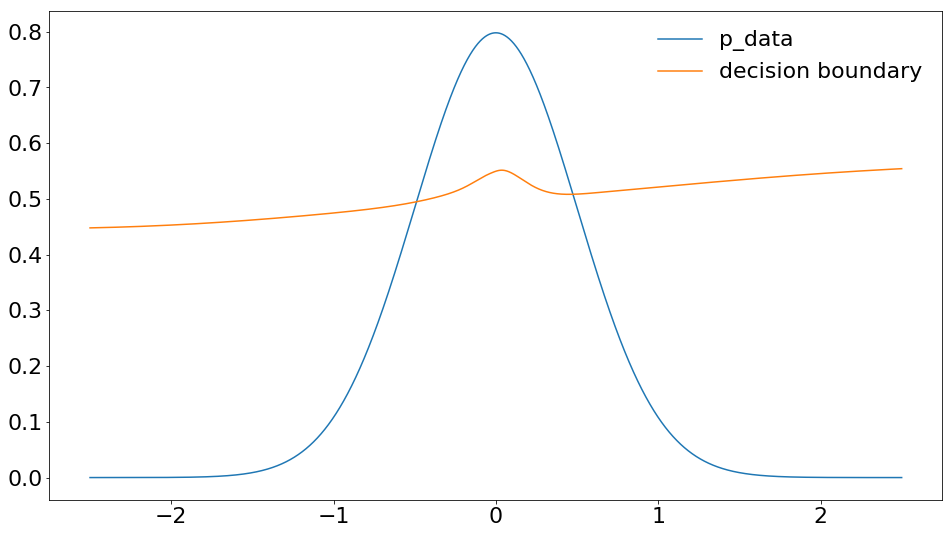

Epoch 1001, Discriminator loss:0.694208502769, GAN loss:0.692909061909
For true: mean and s.d. =  0.00225312769524 0.495852444897
For generator: mean and s.d. =  0.0358635 0.483578


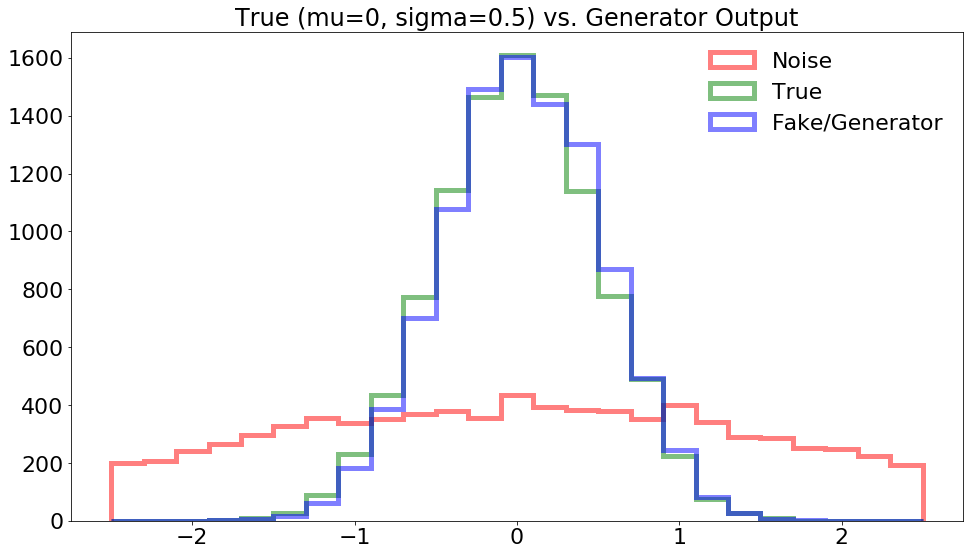

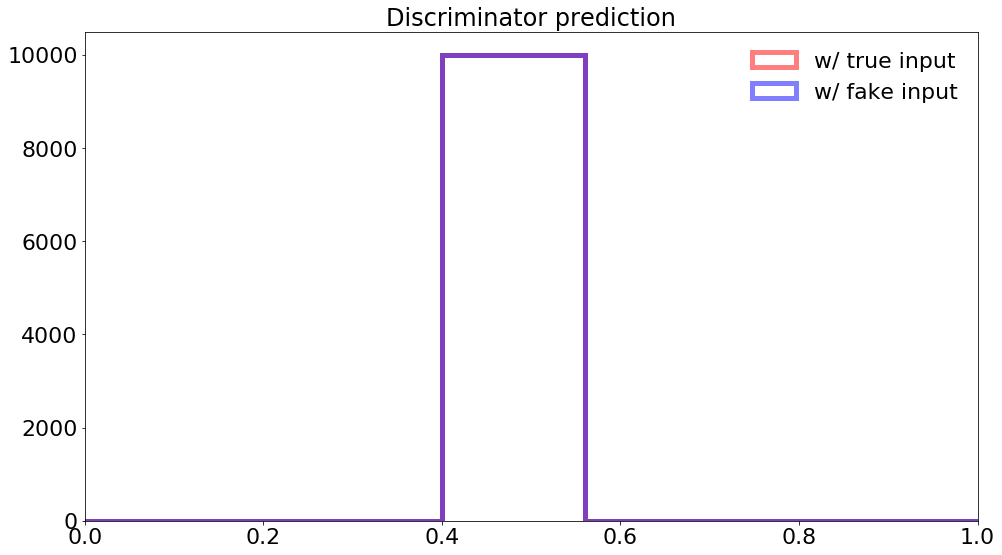

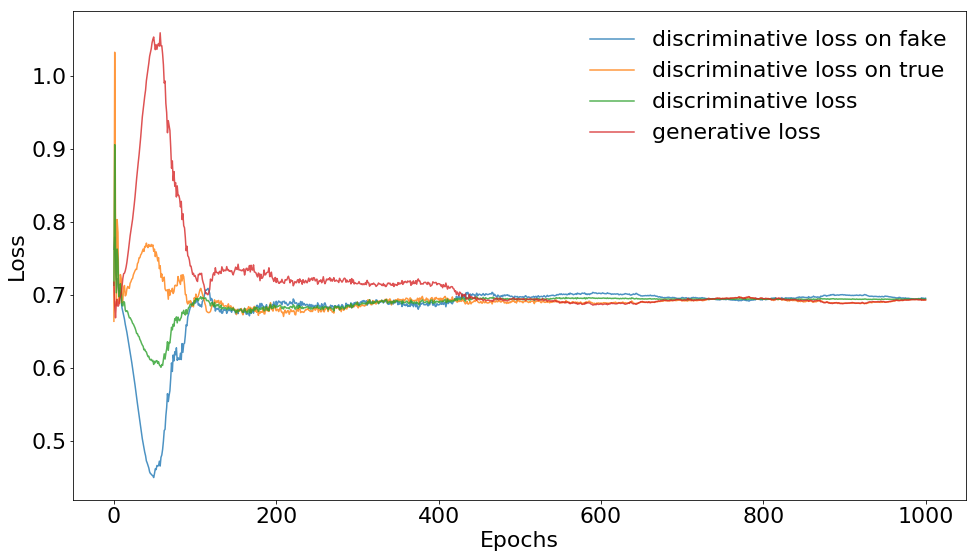

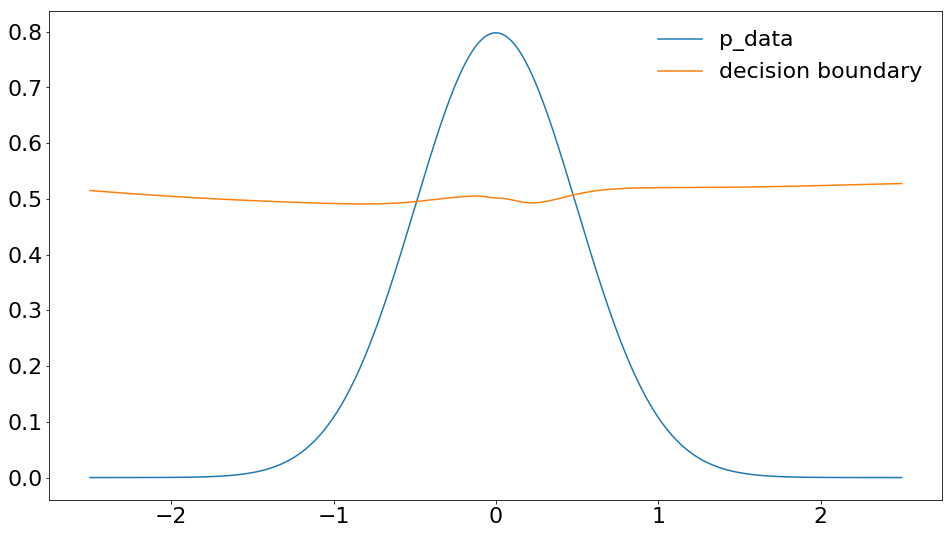

Epoch 1051, Discriminator loss:0.693759679794, GAN loss:0.690445125103
For true: mean and s.d. =  0.00190612420432 0.501979017031
For generator: mean and s.d. =  0.0428192 0.480085


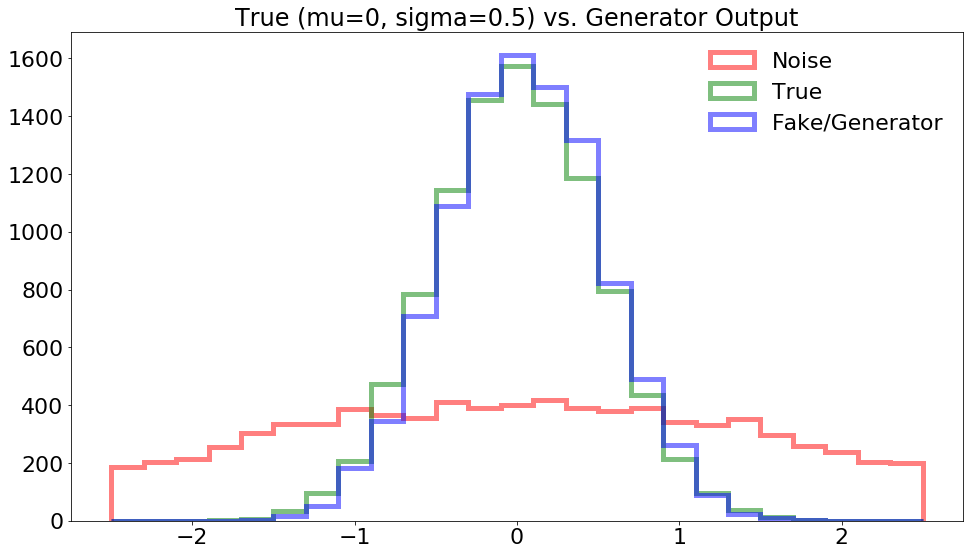

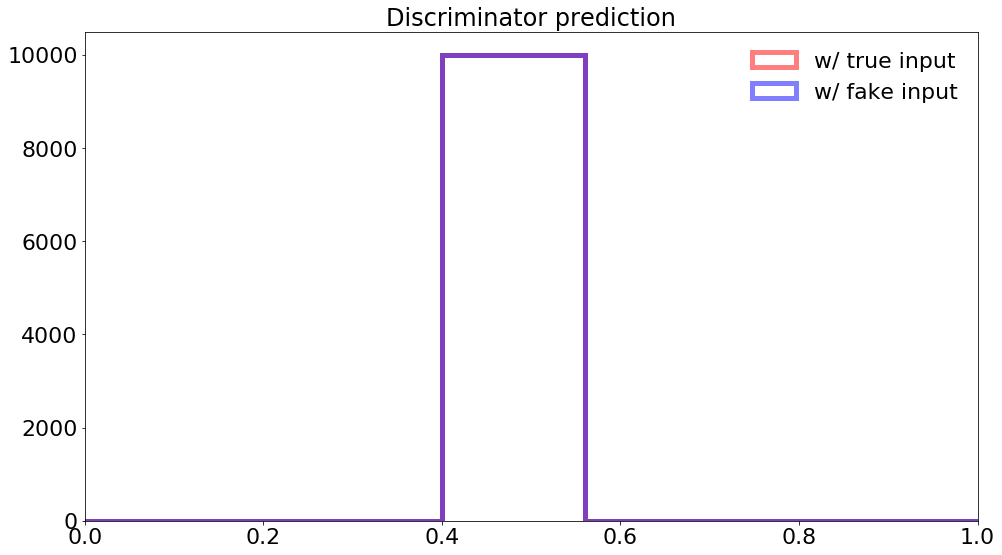

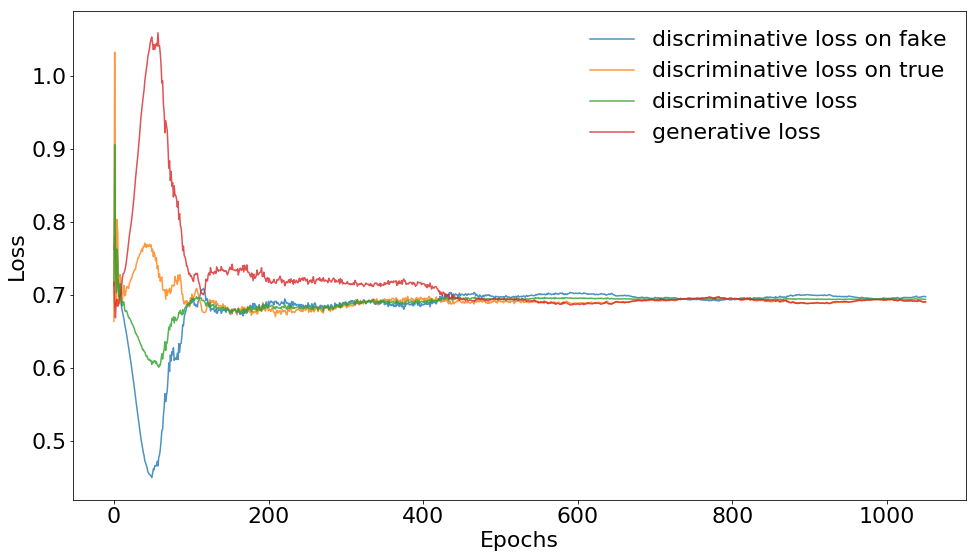

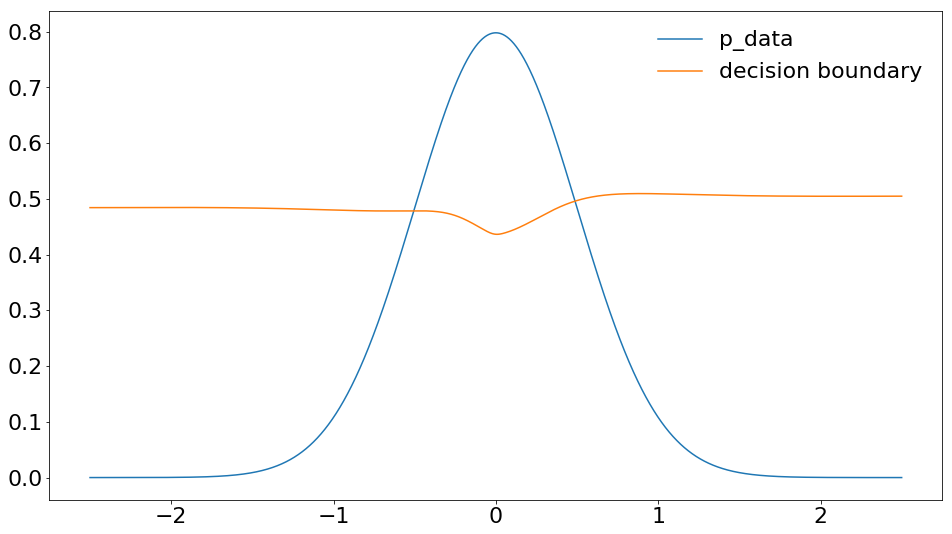

Epoch 1101, Discriminator loss:0.69368326664, GAN loss:0.690314173698
For true: mean and s.d. =  -0.0107517315536 0.49911272832
For generator: mean and s.d. =  0.0450092 0.517938


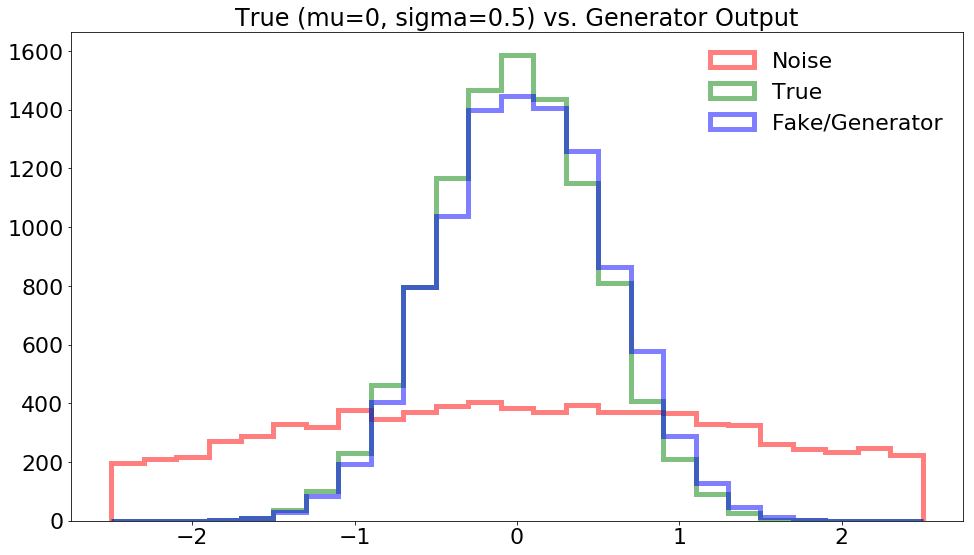

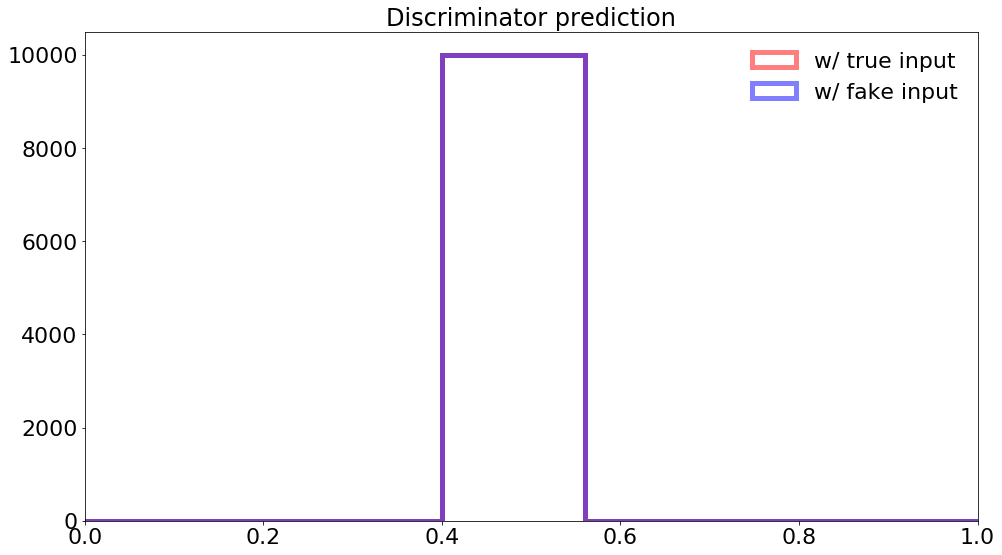

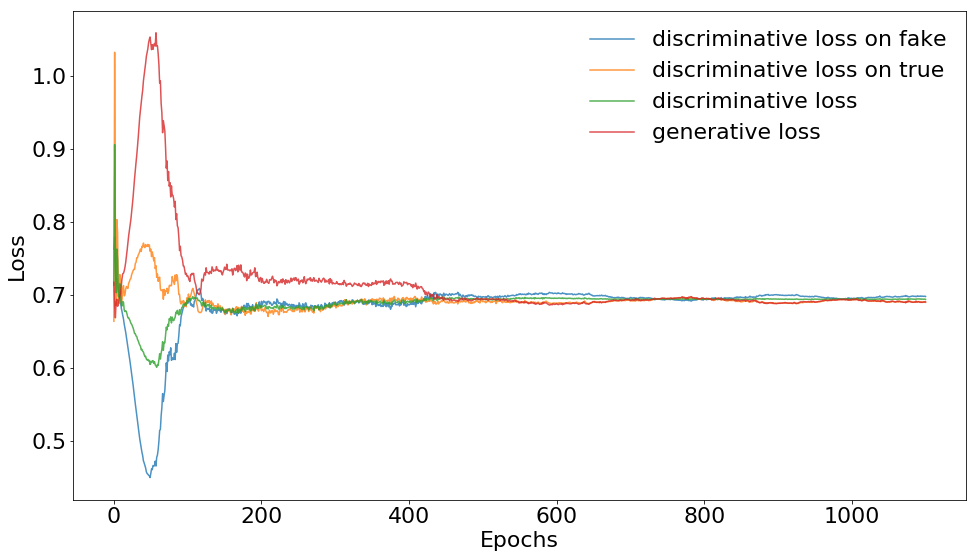

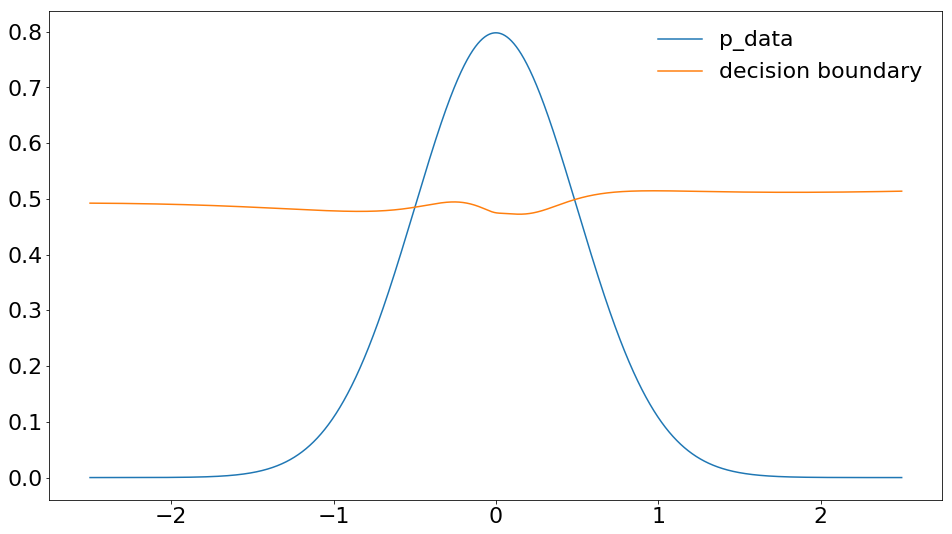

Epoch 1151, Discriminator loss:0.693876028061, GAN loss:0.692021965981
For true: mean and s.d. =  -0.0041541341539 0.498463249702
For generator: mean and s.d. =  0.0552698 0.526467


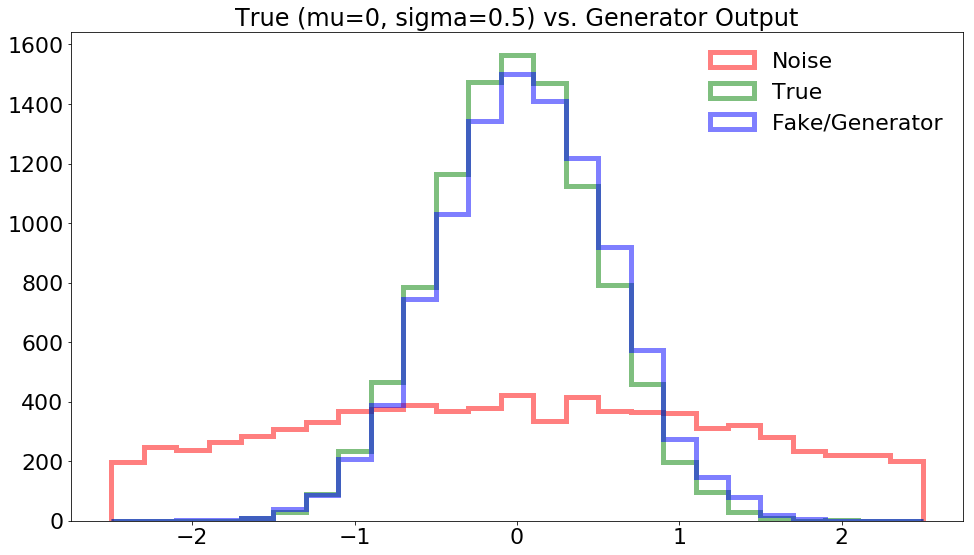

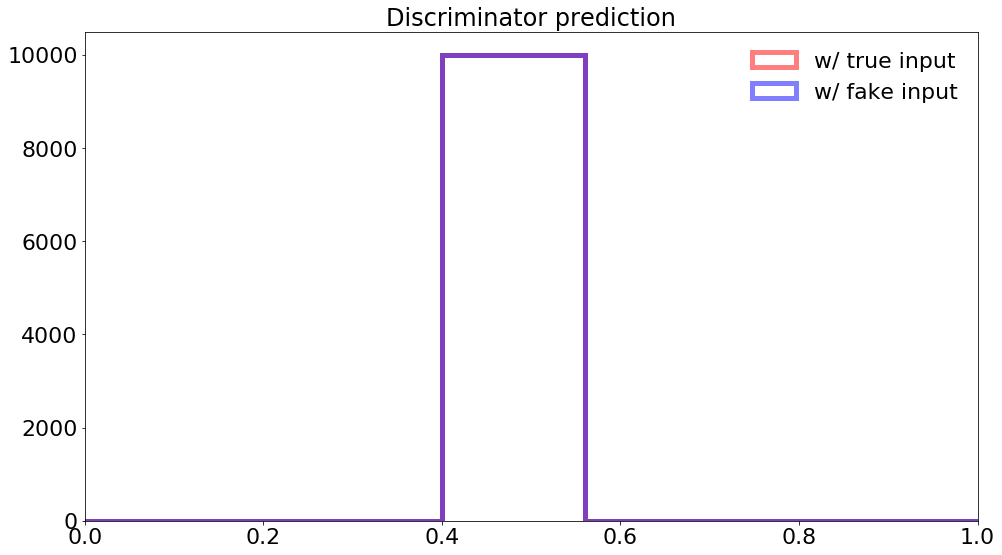

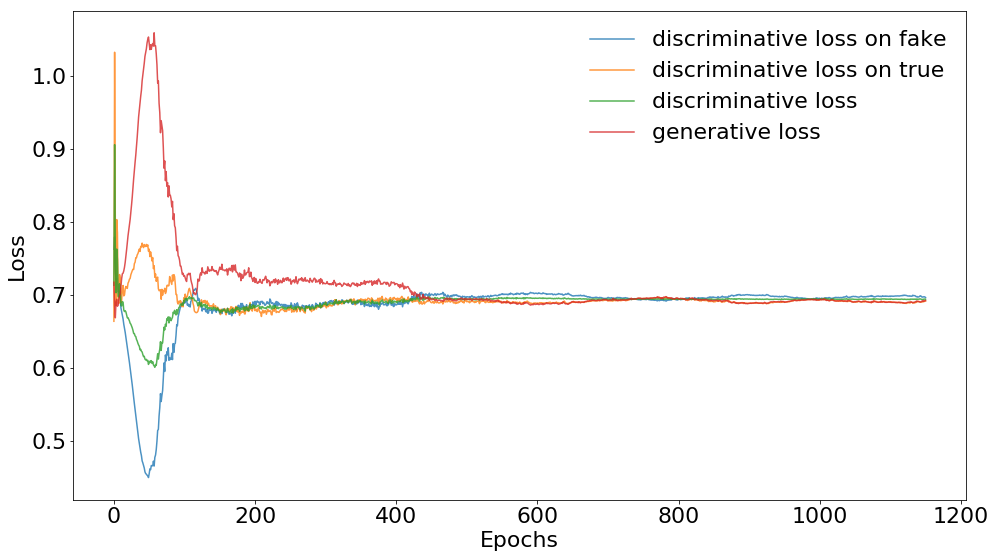

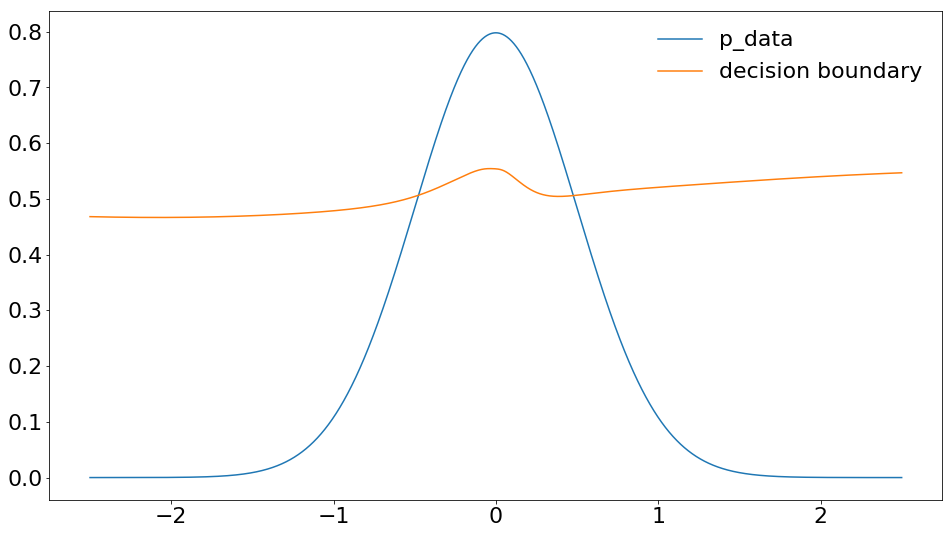

Epoch 1201, Discriminator loss:0.694162607193, GAN loss:0.693919420242
For true: mean and s.d. =  -0.00480591677436 0.499384971201
For generator: mean and s.d. =  0.0455271 0.488483


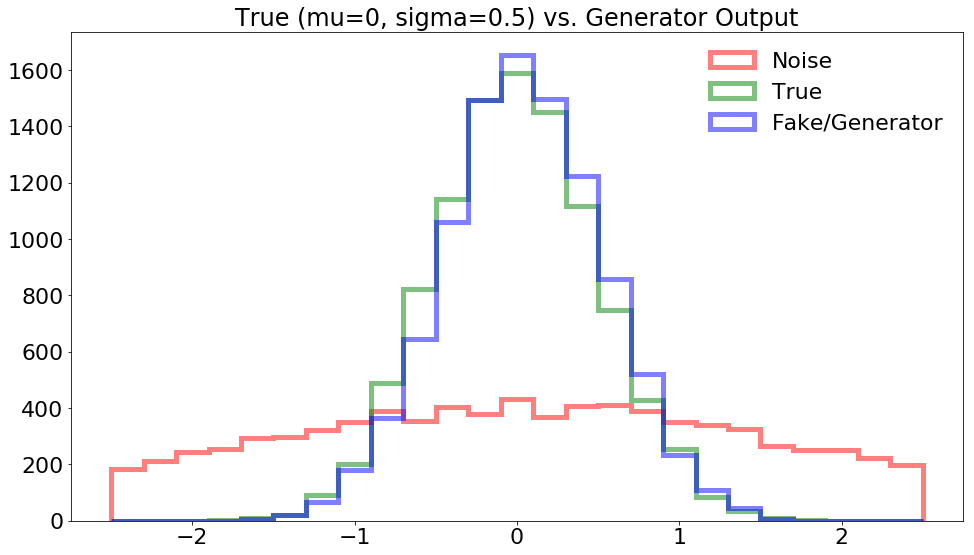

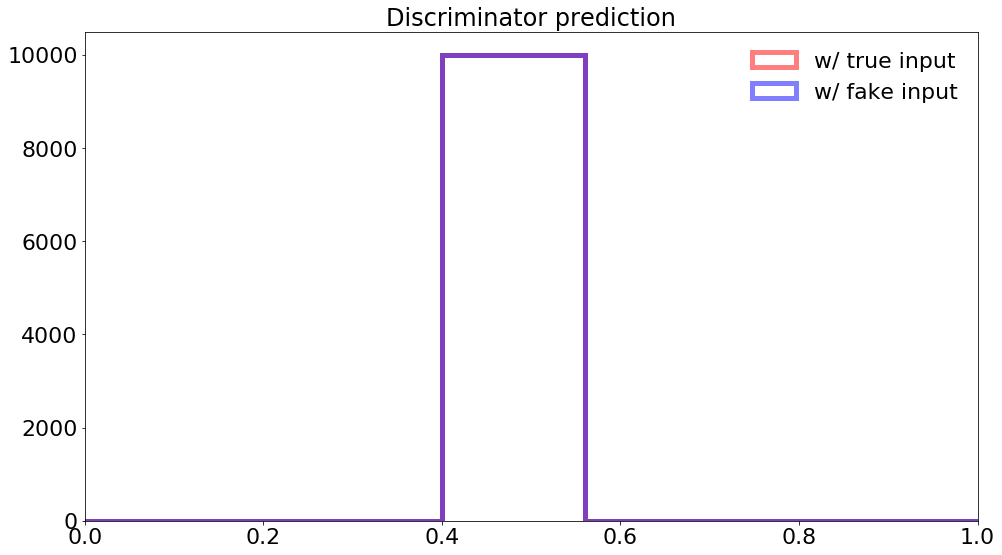

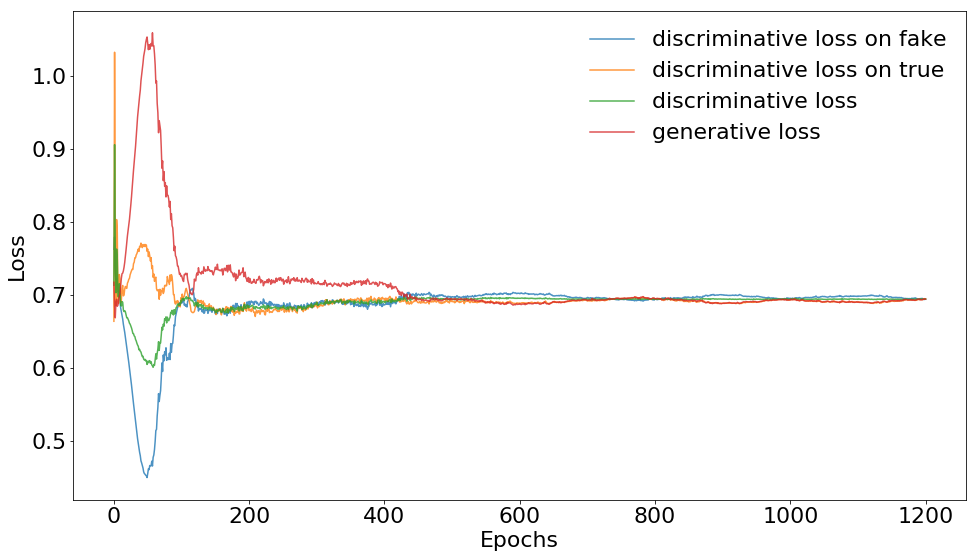

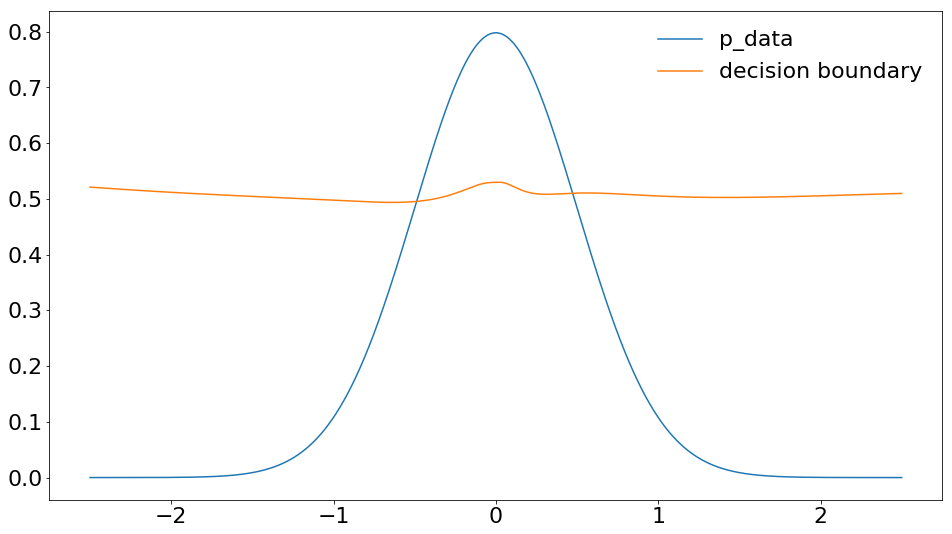

Epoch 1251, Discriminator loss:0.69452804327, GAN loss:0.691836953163
For true: mean and s.d. =  -0.010163172776 0.506547938517
For generator: mean and s.d. =  0.0434206 0.481744


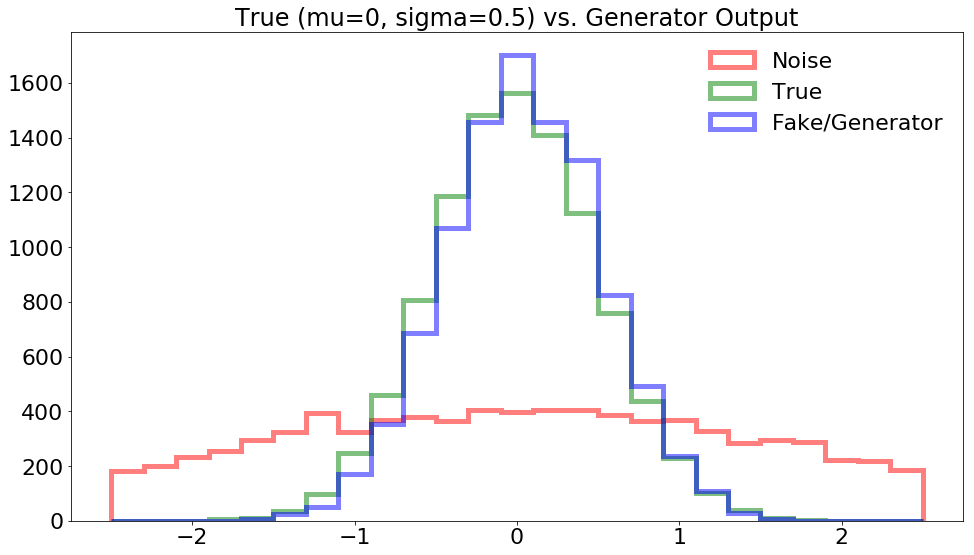

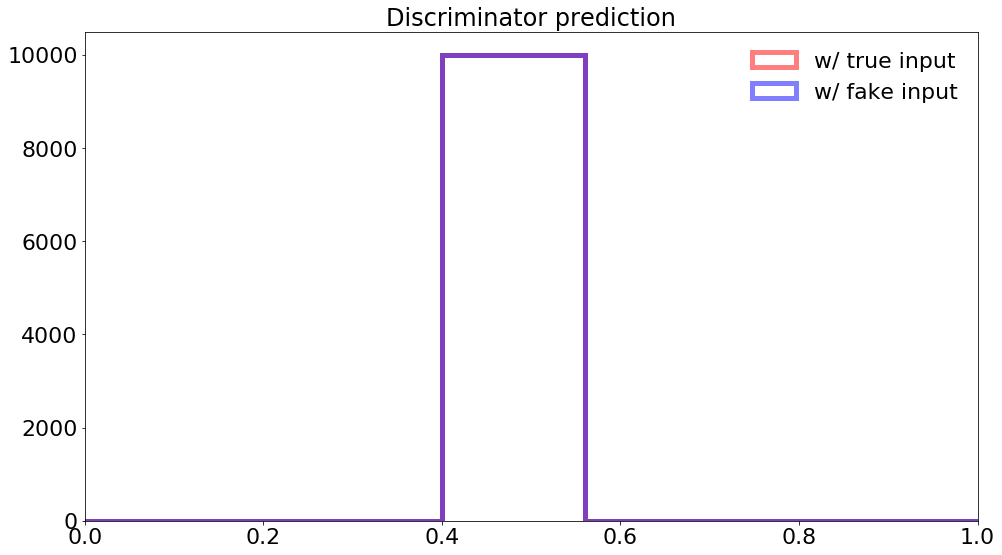

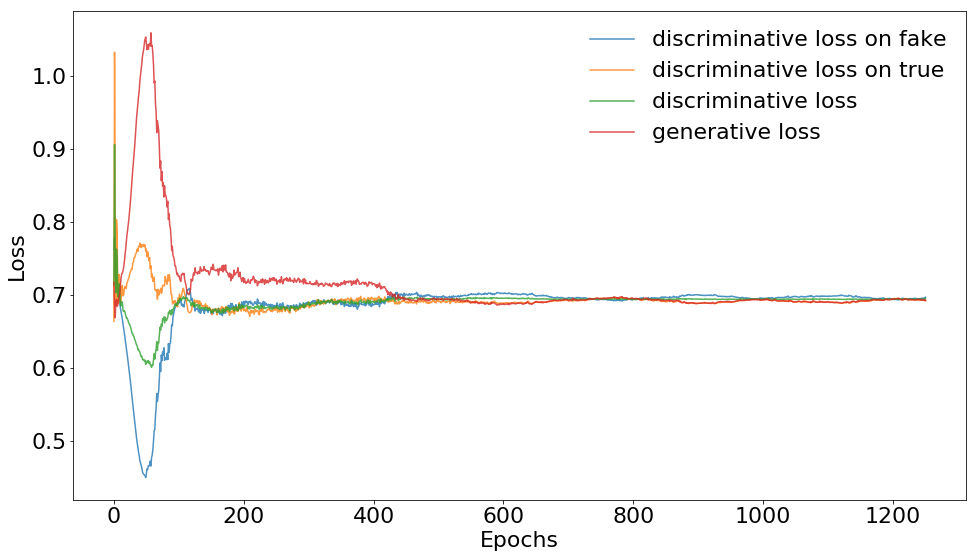

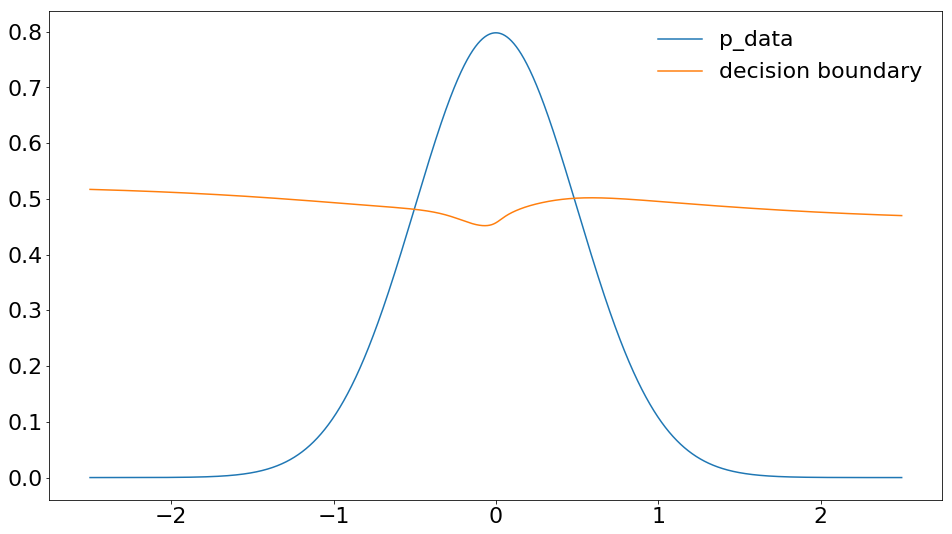

Epoch 1301, Discriminator loss:0.694061636925, GAN loss:0.690209209919
For true: mean and s.d. =  -6.027472346e-05 0.496346818931
For generator: mean and s.d. =  0.0438961 0.513233


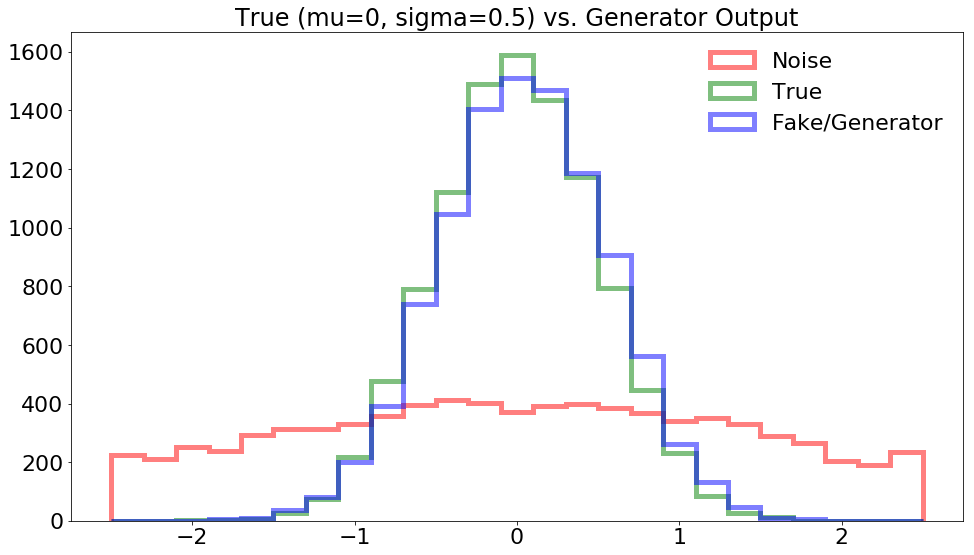

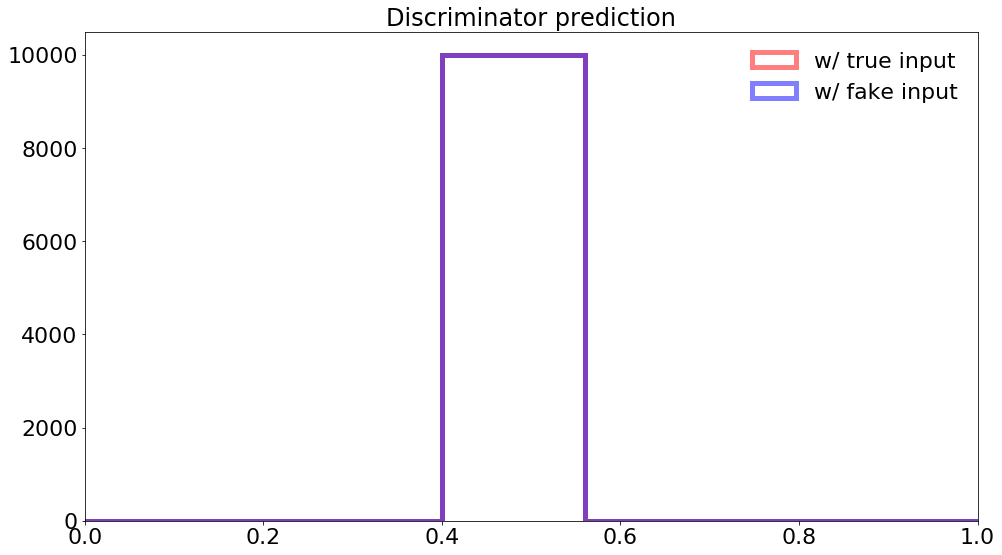

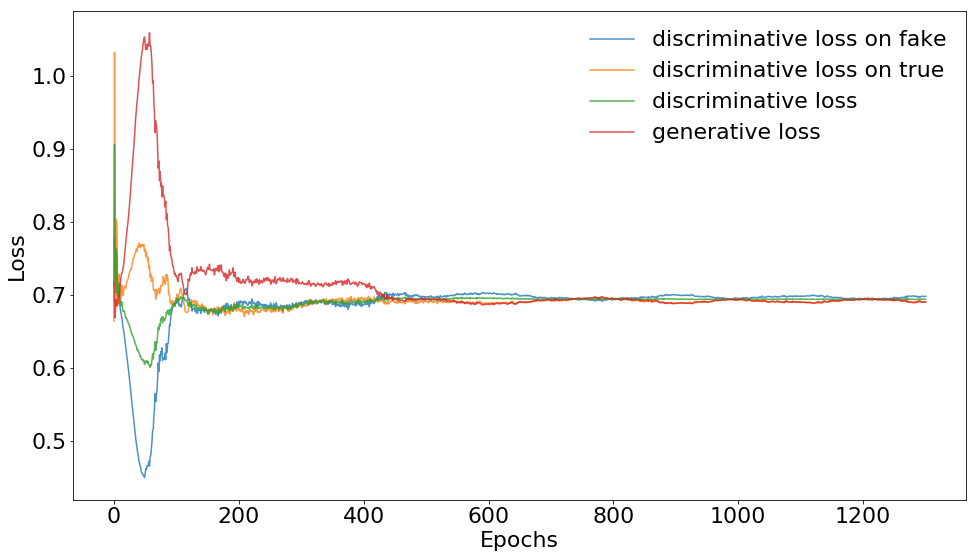

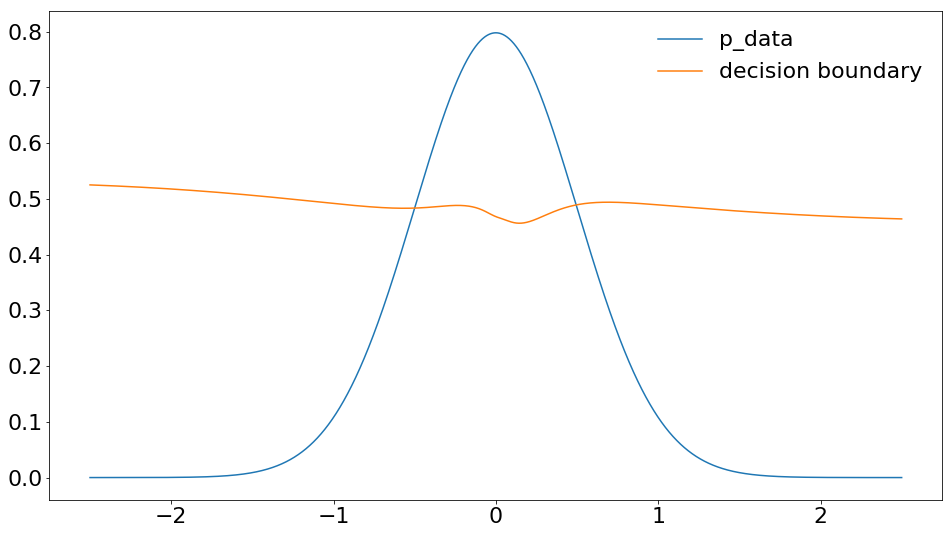

Epoch 1351, Discriminator loss:0.693669557571, GAN loss:0.689307451248
For true: mean and s.d. =  -0.00657293836207 0.498072625075
For generator: mean and s.d. =  0.0546161 0.52488


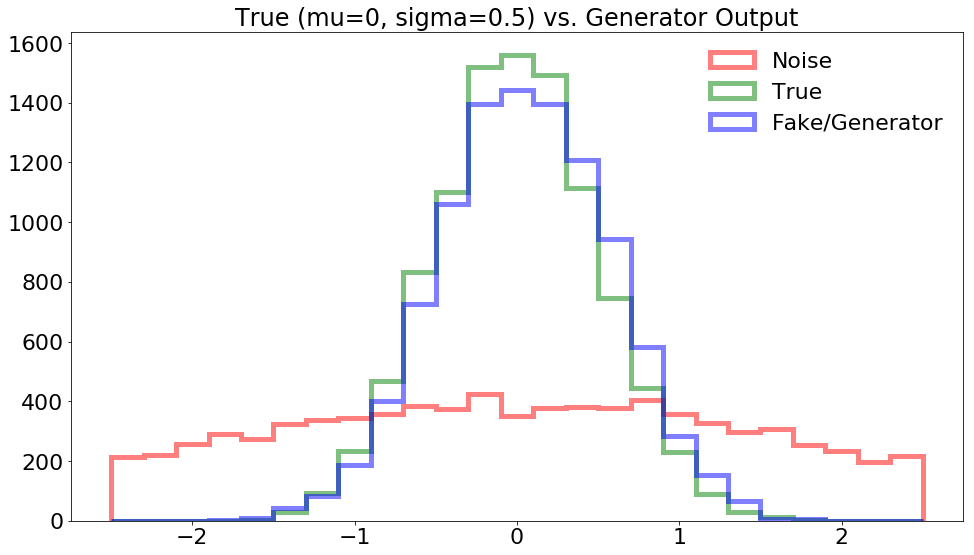

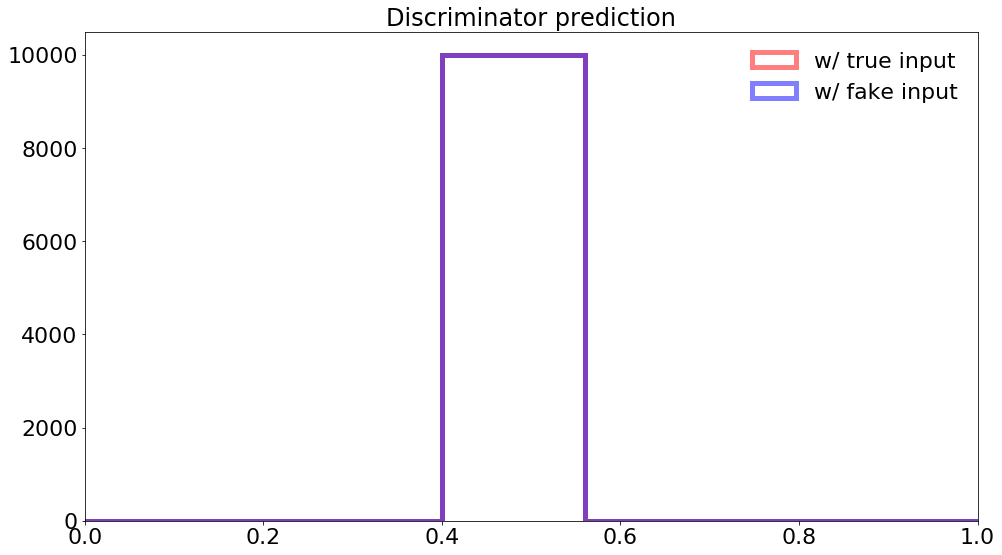

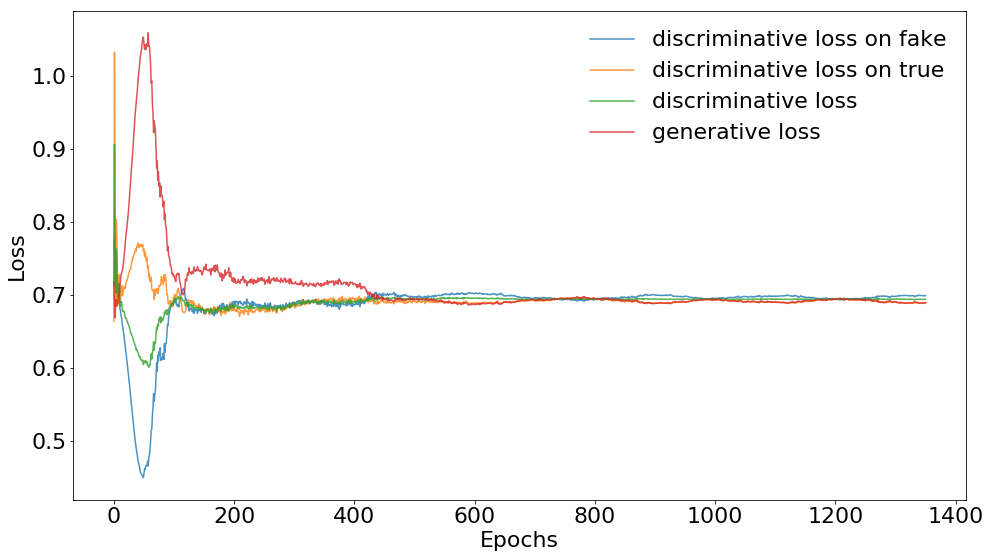

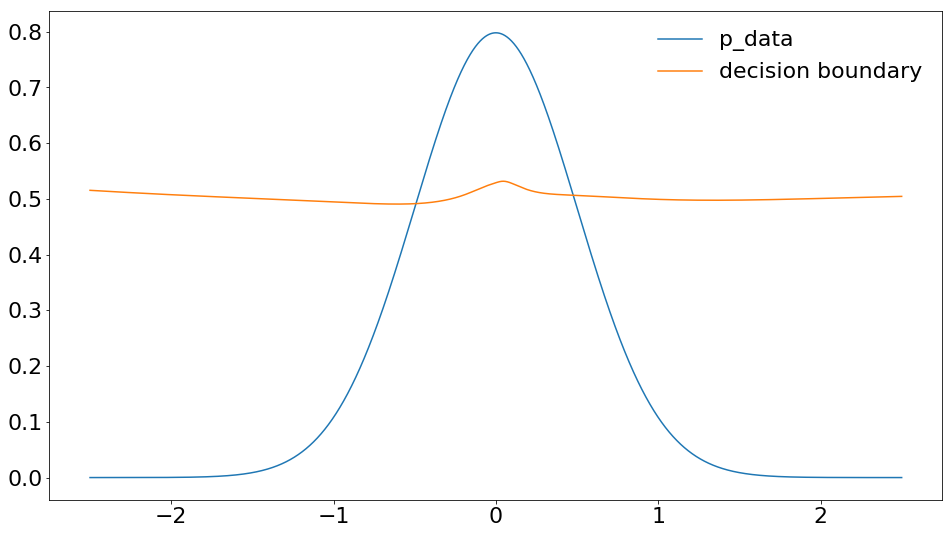

Epoch 1401, Discriminator loss:0.693958878517, GAN loss:0.692311942577
For true: mean and s.d. =  0.00529232908925 0.505870600912
For generator: mean and s.d. =  0.035584 0.500794


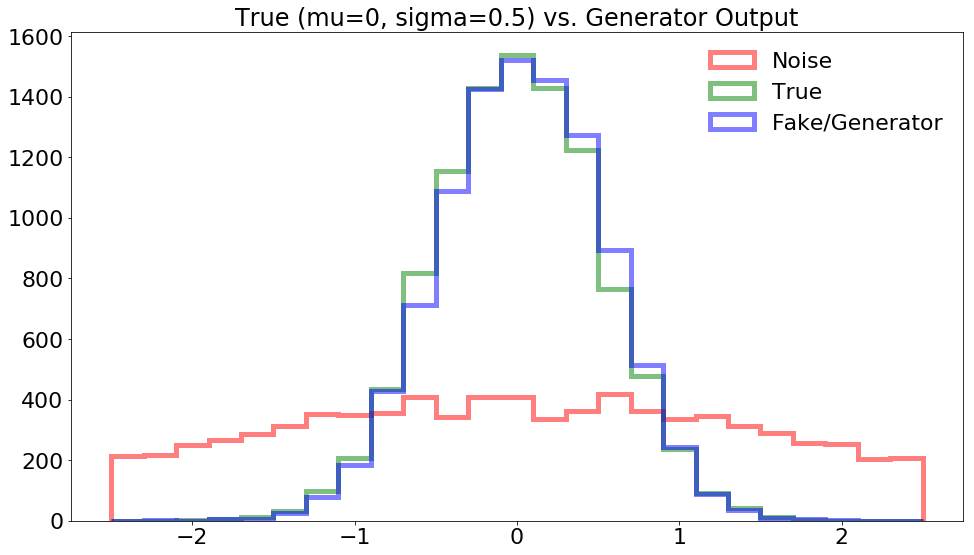

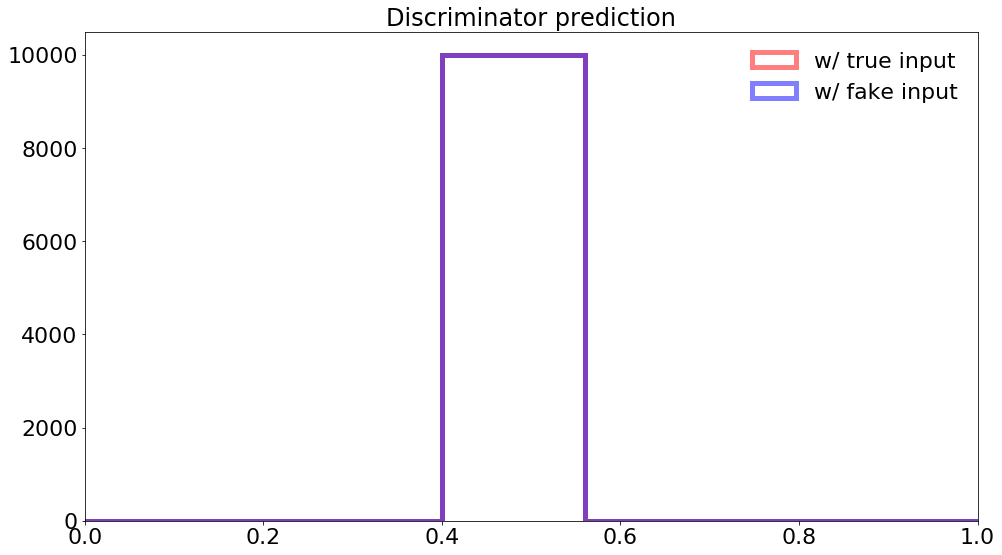

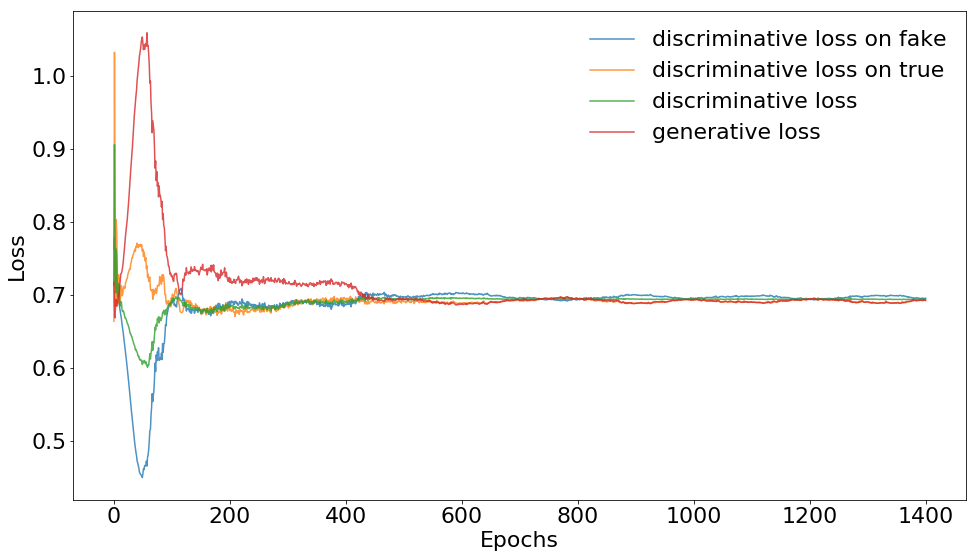

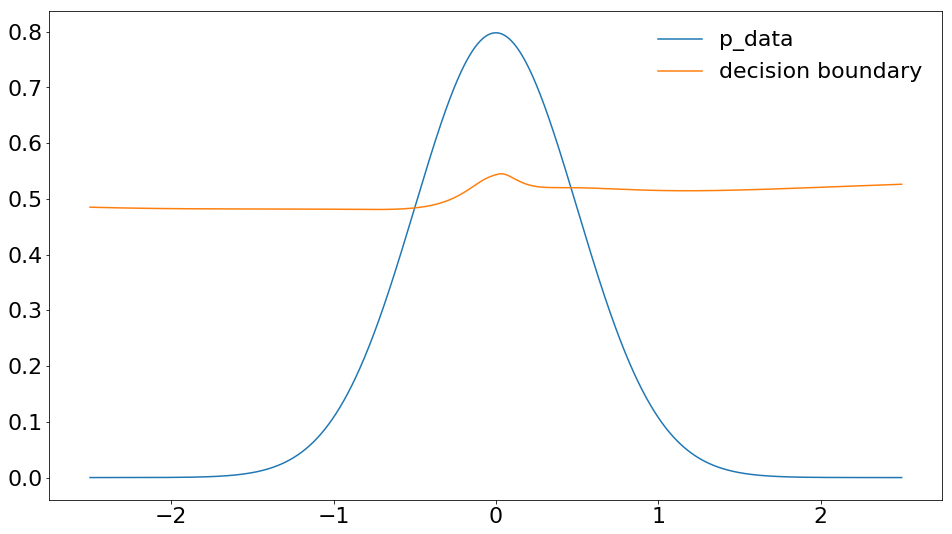

Epoch 1451, Discriminator loss:0.693801522255, GAN loss:0.692922830582
For true: mean and s.d. =  0.00770293530831 0.498277468215
For generator: mean and s.d. =  0.0331485 0.480697


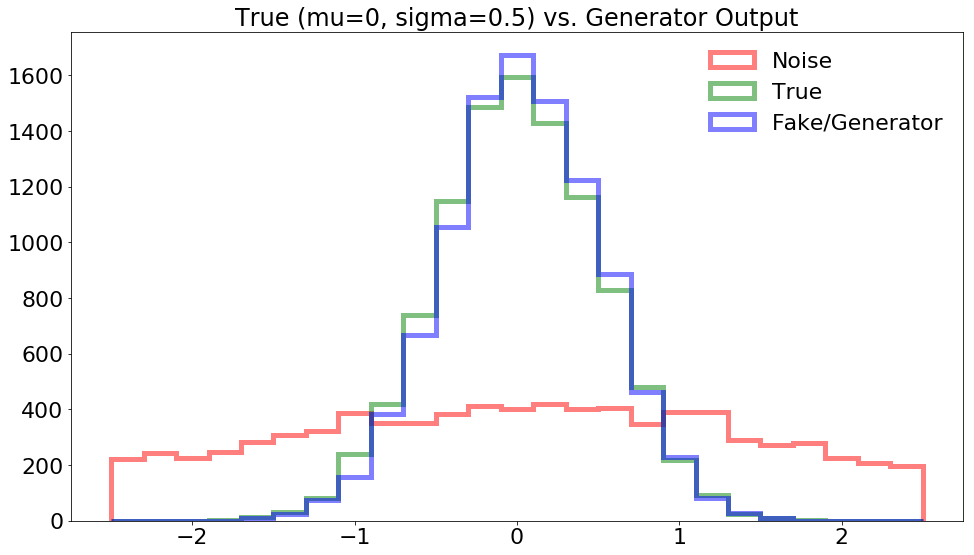

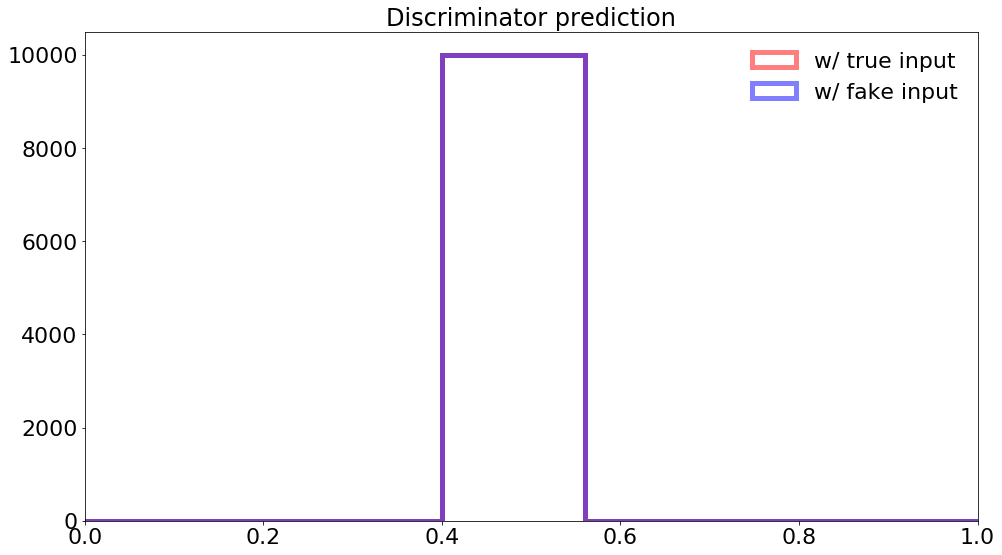

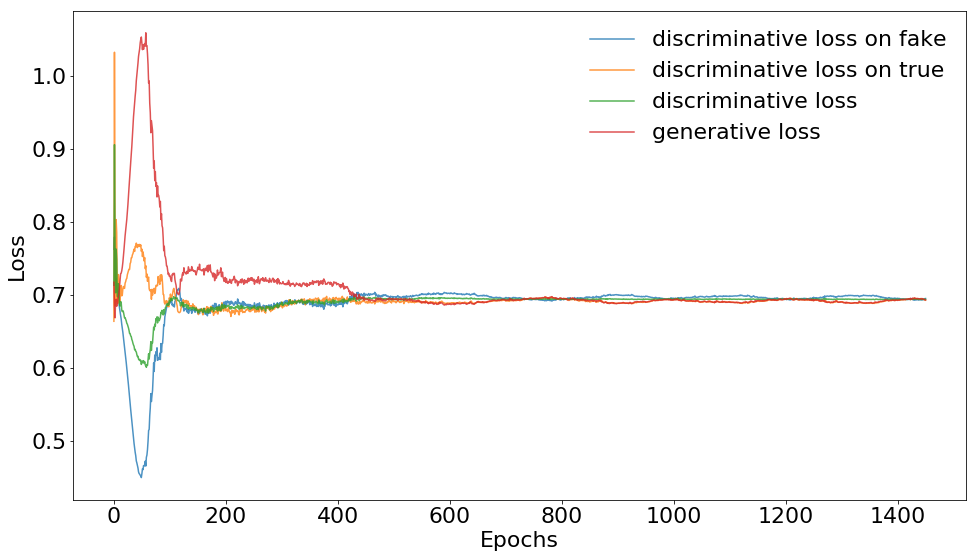

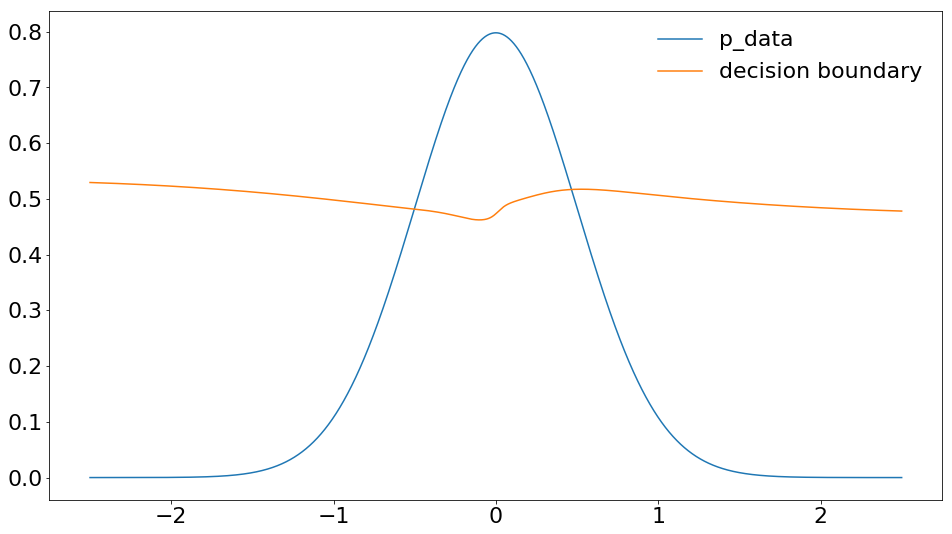

Epoch 1501, Discriminator loss:0.693823099136, GAN loss:0.689797997475
For true: mean and s.d. =  0.000448089951038 0.503776541393
For generator: mean and s.d. =  0.0312405 0.503663


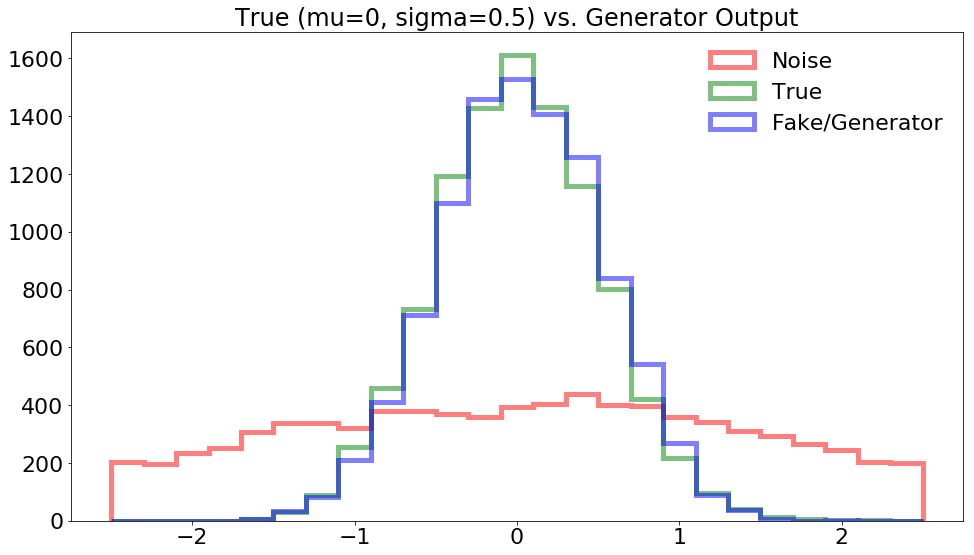

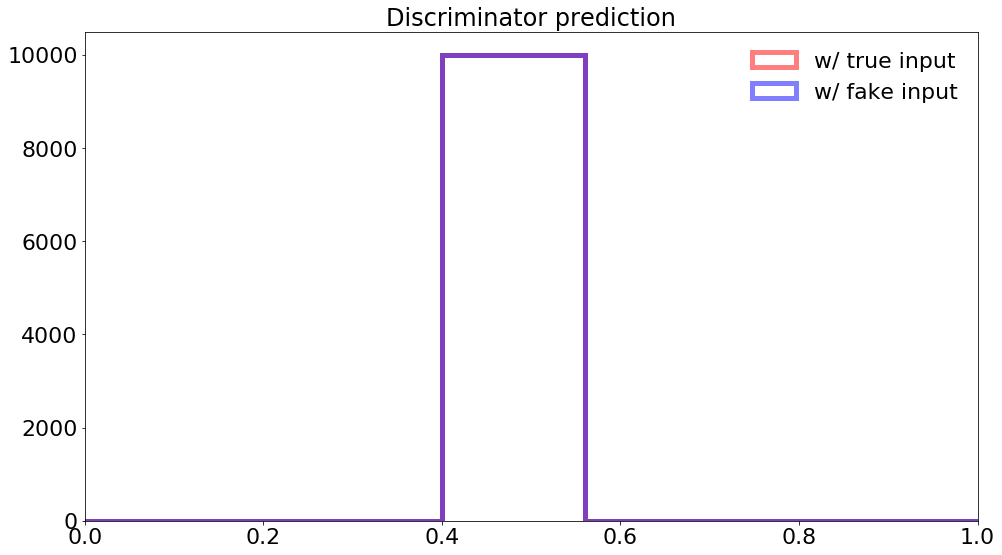

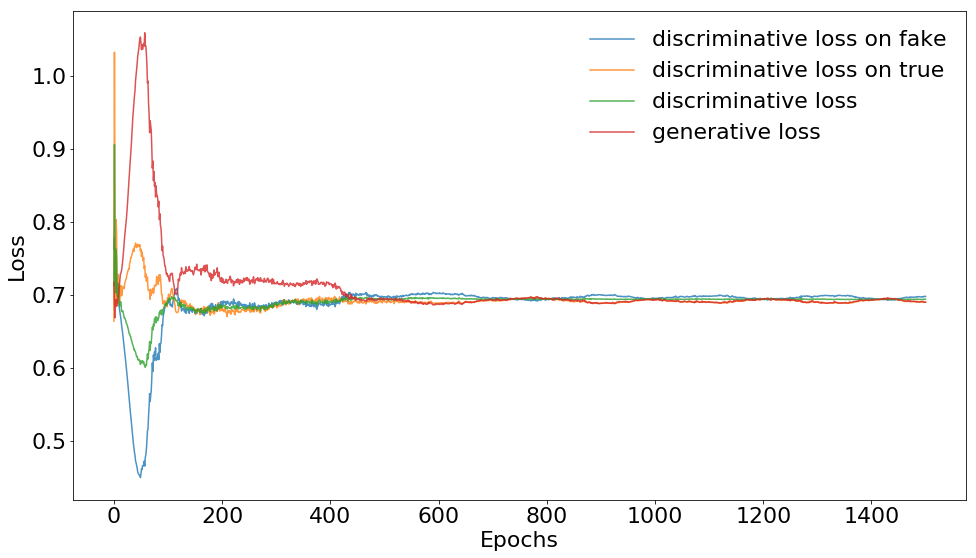

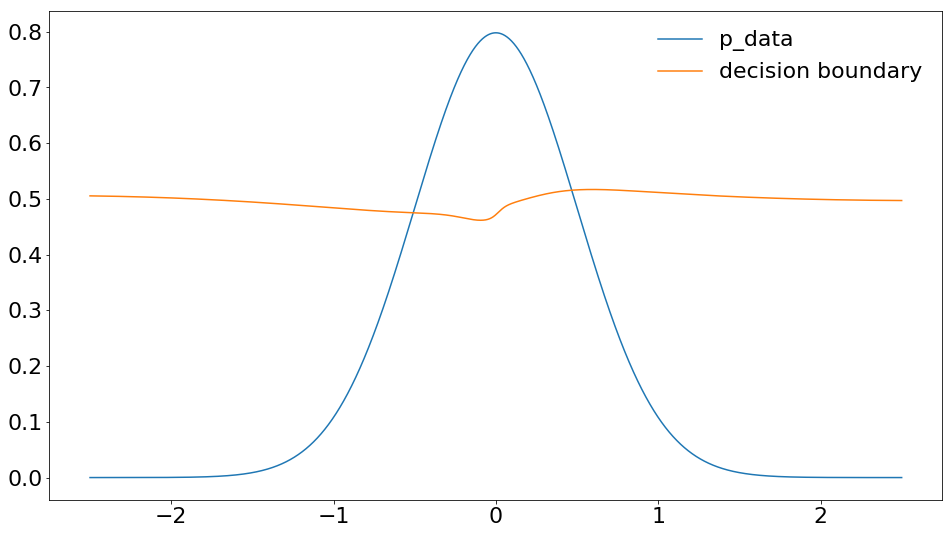

Epoch 1551, Discriminator loss:0.693869829178, GAN loss:0.688525974751
For true: mean and s.d. =  0.00248161595948 0.505373064371
For generator: mean and s.d. =  0.0300944 0.515766


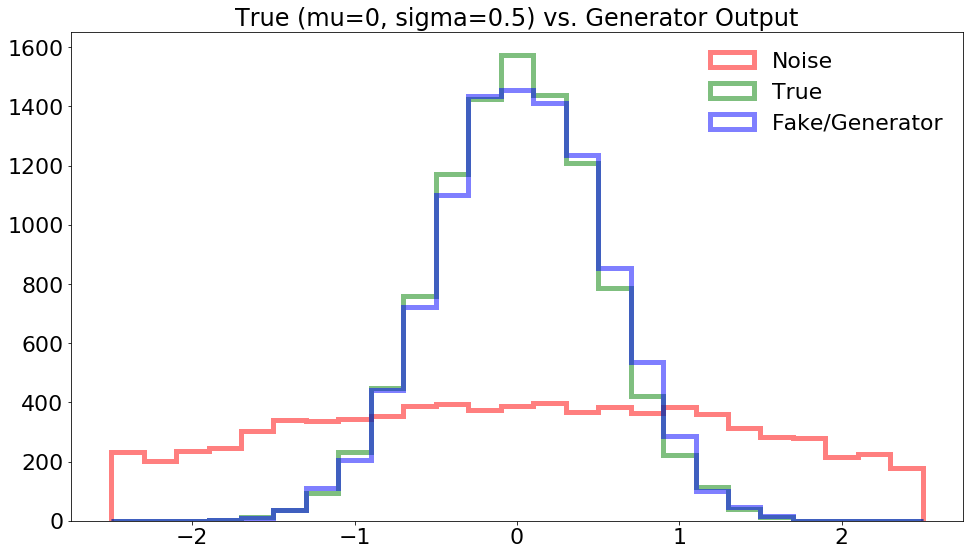

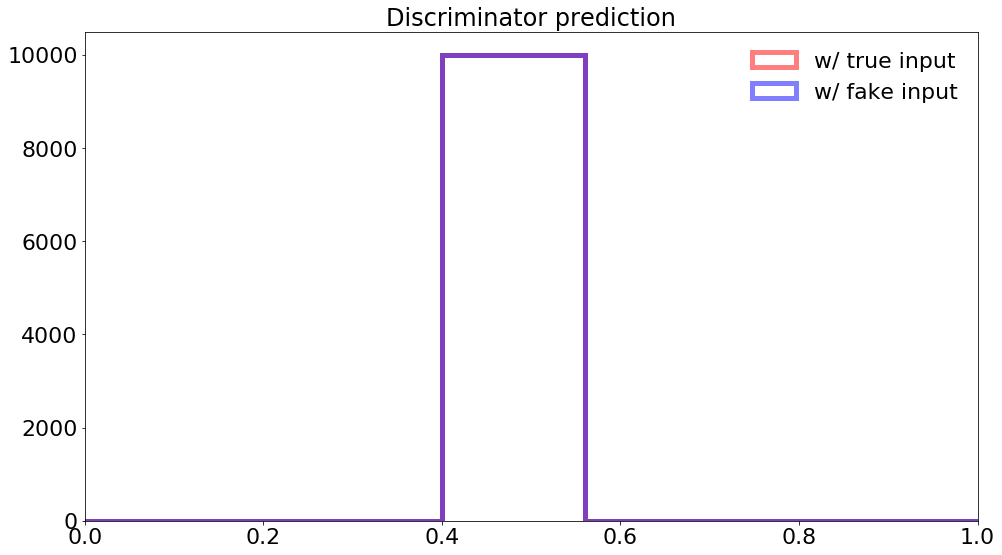

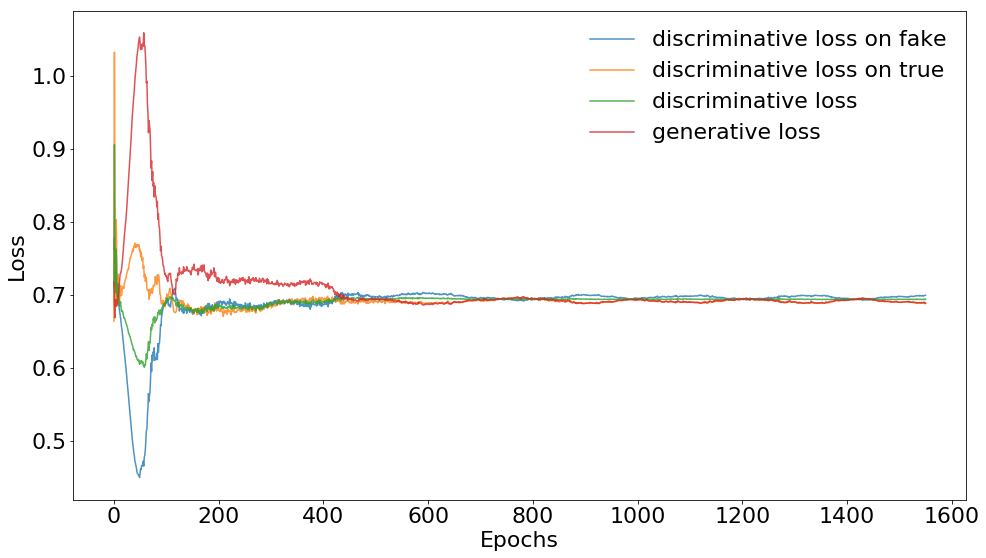

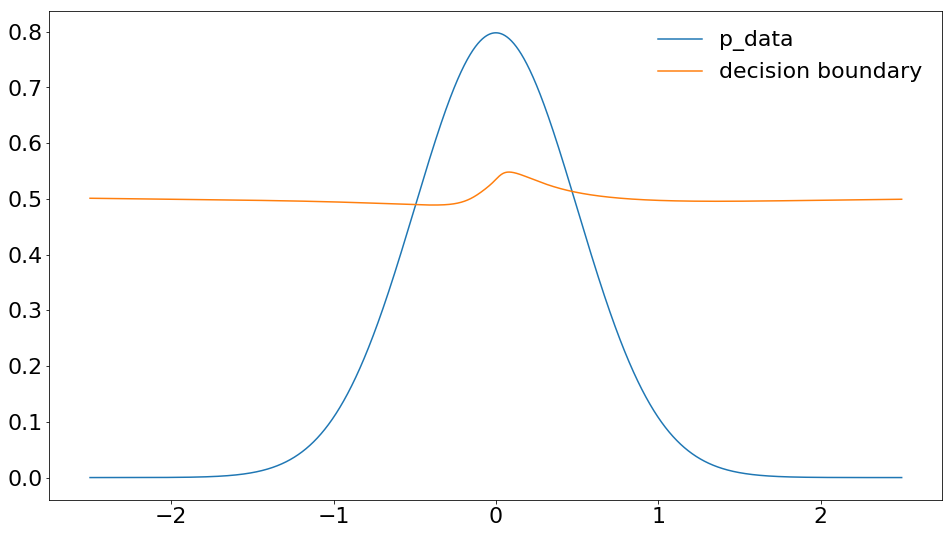

Epoch 1601, Discriminator loss:0.694100022316, GAN loss:0.692429184914
For true: mean and s.d. =  -0.00443863719073 0.495689404399
For generator: mean and s.d. =  0.0259144 0.497155


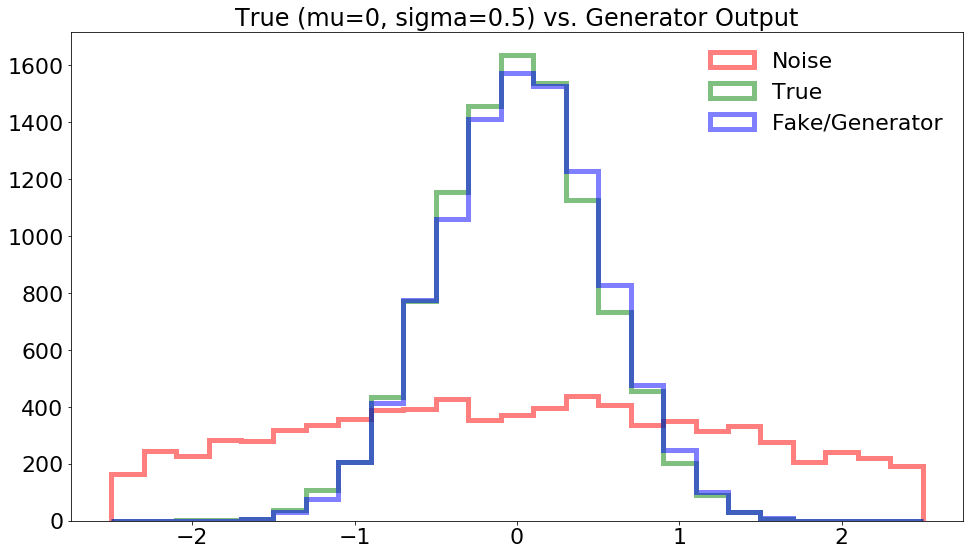

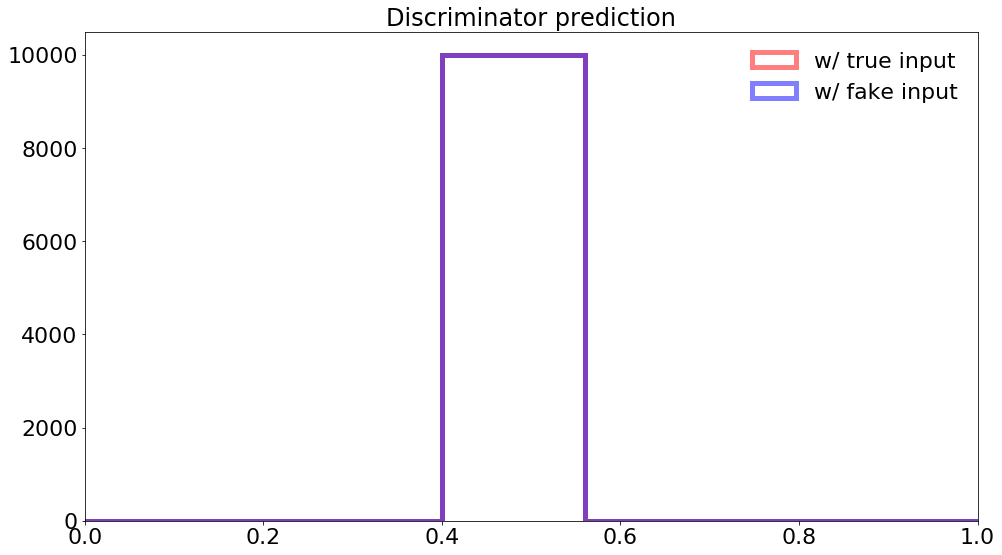

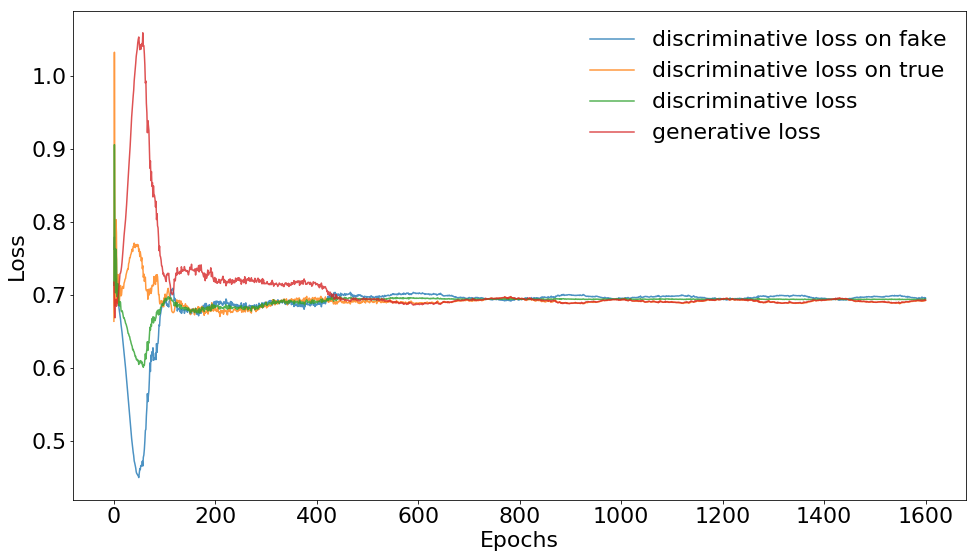

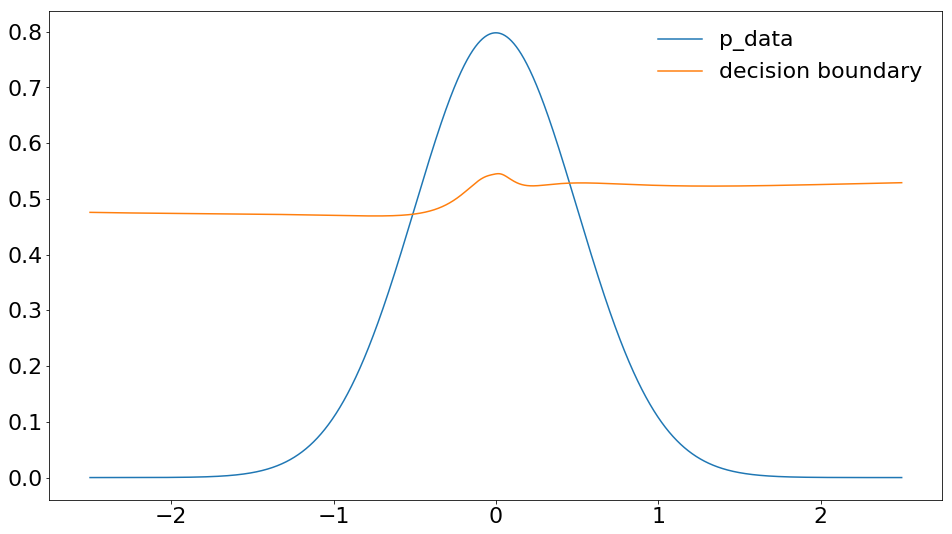

Epoch 1651, Discriminator loss:0.693677663803, GAN loss:0.693050384521
For true: mean and s.d. =  -0.00478223840238 0.498781903033
For generator: mean and s.d. =  0.0136228 0.486679


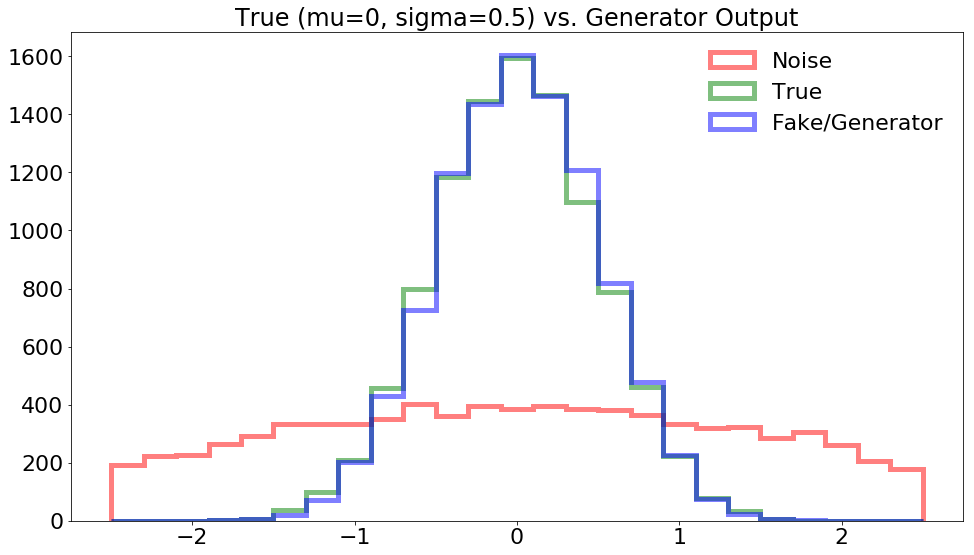

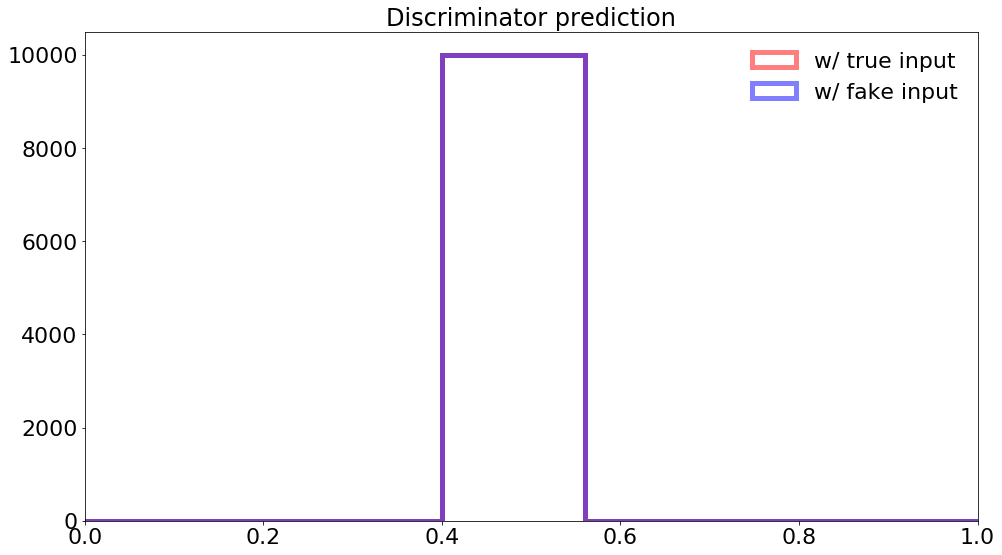

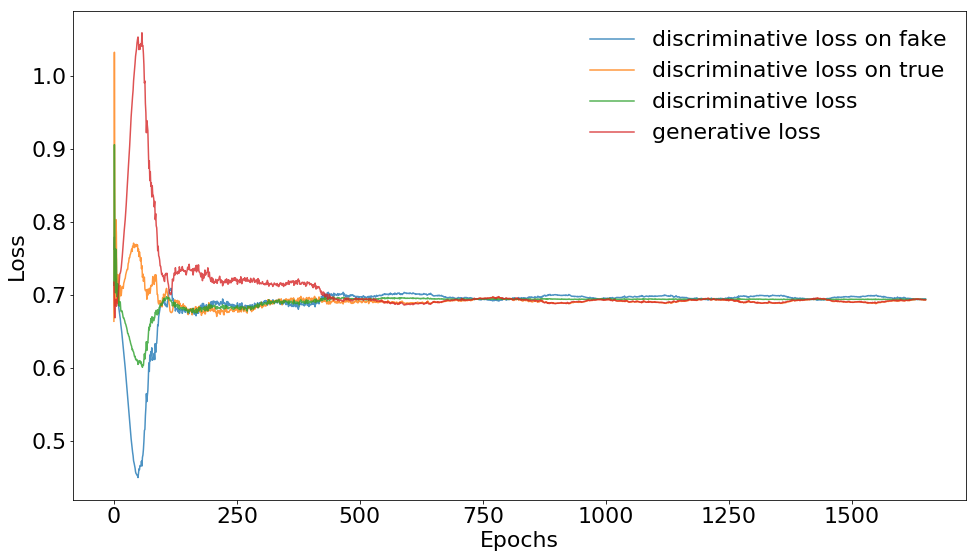

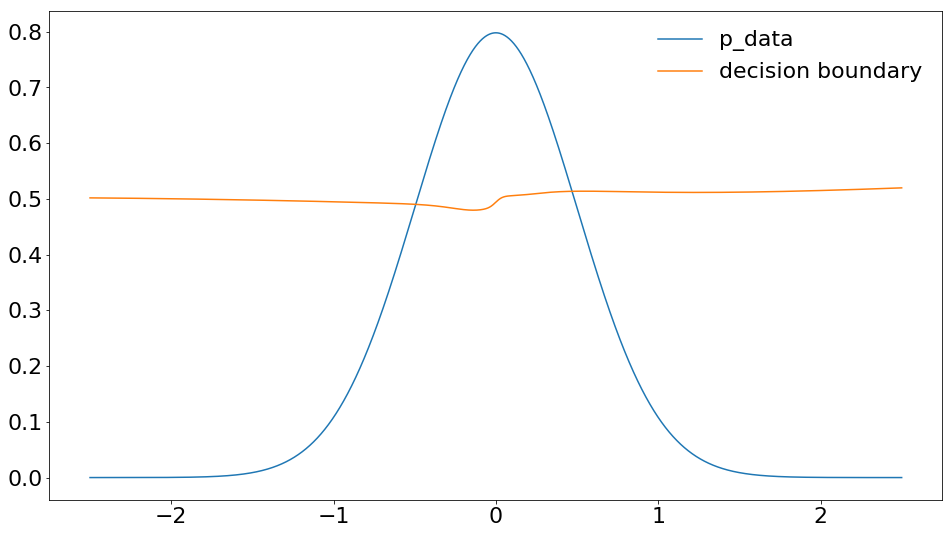

Epoch 1701, Discriminator loss:0.693681955338, GAN loss:0.690398931503
For true: mean and s.d. =  0.000303172441807 0.501343497785
For generator: mean and s.d. =  0.00769482 0.508528


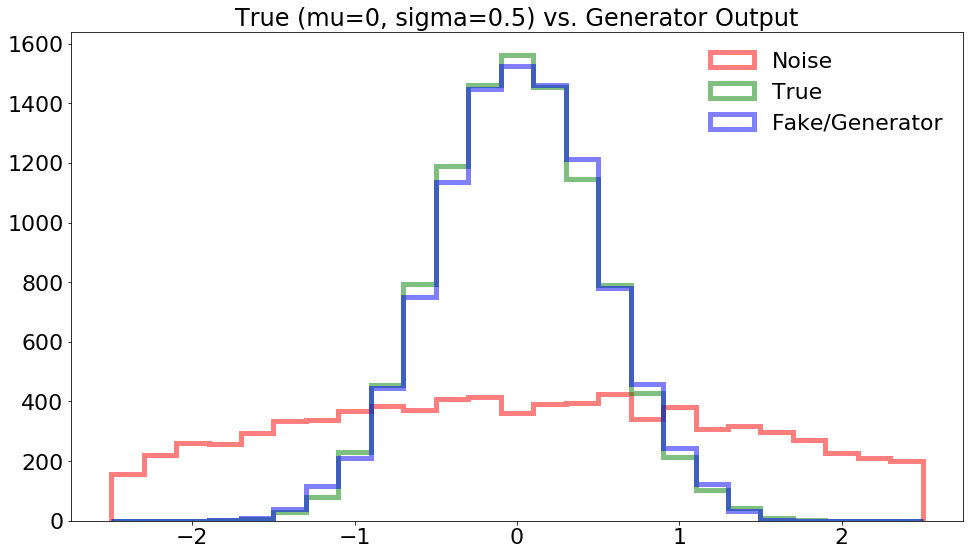

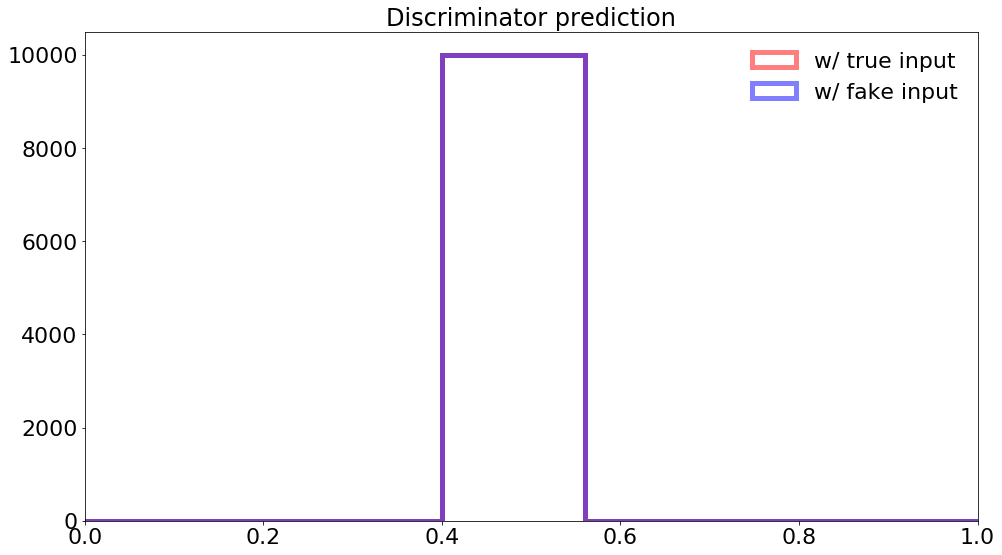

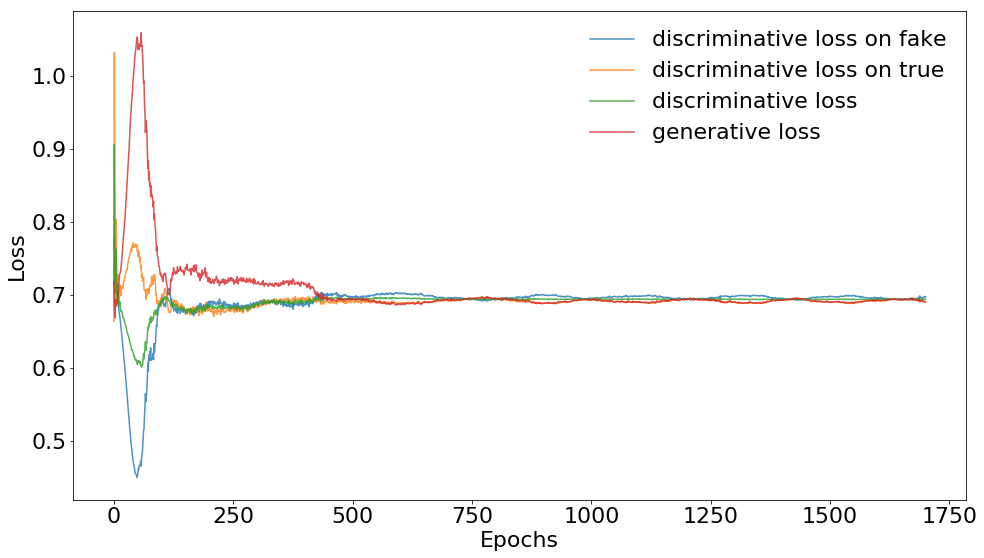

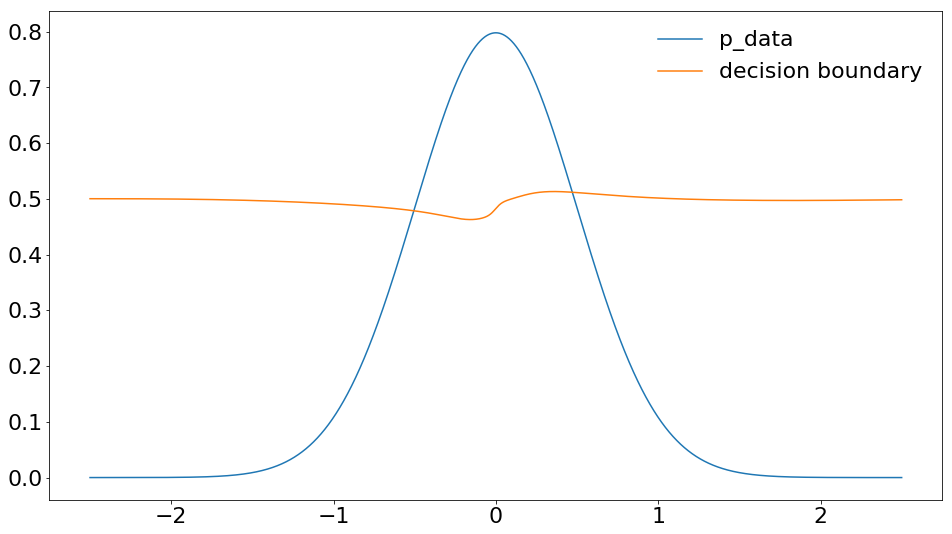

Epoch 1751, Discriminator loss:0.693505764008, GAN loss:0.688943505287
For true: mean and s.d. =  -0.00269793221312 0.500696459959
For generator: mean and s.d. =  0.00256782 0.521233


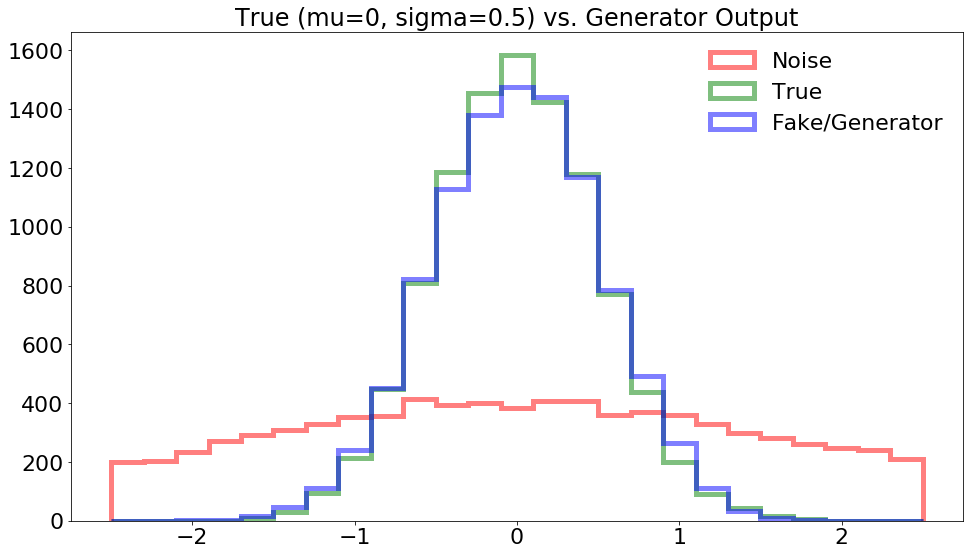

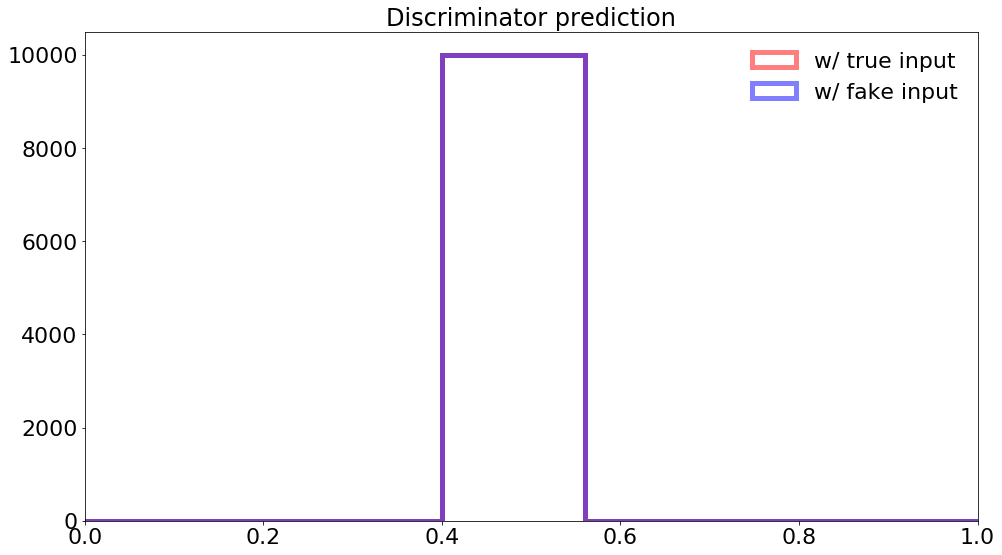

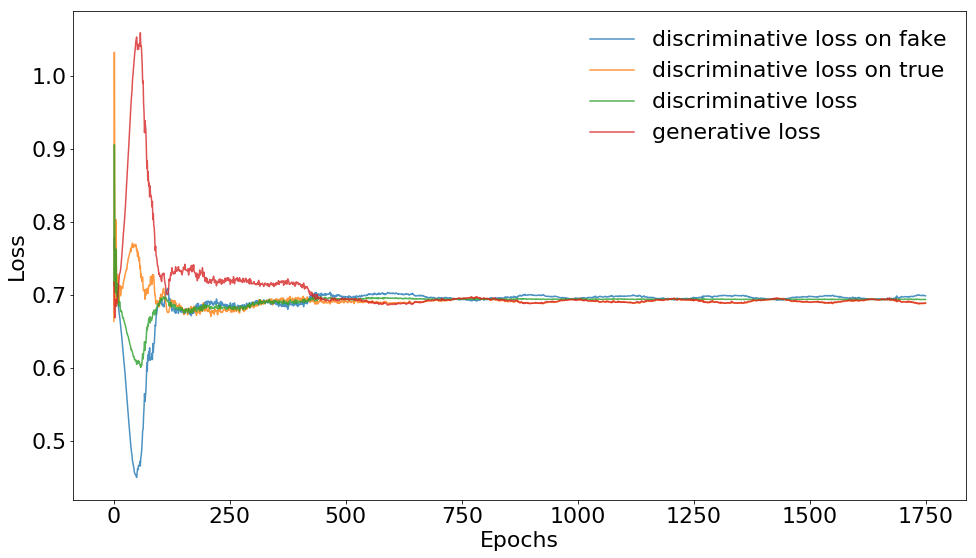

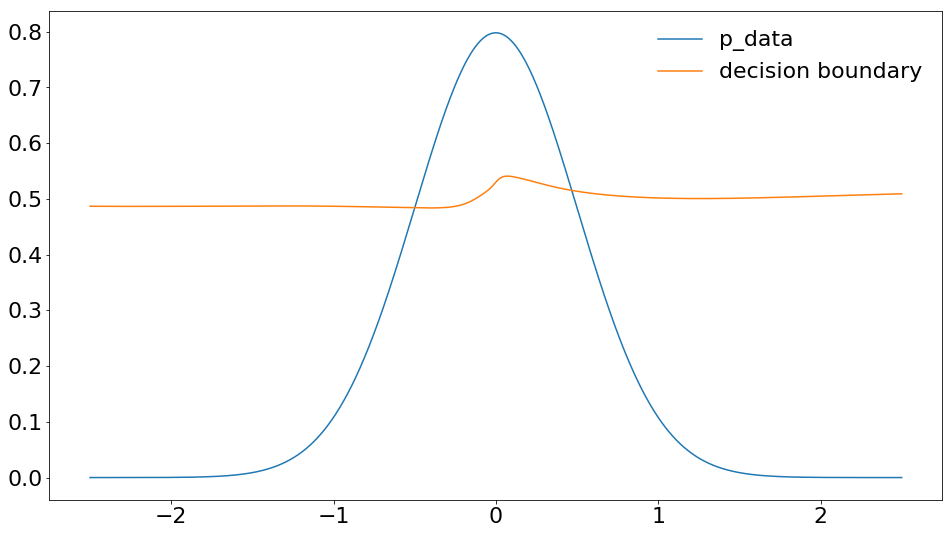

Epoch 1801, Discriminator loss:0.69362616539, GAN loss:0.69259506464
For true: mean and s.d. =  0.00352596186333 0.498606771714
For generator: mean and s.d. =  0.000259595 0.493815


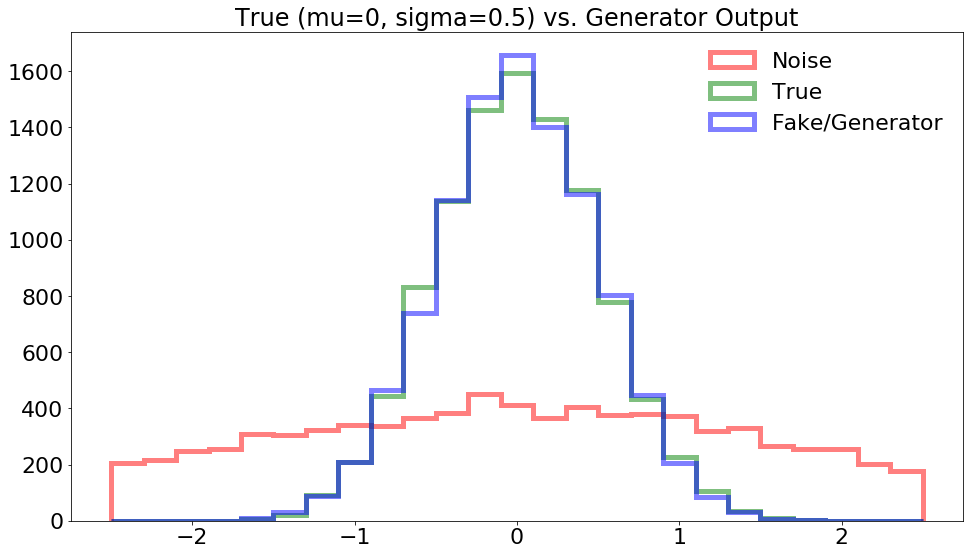

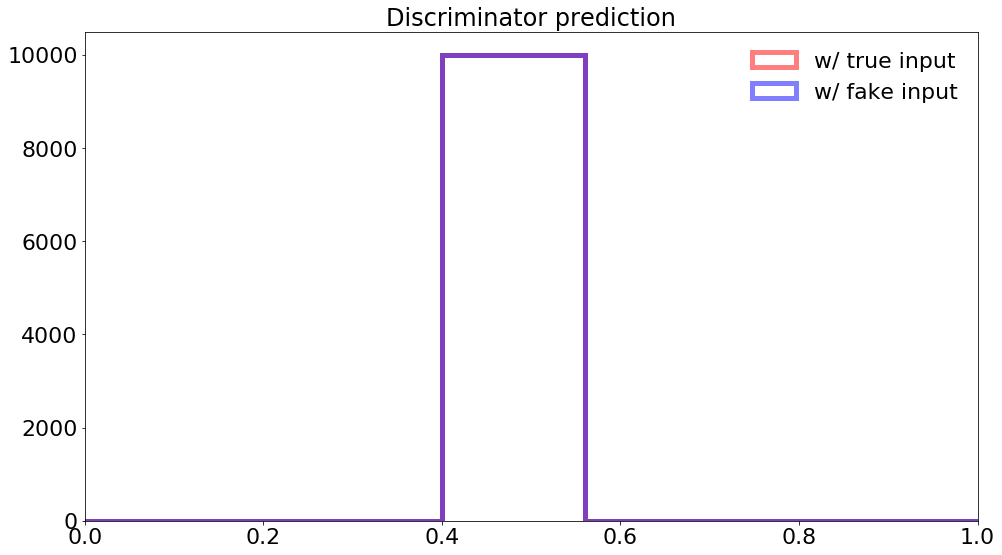

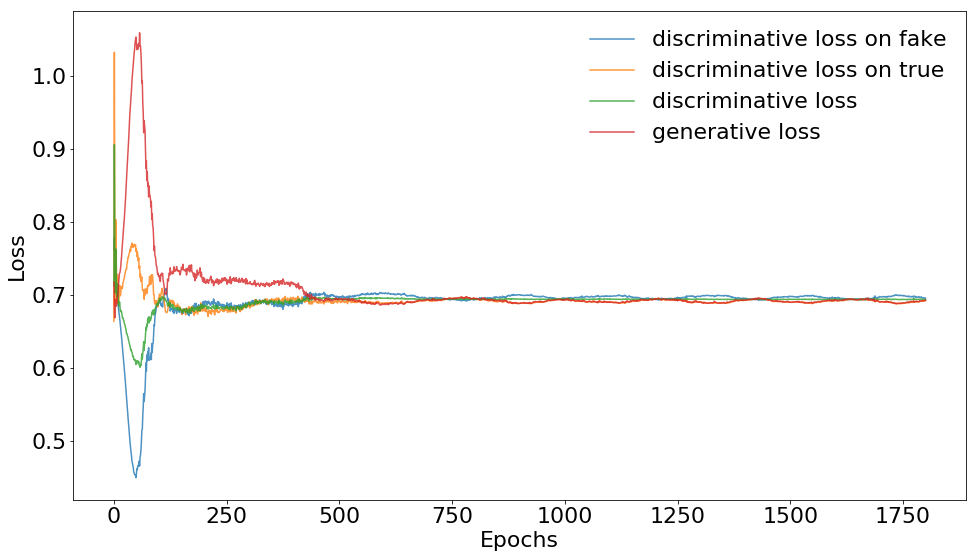

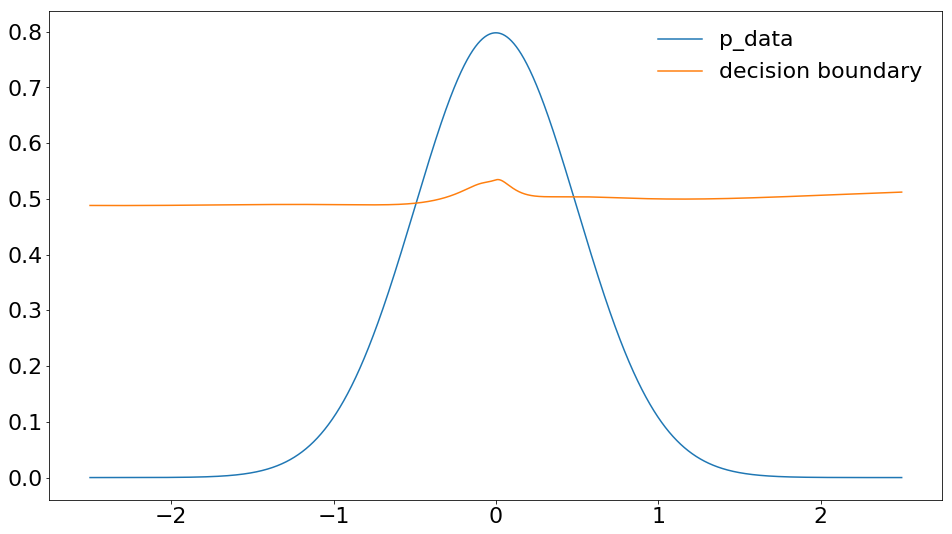

Epoch 1851, Discriminator loss:0.693729519844, GAN loss:0.692875683308
For true: mean and s.d. =  -0.00121929045613 0.499262418799
For generator: mean and s.d. =  -0.00738854 0.475239


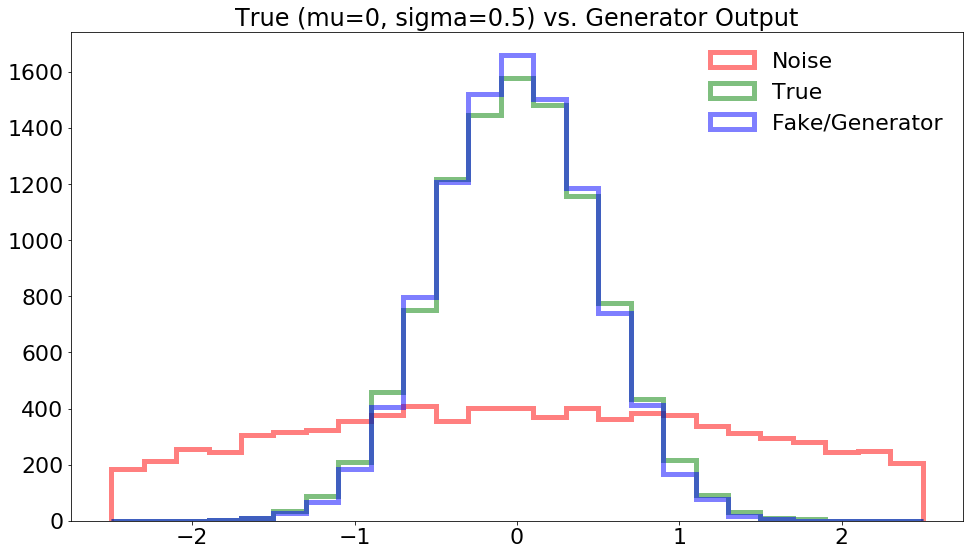

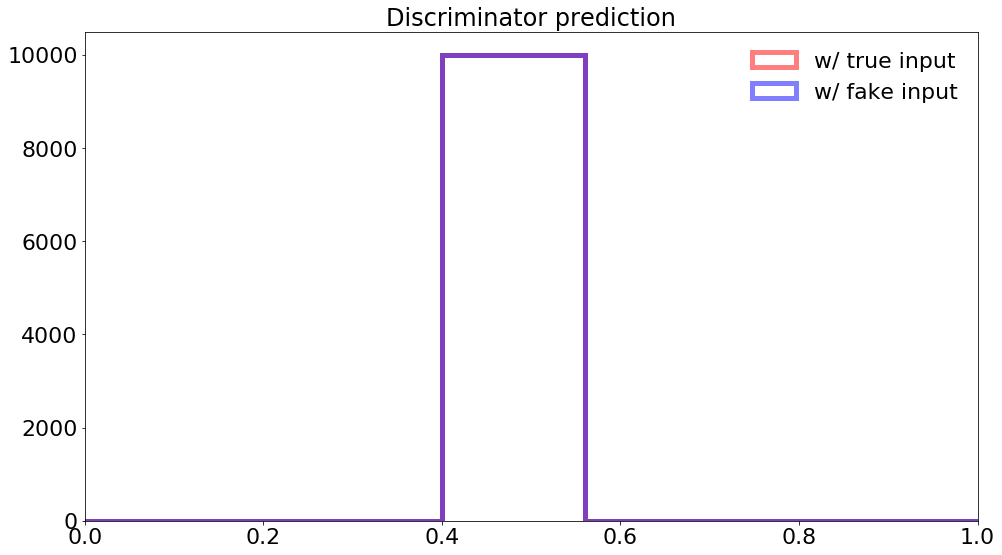

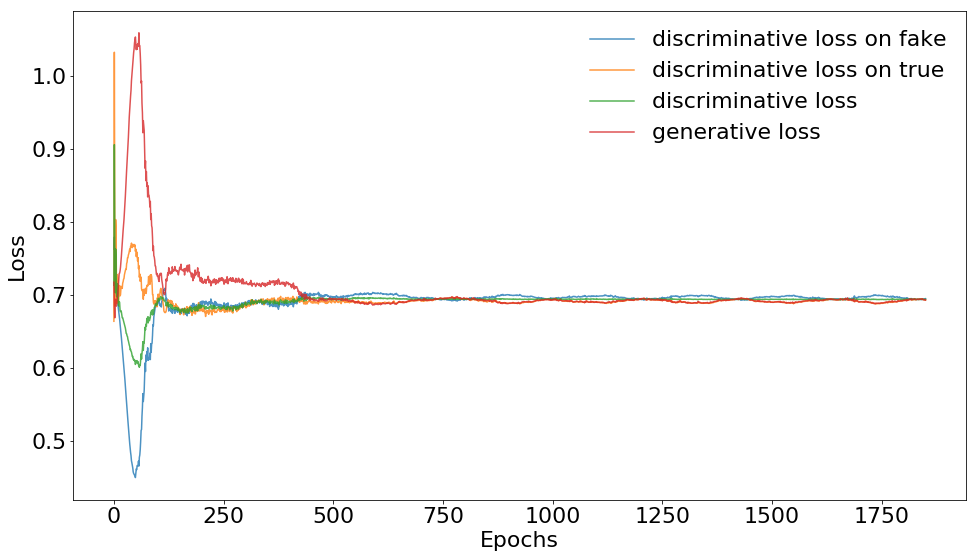

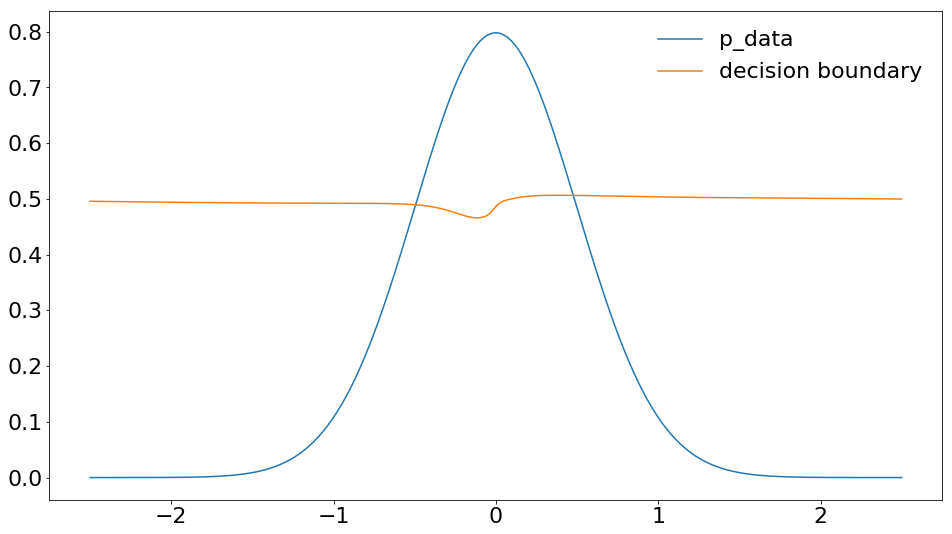

Epoch 1901, Discriminator loss:0.693802952766, GAN loss:0.689647436142
For true: mean and s.d. =  0.00132286908494 0.497831316828
For generator: mean and s.d. =  -0.00701241 0.512942


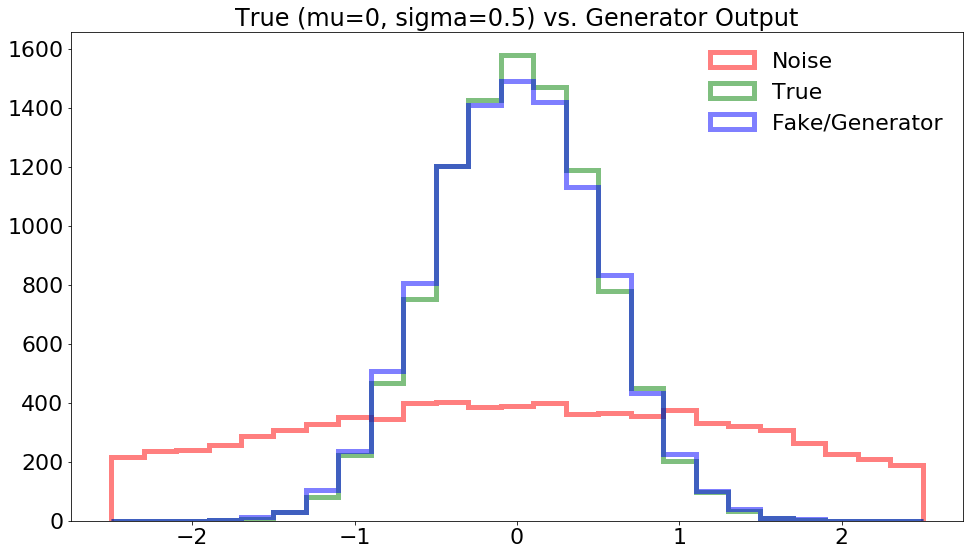

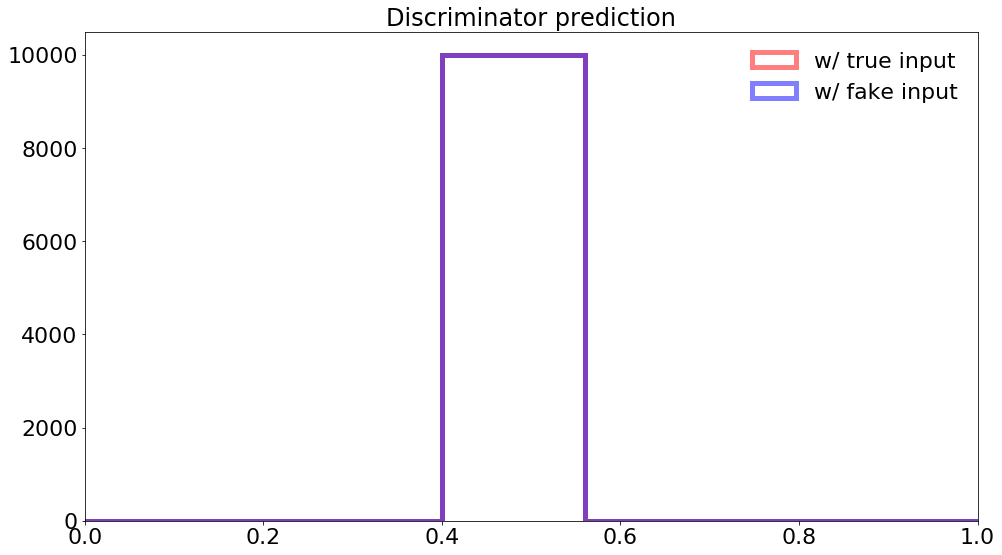

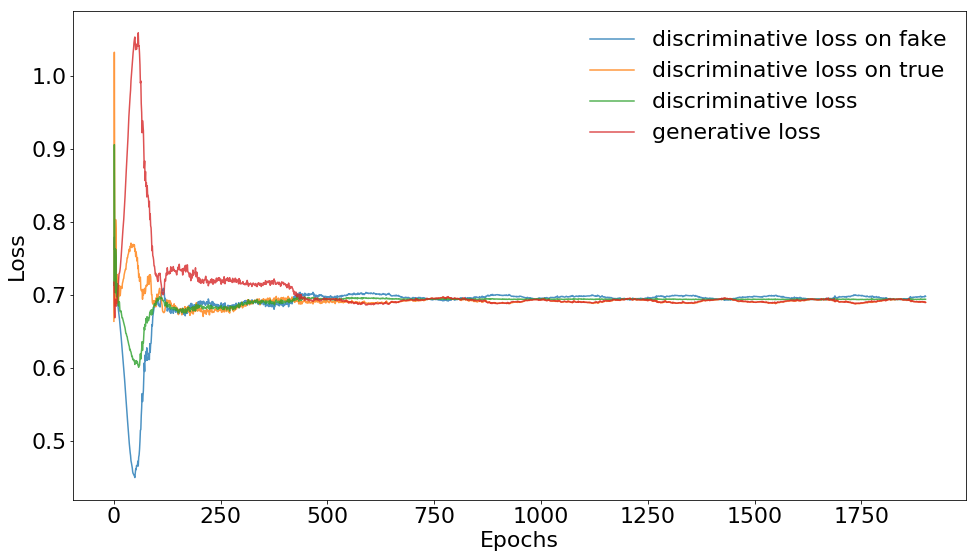

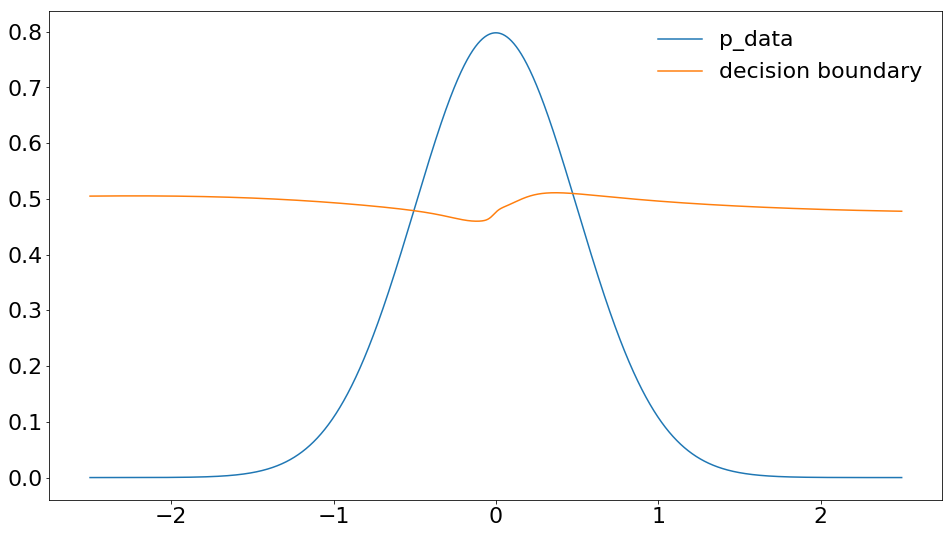

Epoch 1951, Discriminator loss:0.69383752346, GAN loss:0.687730491161
For true: mean and s.d. =  -0.00293463601443 0.501458531779
For generator: mean and s.d. =  -0.00756278 0.514481


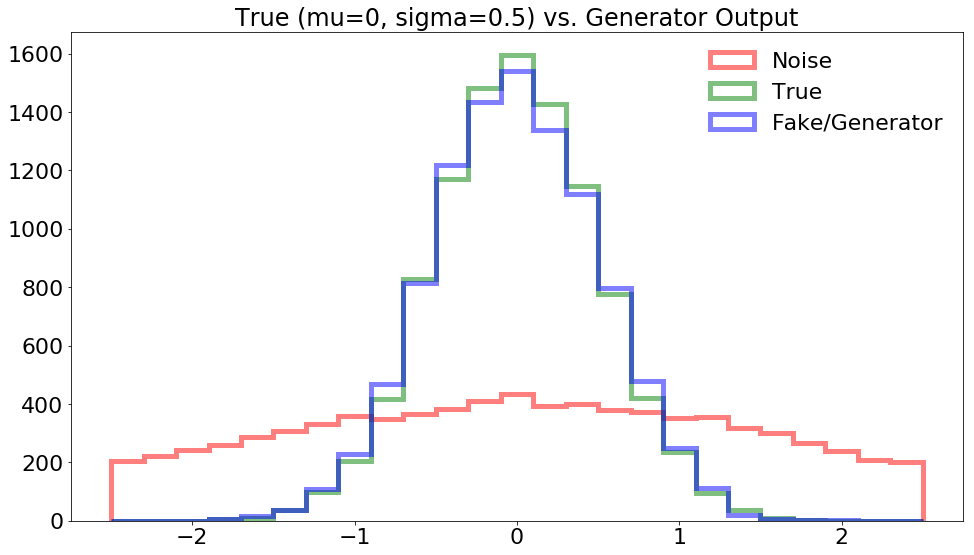

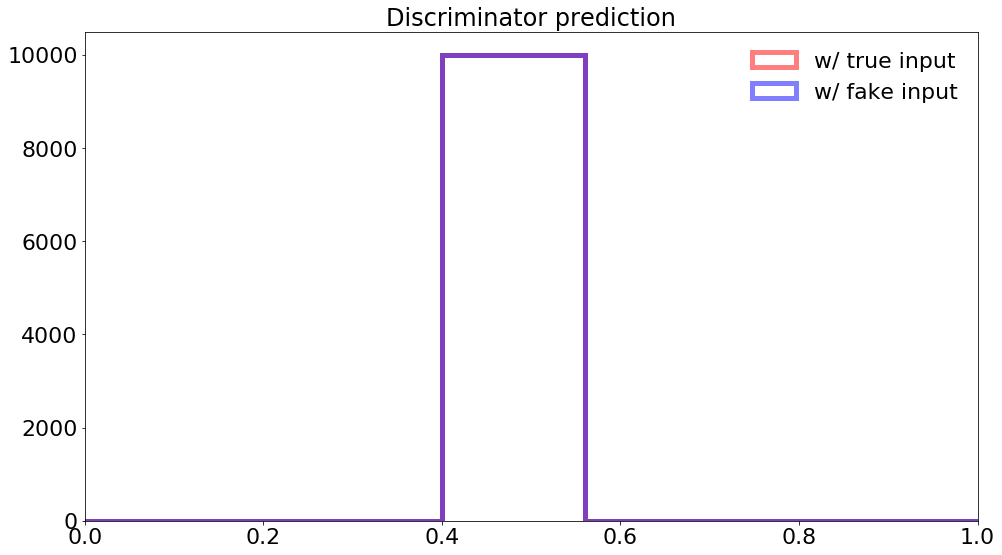

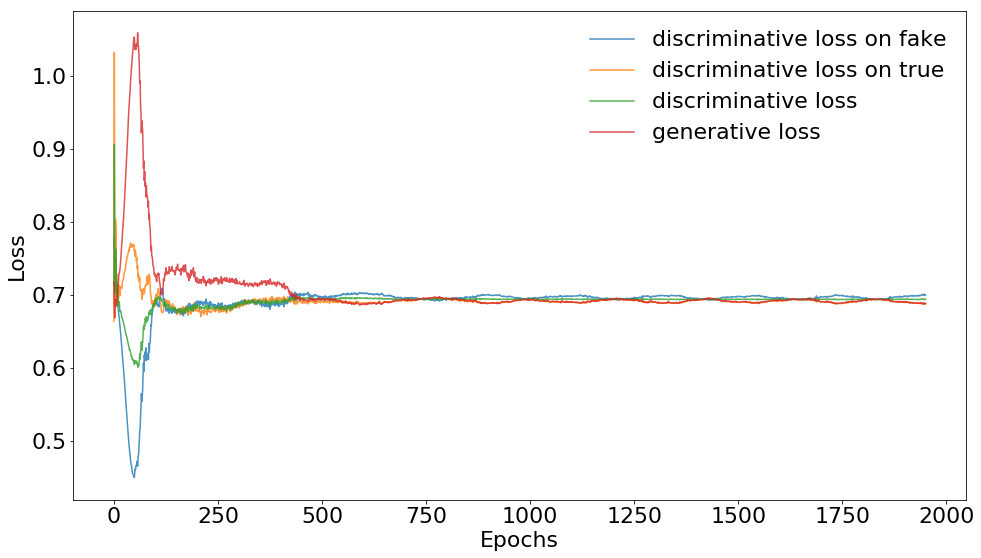

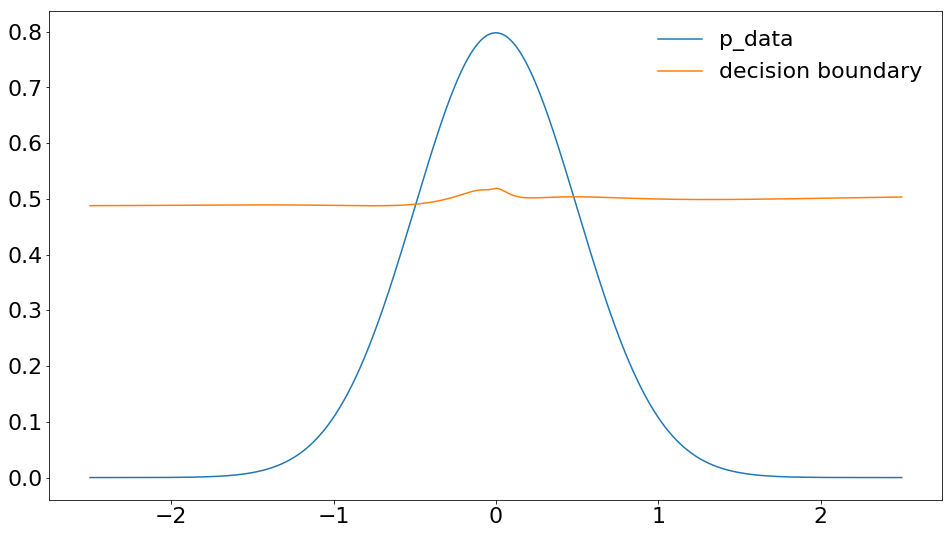

Epoch 2001, Discriminator loss:0.693605184555, GAN loss:0.693337082863
For true: mean and s.d. =  0.00624431831548 0.501672670328
For generator: mean and s.d. =  -0.021845 0.482619


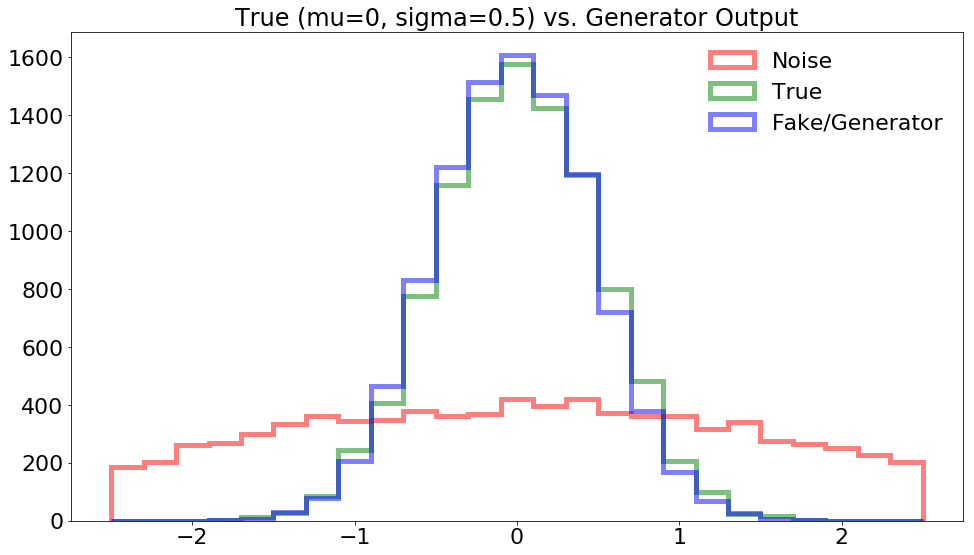

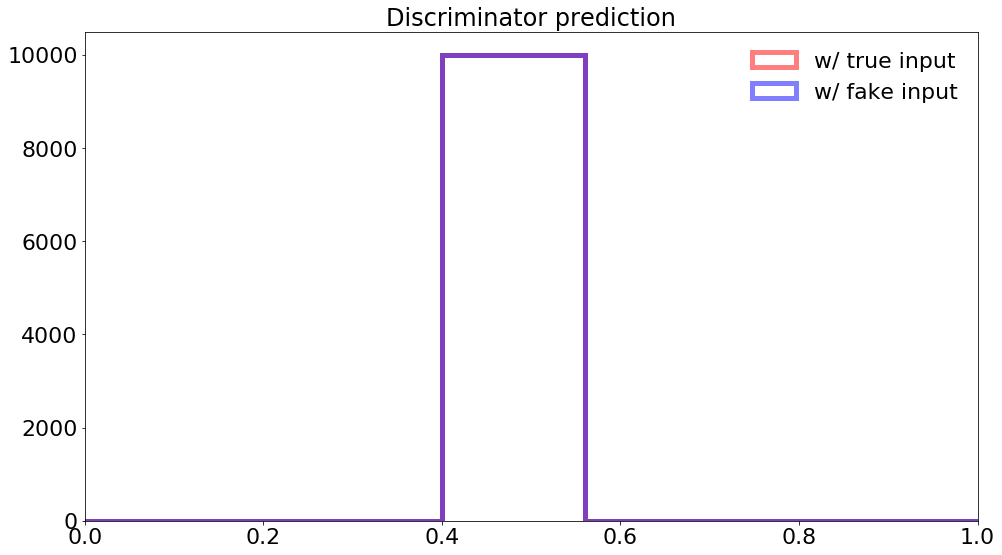

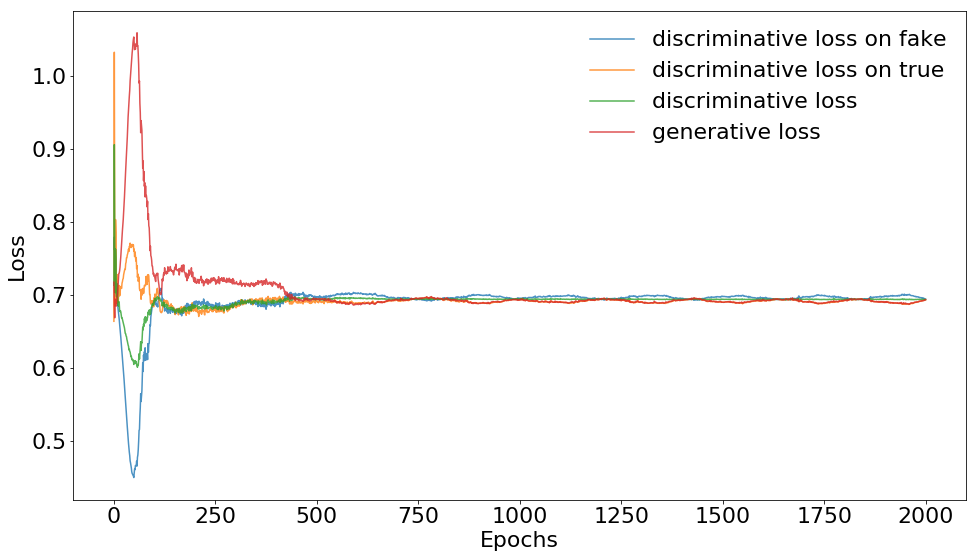

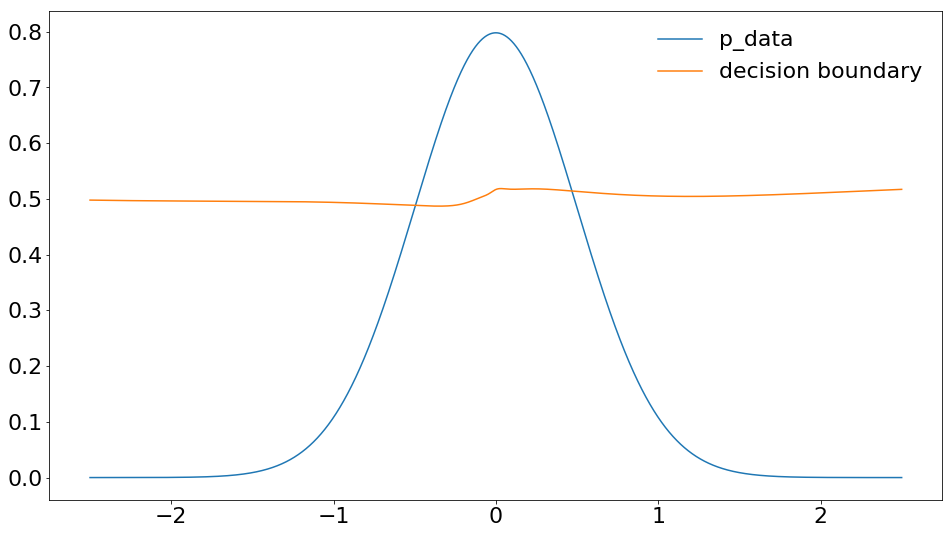

In [14]:
#training

batch_size = 3200
nb_epochs = 1001
#losses = {"d":[], "g":[]}

for i in range(0,nb_epochs):
    
    d_loss, g_loss = train(G,D,Model,i)
    #losses["d"].append(d_loss)
    #losses["g"].append(g_loss)  
    
    if i %50 == 0:
        print("Epoch {0}, Discriminator loss:{1}, GAN loss:{2}".format(i + 1, d_loss, g_loss))
        #overlay GAN output on the Gaussian we want
                
        true_disc = gaussian(10000,mu=0.,sigma=0.5)
        sd = np.std(true_disc)
        mean = np.mean(true_disc)
        print "For true: mean and s.d. = ", mean, sd
        latent = noise_g(10000,mu=0.,sigma=2.)
    
        G.trainable = False
        D.trainable = False
        fake_disc = G.predict(latent)
        
        sd = np.std(fake_disc)
        mean = np.mean(fake_disc)
        print "For generator: mean and s.d. = ", mean, sd
        
        plt.figure(figsize=(16,9))
        plt.title("True (mu=0, sigma=0.5) vs. Generator Output", fontsize=24)
        plt.hist(latent, color='r', histtype='step', linewidth=5, bins = 25, range = (-2.5,2.5), label = "Noise", alpha=0.5)
        plt.hist(true_disc, color='g', histtype='step', linewidth=5, bins = 25, range = (-2.5,2.5), label = "True", alpha=0.5)
        plt.hist(fake_disc, color='b', histtype='step', linewidth=5, bins = 25, range = (-2.5,2.5), label = 'Fake/Generator', alpha=0.5)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        # plt.ylim(0,0.6)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        plt.show()     
        #print losses
        
        true_pred = D.predict(true_disc)
        fake_pred = D.predict(fake_disc)
            
        plt.figure(figsize=(16,9))
        plt.title("Discriminator prediction", fontsize=24)
        plt.hist(true_pred, color='r', histtype='step', linewidth=5, bins = 25, range = (-2.,2.), label = "w/ true input", alpha=0.5)
        plt.hist(fake_pred, color='b', histtype='step', linewidth=5, bins = 25, range = (-2.,2.), label = 'w/ fake input', alpha=0.5)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        plt.xlim(0.,1.)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        plt.show()
        
        
        plot_loss(losses)
        plot_decision_boundary(D)
    #savemodel(model=Model, name="GaussiGAN_mb_gauslat")

1.17645 0.471344


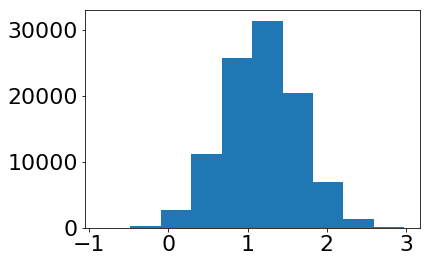

In [22]:
p = G.predict(noise_g(batch_size=100000, mu=-5., sigma=2.))
plt.hist(p)
print p.mean(), p.std()

-2.39958271105 2.46865575997
For generator: mean and s.d =  -0.0195691 0.484099


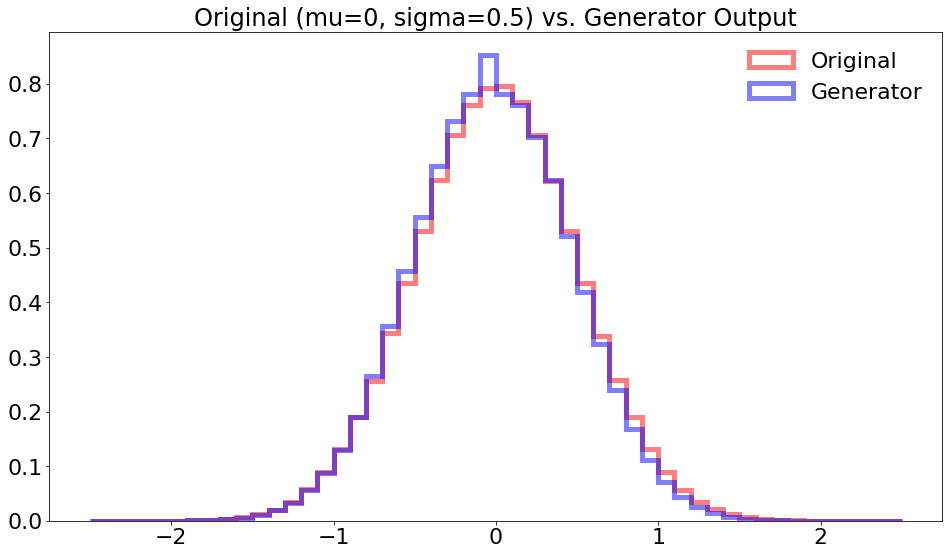

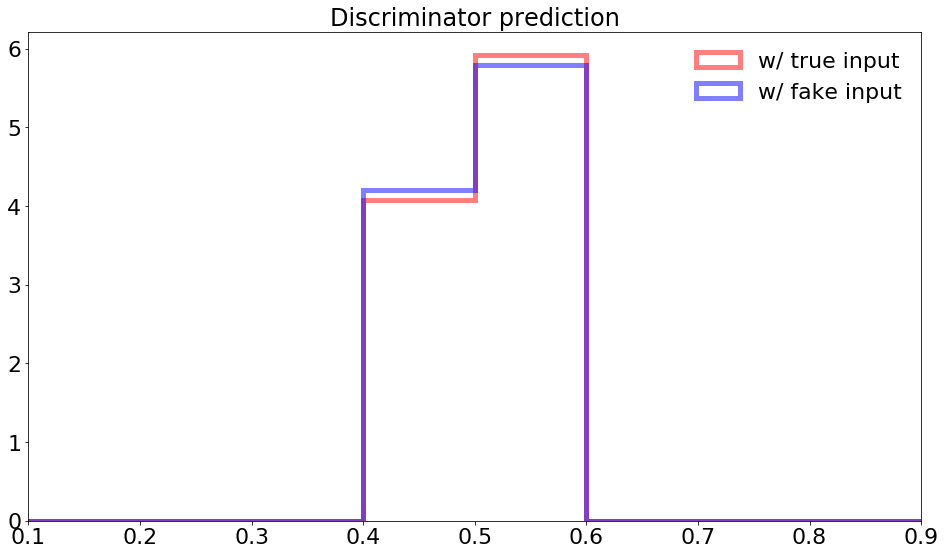

In [23]:
        ###################
        batch_size = 1000000    
        true_disc = gaussian(batch_size,mu=0.,sigma=0.5)
        true_disc.sort()
        print true_disc.min(), true_disc.max()
        sd = np.std(true_disc)
        mean = np.mean(true_disc)
        latent = noise_g(batch_size,mu=0., sigma=2.0)
        latent.sort()
        G.trainable = False
        D.trainable = False
        fake_disc = G.predict(latent)
        #print fake_disc
        sd = np.std(fake_disc)
        mean = np.mean(fake_disc)
        print "For generator: mean and s.d = ", mean, sd
        ###################
        
        plt.figure(figsize=(16,9))
        plt.title("Original (mu=0, sigma=0.5) vs. Generator Output", fontsize=24)
        plt.hist(true_disc, color='r', histtype='step', linewidth=5, bins = 50, range = (-2.5,2.5), label = "Original", alpha=0.5, normed=True)
        plt.hist(fake_disc, color='b', histtype='step', linewidth=5, bins = 50, range = (-2.5,2.5), label = 'Generator', alpha=0.5, normed=True)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        # plt.ylim(0,0.6)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        # plt.savefig("GaussiGAN_mbd_unilat_gen_PDF.png")
        plt.show()     
        #print losses
        
        true_pred = D.predict(true_disc)
        fake_pred = D.predict(fake_disc)
            
        plt.figure(figsize=(16,9))
        plt.title("Discriminator prediction", fontsize=24)
        plt.hist(true_pred, color='r', histtype='step', linewidth=5, bins = 10, range = (0.,1.), label = "w/ true input", alpha=0.5, normed=True)
        plt.hist(fake_pred, color='b', histtype='step', linewidth=5, bins = 10, range = (0.,1.), label = 'w/ fake input', alpha=0.5, normed=True)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        plt.xlim(0.1,0.9)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        #plt.savefig("GaussiGAN_mbd_unilat_disc_pred.png")
        plt.show()

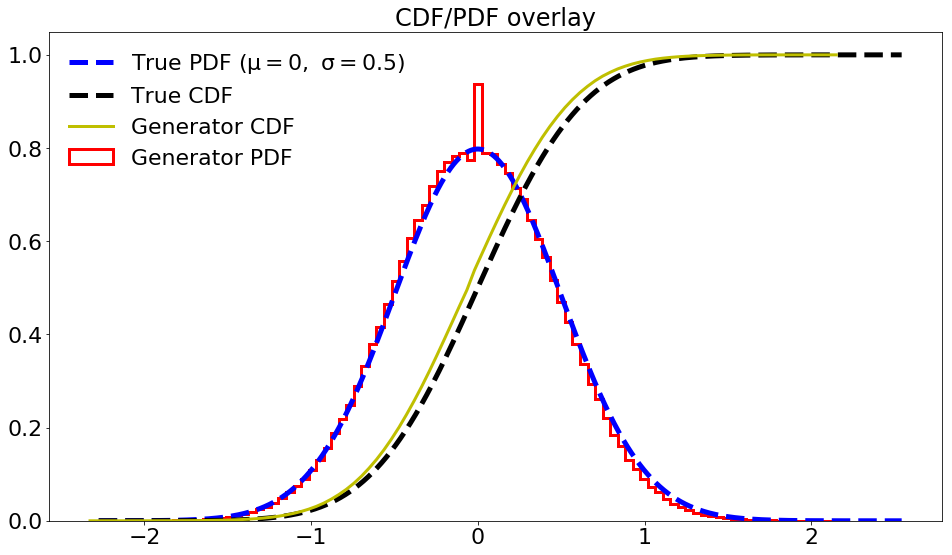

In [24]:
batch_size=1000000
import scipy.stats as stats        

true = gaussian(batch_size=batch_size, mu=0., sigma = 0.5)
true.sort()
tmean = np.mean(true)
tstd = np.std(true)
tpdf = stats.norm.pdf(true, tmean, tstd)
tcdf = stats.norm.cdf(true, tmean, tstd)
#x = np.linspace(true.min(), true.max(), 100000)

latent = noise_g(batch_size=batch_size, mu=0., sigma = 2.0)
latent.sort()
G_x = G.predict(latent)

H_G,X_G = np.histogram(G_x, bins = 100, normed = True )
dx = X_G[1] - X_G[0]
F_G = np.cumsum(H_G)*dx


plt.figure(figsize=(16,9))
plt.title("CDF/PDF overlay", fontsize=24)

plt.plot(true, tpdf, 
         color='b', linestyle='--', linewidth=5, label = r"$\mathrm{True\ PDF\ (\mu=0,\ \sigma=0.5)}$")

plt.plot(true, tcdf, 
         color = 'k', linestyle='--', linewidth=5, label = "True CDF")

plt.hist(G_x, histtype='step', bins =100, normed=True,
         color = 'r', linewidth=3, label ="Generator PDF")

plt.plot(X_G[:-1], F_G, 
         color = 'y', linewidth=3, label="Generator CDF")

plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
plt.rc('xtick', labelsize = 22)
plt.rc('ytick', labelsize = 22)
#plt.savefig("GaussiGAN_1_mbd_g1_overlay.png")
plt.show()
